# 0.0. Imports

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import datetime
import random
import pickle
import pandas  as pd
import numpy   as np
import seaborn as sns
import xgboost as xgb

from boruta                import BorutaPy
from tabulate              import tabulate
from IPython.display       import Image
from seaborn.matrix        import heatmap
from IPython.core.display  import display, HTML
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import MinMaxScaler, LabelEncoder,StandardScaler
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from scipy                 import stats  as ss
from matplotlib            import pyplot as plt

# display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams['figure.figsize'] = [ 30, 10 ]
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 0.1. Helper Functions

In [ ]:
# Cramer's V
def cramer_v( x, y ):
    # confusion matrix
    cm = pd.crosstab(x,y).values

    # sum of cm values
    n = cm.sum()

    # number of rows and columns
    r, k = cm.shape

    # contingency table
    chi2 = ss.chi2_contingency(cm)[0]

    # cramer's v bias correction (overestimation tendency)
    chi2corr = max( 0, chi2-(k-1)*(r-1)/(n-1) )
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)

    return np.sqrt( ( chi2corr/n )/( min( kcorr-1, rcorr-1 ) ) )

# Machine Learning model error
def ml_error( model_name, y, yhat ):
    y = np.expm1(y)
    yhat = np.expm1(yhat)

    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse =  np.sqrt(mean_squared_error( y, yhat ))

    return pd.DataFrame( { 'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse
                          }, index=[0] )

# Cross Validation
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print('KFold Number: {}/{}'.format(k,kfold))

        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days = k*2*7 )
        validation_end_date = x_training['date'].max() - datetime.timedelta( days = (k-1)*2*7 )

        # filtering dataset
        training = x_training[ x_training['date'] < validation_start_date ]
        validation = x_training[ (x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date) ]
        
        # training dataset
        xtraining = training.drop(['date','sales'],axis=1)
        ytraining = training['sales']

        # validation dataset
        xvalidation = validation.drop(['date','sales'],axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict(xvalidation)
        
        # performance
        m_result = ml_error( model_name, yvalidation, yhat )            

        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( { 'Model Name': model_name,
                  'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                  'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                  'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )   
                }, index=[0] )

## 0.2. Loading Data

In [ ]:
# data between 31/12/12 and 15/08/17
df_train_raw        = pd.read_csv('../data/raw/train.csv')
df_transactions_raw = pd.read_csv('../data/raw/transactions.csv')
df_stores_raw       = pd.read_csv('../data/raw/stores.csv')
df_oil_raw          = pd.read_csv('../data/raw/oil.csv')
df_holiday_raw      = pd.read_csv('../data/raw/holidays_events.csv')

In [ ]:
# unindo datasets
merge = pd.merge(df_train_raw, df_stores_raw, how='left', on='store_nbr')
merge = pd.merge(merge, df_oil_raw, how='left', on='date')
merge = pd.merge(merge, df_transactions_raw, how='left', on=['date','store_nbr'])

df_raw = merge.drop('id', axis=1)

df_raw.to_csv('../data/processed/df0.csv',index=False)

# 1.0. Data Description

In [ ]:
# copy into a new dataset to keep the progress made until now
df1 = pd.read_csv('../data/processed/df0.csv')

## 1.1. Rename Columns

In [ ]:
df1.columns

Index(['date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city', 'state',
       'type', 'cluster', 'dcoilwtico', 'transactions'],
      dtype='object')

In [ ]:
df1 = df1.rename(columns={
    'type': 'store_type',
    'cluster': 'store_cluster'
})

## 1.2. Data Dimensions

In [ ]:
print( 'Number of rows: {}\nNumber of columns: {}'.format( df1.shape[0], df1.shape[1] ) )

Number of rows: 3000888
Number of columns: 11


## 1.3. Data Types

In [ ]:
df1.dtypes

date              object
store_nbr          int64
family            object
sales            float64
onpromotion        int64
city              object
state             object
store_type        object
store_cluster      int64
dcoilwtico       float64
transactions     float64
dtype: object

## 1.4. Check NA

In [ ]:
# absolute and percentual number of NAs
checkna = pd.DataFrame([df1.isna().sum(), df1.isna().sum() / df1.shape[0] * 100]).T.reset_index(drop=False)
checkna = checkna.rename(columns={'index':'column',0:'absolute',1:'percentual'})
checkna

,column,absolute,percentual
0,date,0.000,0.000
1,store_nbr,0.000,0.000
2,family,0.000,0.000
3,sales,0.000,0.000
4,onpromotion,0.000,0.000
5,city,0.000,0.000
6,state,0.000,0.000
7,store_type,0.000,0.000
8,store_cluster,0.000,0.000
9,dcoilwtico,928422.000,30.938


## 1.5. Fillout NAs

In [ ]:
# setando colunas de datas
df1['date']         = pd.to_datetime(df1['date'])
df1['year_week']    = df1['date'].dt.strftime('%Y-%W')

# zerar os registros de teste
df1['sales'] = df1['sales'].fillna(0)

# finais de semana e feriados não há registro de cotação. utilizando a média da semana para preencher esses NAs
aux = df1[['date','dcoilwtico']].copy()
aux = aux.drop_duplicates(subset='date').reset_index(drop=True)
aux['year_week'] = aux['date'].dt.strftime('%Y-%U')
aux2 = aux[['year_week','dcoilwtico']].groupby('year_week').mean().reset_index()
#excepcionalmente, a virada de 2015/2016 nao segue o padrao das demais pois a semana fica quebrada
aux2.loc[aux2['year_week'] == '2016-00', 'dcoilwtico'] = aux2.loc[aux2['year_week'] == '2015-52', 'dcoilwtico'].values
aux = pd.merge(aux, aux2, how='left', on='year_week')
aux = aux.drop(columns=['dcoilwtico_x','year_week']).rename(columns={'dcoilwtico_y':'dcoilwtico'})
df1 = pd.merge(df1,aux, how='left', on='date')
df1['dcoilwtico_x'] = df1[['dcoilwtico_x','dcoilwtico_y']].apply(lambda x: x['dcoilwtico_y'] if pd.isna(x['dcoilwtico_x']) else x['dcoilwtico_x'], axis = 1 )

# alguns dias com registro de sales nao tem valor na coluna transactions. utilizando a media da semana para preencher esses NAs
df_aux = df1[['transactions','year_week']].groupby('year_week').mean().rename(columns={'transactions':'mean_transactions_week'}).reset_index(drop=False)
df1 = pd.merge(df1, df_aux, how='left', on='year_week')
df1['transactions'] = df1[['transactions','mean_transactions_week','sales']].apply(lambda x: x['mean_transactions_week'] if (pd.isna(x['transactions']))&(x['sales']!=0) else 0, axis = 1)

# removendo colunas extras criadas para tratamento dos NAs
df1 = df1.drop(['dcoilwtico_y','mean_transactions_week'], axis=1).rename(columns={'dcoilwtico_x':'dcoilwtico'})

In [ ]:
check = pd.DataFrame([df1.isna().sum(), df1.isna().sum() / df1.shape[0] * 100]).T.reset_index(drop=False)
check = check.rename(columns={'index':'column',0:'absolute',1:'percentual'})
check

,column,absolute,percentual
0,date,0.000,0.000
1,store_nbr,0.000,0.000
2,family,0.000,0.000
3,sales,0.000,0.000
4,onpromotion,0.000,0.000
5,city,0.000,0.000
6,state,0.000,0.000
7,store_type,0.000,0.000
8,store_cluster,0.000,0.000
9,dcoilwtico,0.000,0.000


## 1.6. Change Types

In [ ]:
df1.dtypes

date             datetime64[ns]
store_nbr                 int64
family                   object
sales                   float64
onpromotion               int64
city                     object
state                    object
store_type               object
store_cluster             int64
dcoilwtico              float64
transactions            float64
year_week                object
dtype: object

## 1.7. Descriptive Statistical

In [ ]:
# spliting dataset into numeric and categorical features
num_attributes = df1.select_dtypes(include=['int64','float64','UInt32'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','UInt32','datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [ ]:
# Central Tendency - average/mean, median
_mean = pd.DataFrame(num_attributes.apply(np.mean)).T
_median = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
_min = pd.DataFrame(num_attributes.apply(min)).T
_max = pd.DataFrame(num_attributes.apply(max)).T
_std = pd.DataFrame(num_attributes.apply(np.std)).T
_range = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
_skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
_kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

ds_num = pd.concat( [ _min, _max, _range, _mean, _median, _std, _skew, _kurtosis] ).T.reset_index()
ds_num.columns = ['attribute','min','max','range','mean','median','std','skew','kurtosis']

ds_num

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,store_nbr,1.000,54.000,53.000,27.500,27.500,15.586,0.000,-1.201
1,sales,0.000,124717.000,124717.000,357.776,11.000,1101.998,7.359,154.562
2,onpromotion,0.000,741.000,741.000,2.603,0.000,12.219,11.167,240.871
3,store_cluster,1.000,17.000,16.000,8.481,8.500,4.650,0.040,-1.256
4,dcoilwtico,26.190,110.620,84.430,67.888,53.329,25.662,0.305,-1.620
5,transactions,0.000,1964.905,1964.905,1.986,0.000,60.478,30.557,935.773


### 1.7.2. Categorical Attributes

In [ ]:
cat_attributes.apply(lambda x: x.unique().shape[0])

family         33
city           22
state          16
store_type      5
year_week     246
dtype: int64

In [ ]:
cat_attributes.head()

,family,city,state,store_type,year_week
0,AUTOMOTIVE,Quito,Pichincha,D,2013-00
1,BABY CARE,Quito,Pichincha,D,2013-00
2,BEAUTY,Quito,Pichincha,D,2013-00
3,BEVERAGES,Quito,Pichincha,D,2013-00
4,BOOKS,Quito,Pichincha,D,2013-00


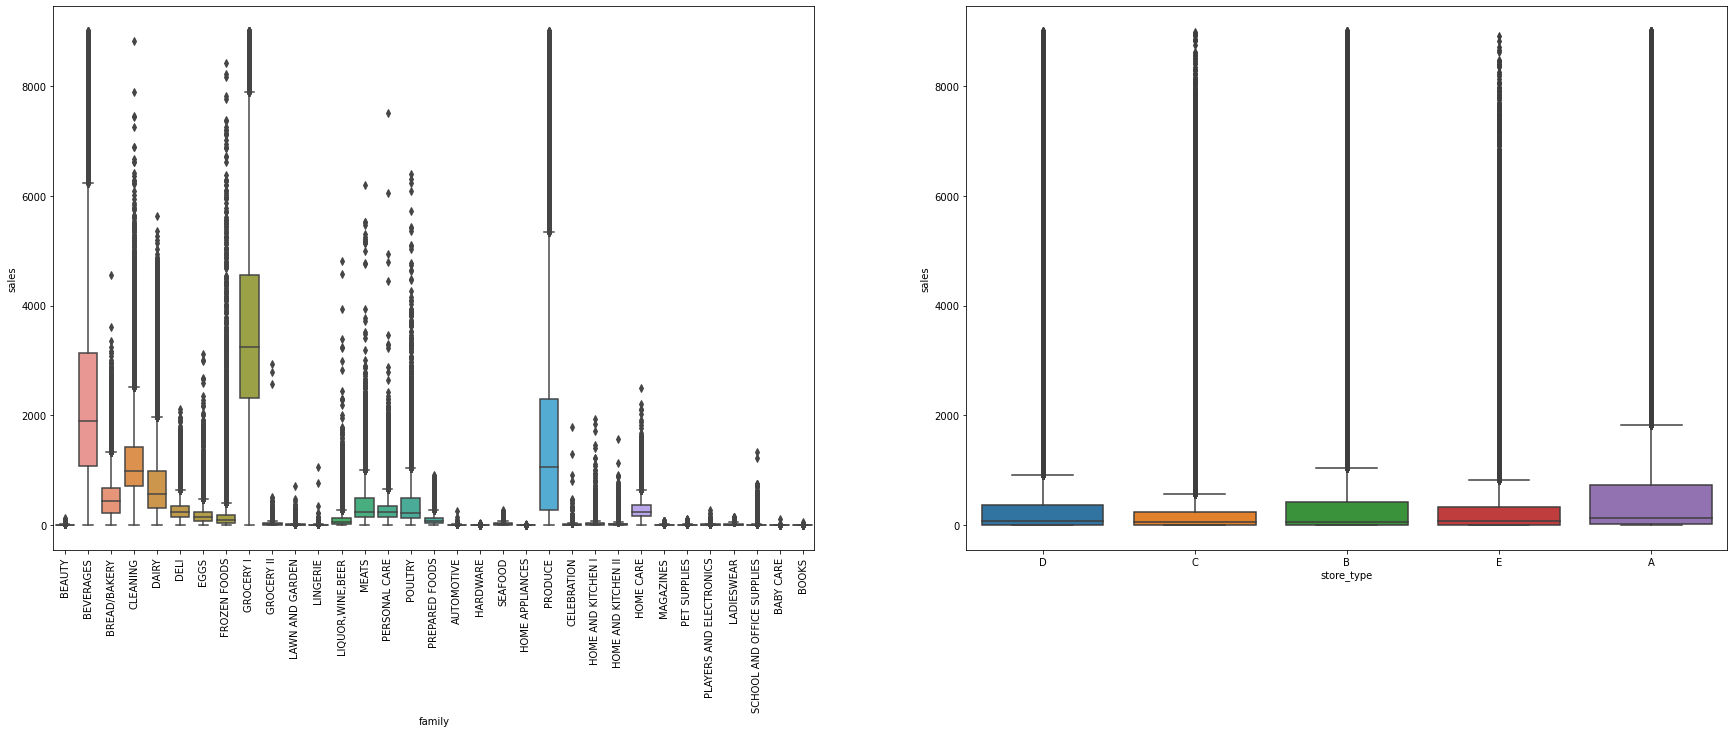

In [ ]:
a = df1[(df1['sales'] > 0)&(df1['sales'] <= 9000)]

# family
plt.subplot(1,2,1)
sns.boxplot(x='family', y='sales', data=a)
plt.xticks(rotation=90)

# story_type
plt.subplot(1,2,2)
sns.boxplot(x='store_type', y='sales', data=a);

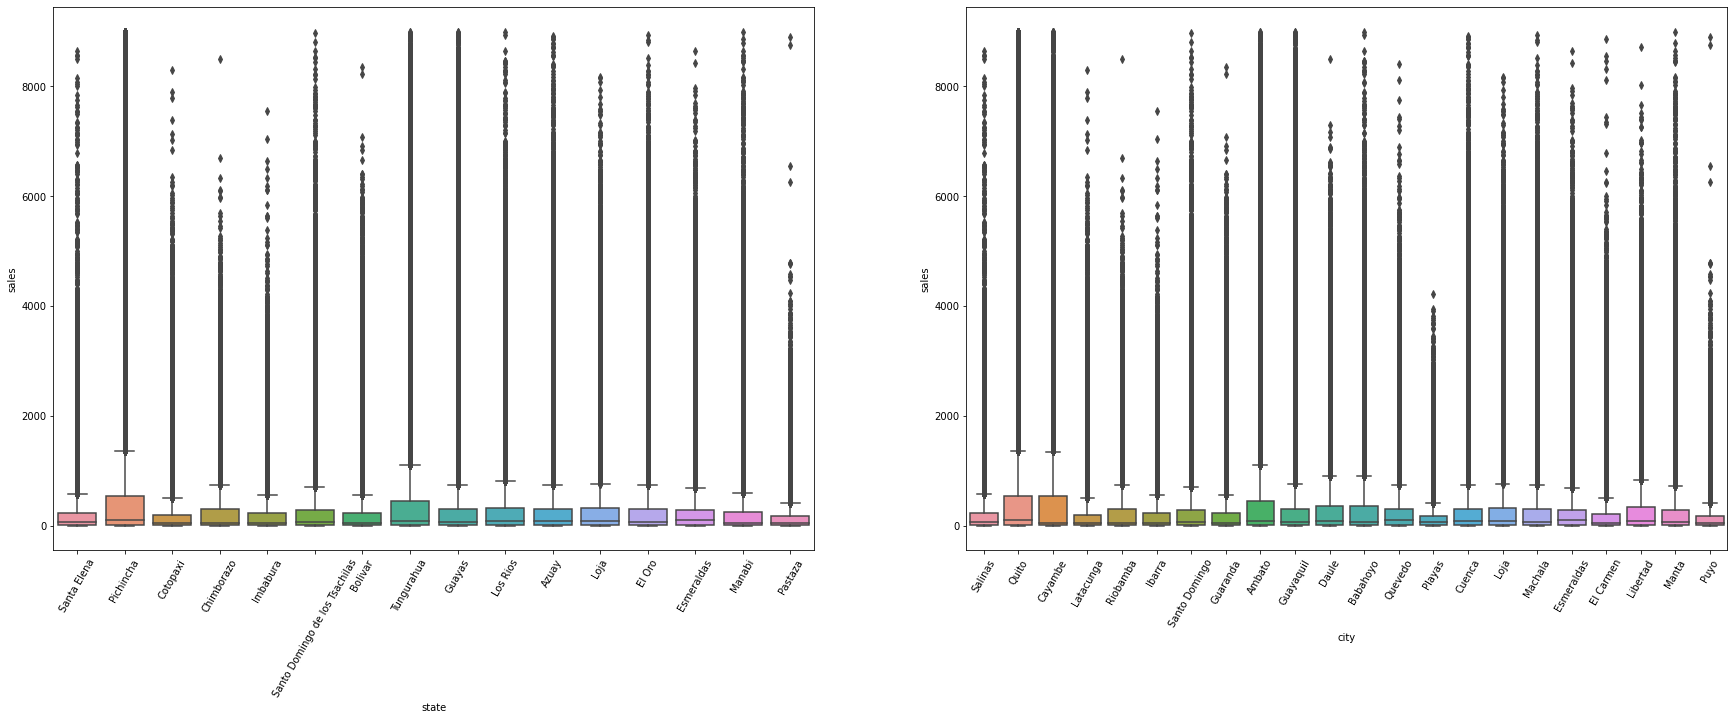

In [ ]:
# state
plt.subplot(1,2,1)
sns.boxplot(x='state', y='sales', data=a)
plt.xticks(rotation=60)

# city
plt.subplot(1,2,2)
sns.boxplot(x='city', y='sales', data=a)
plt.xticks(rotation=60);

In [ ]:
df1.to_csv('../data/processed/df1.csv',index=False)

# 2.0 Hypotheses Gathering

## 2.1. Hypotheses' mindmap

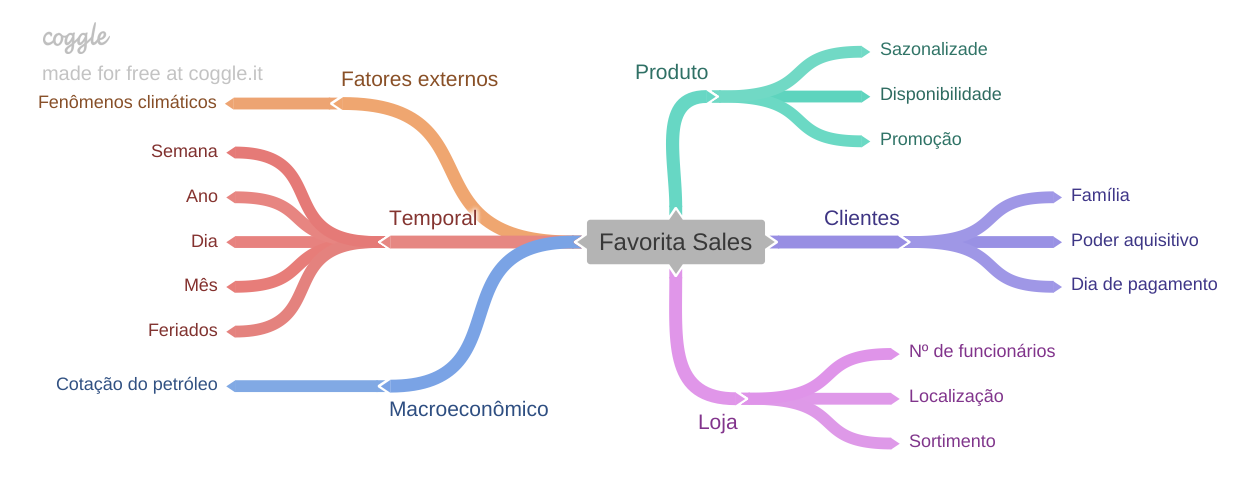

In [ ]:
Image('../reports/figures/favorita_sales.png')

## 2.2. Hypotheses' creation

- Fatores externos:
  - A ocorrência de fenomenos climáticos aumenta o número de vendas.
  - Os itens mais vendidos na ocorrência de fenômenos climáticos são FROZEN FOODS GROCERY.
  - Cidades atingidas por fenômenos climáticos apresentam aumento no número de vendas. **¹**
- Macroeconômico:
  - O preço do petróleo aumentou durante os anos, afetando negativamente o poder de compra da população e diminuindo o volume de vendas.
- Produto:
  - O volume de vendas da rede se concentra nos tipos FROZEN FOODS GROCERY.
  - O volume de vendas de produtos AUTOMOTIVE se concentra na região 
  metropolitana. **¹**
  - Famílias com maior número de produtos em promoção vendem acima da média do mês.
  - O pico de vendas de BEVERAGES é de sexta à domingo.
- Loja:
  - Lojas com maior sortimento vendem mais.
  - Cidades com mais lojas registram maiores vendas.
  - Lojas do tipo B faz mais promoções que a média.
  - O número de promoções por cidade é diretamente proporcional ao número de habitantes. **²**
- Clientes:
  - O dia de pagamento do setor público interfere no volume de vendas.
- Temporal:
  - Na semana, o maior volume de vendas se concentra de sexta à domingo.
  - Dias antes de feriados apresentam um pico nas vendas.
---
**¹** Necessário anexar dados de geolocalização.</br>
**²** Necessário anexar dados demográficos. 

## 2.3. Hypotheses' Final List

- H1. A ocorrência de fenomenos climáticos aumenta o número de vendas
- H2. Os itens mais vendidos na ocorrência de fenômenos climáticos são FROZEN FOODS GROCERY
- <s>Cidades atingidas por fenômenos climáticos apresentam aumento no número de vendas.</s>
- H3. O preço do petróleo aumentou durante os anos, afetando negativamente o poder de compra da população e diminuindo o volume de vendas
- H4. O volume de vendas da rede se concentra nos tipos FROZEN FOODS GROCERY
- <s>O volume de vendas de produtos AUTOMOTIVE se concentra na região metropolitana</s>
- H5. Famílias com maior número de produtos em promoção vendem acima da média do mês
- H6. O pico de vendas de BEVERAGES é de sexta à domingo
- H7. Lojas com maior sortimento vendem mais
- H8. Cidades com mais lojas registram maiores vendas
- H9. Lojas do tipo B faz mais promoções que a média
- <s>O número de promoções por cidade é diretamente proporcional ao número de habitantes</s>
- H10. O dia de pagamento do setor público interfere no volume de vendas
- H11. Na semana, o maior volume de vendas se concentra de sexta à domingo
- H12. Dias antes de feriados apresentam um pico nas vendas

# 3.0 Feature Engineering

In [ ]:
# copy into a new dataset to keep the progress made until now
df3 = df1.copy()
#df3 = pd.read_csv('../data/processed/df1.csv',index=False)

In [ ]:
# setando colunas de datas
df3['day']          = df3['date'].dt.day
df3['day_of_year']  = df3['date'].dt.dayofyear
df3['month']        = df3['date'].dt.month
df3['year']         = df3['date'].dt.year
df3['week_of_year'] = df3['date'].dt.weekofyear
df3['day_of_week']  = df3['date'].dt.dayofweek #The day of the week with Monday=0, Sunday=6.

# dataset de feriados
# separando feriados entre regionais e nacionais, evitando duplicar registros no momento do merge
aux_holiday         = df_holiday_raw.loc[df_holiday_raw['transferred'] == False,['date', 'type', 'description', 'locale_name']]
mundial_futbol_days = aux_holiday[aux_holiday['description'].str.contains('Mundial de futbol Brasil')].drop(['type','locale_name'], axis=1).rename(columns={'description':'worldcup'}).reset_index(drop=True)
earthquake_days     = aux_holiday[aux_holiday['description'].str.contains('Terremoto')].drop(['type','locale_name'], axis=1).rename(columns={'description':'earthquake'}).reset_index(drop=True)
aux_holiday         = aux_holiday.drop_duplicates(subset=['date','locale_name'], keep='last')
df_holiday          = aux_holiday[(~aux_holiday['locale_name'].str.contains('Ecuador') & (~aux_holiday['description'].str.contains('Terremoto')))].rename(columns={'type': 'event','locale_name': 'city'}).reset_index(drop=True)
df_holiday_national = aux_holiday[(aux_holiday['locale_name'].str.contains('Ecuador')) & (~aux_holiday['description'].str.contains('Terremoto')) ].rename(columns={'type': 'event'}).reset_index(drop=True)

# unindo feriados ao df principal
df3['date'] = df3['date'].astype('string')
df3 = pd.merge(df3, df_holiday, how='left', on=['date','city'])
df3 = pd.merge(df3, df_holiday_national, how='left', on='date')
df3 = pd.merge(df3, earthquake_days, how='left', on='date')
df3 = pd.merge(df3, mundial_futbol_days, how='left', on='date')

df3 = df3.rename(columns={
    'event_x': 'holiday_event',
    'description_x': 'holiday_name',
    'event_y': 'national_holiday_event',
    'description_y': 'national_holiday_name'
})

# tratamento das features
# se houve terremoto
df3['earthquake'] = df3['earthquake'].apply( lambda x: 0 if pd.isna(x) else 1 )

# se houve partida de copa do mundo
df3['worldcup'] = df3['worldcup'].apply( lambda x: 0 if pd.isna(x) else 1 )

# se era feriado nacional ou regional
df3['holiday_type'] = df3[['holiday_event','national_holiday_event']].apply(lambda x: 'usual_day' if (pd.isna(x['national_holiday_event'])) & (pd.isna(x['holiday_event'])) else
                                                                                      'national'   if (~pd.isna(x['national_holiday_event'])) & (pd.isna(x['holiday_event'])) else 'regional',axis=1)

# o nome do feriado
df3['holiday_name'] = df3[['holiday_name','national_holiday_name']].apply(lambda x: 'no_holiday' if (pd.isna(x['national_holiday_name'])) & (pd.isna(x['holiday_name'])) else
                                                                      x['national_holiday_name'] if (~pd.isna(x['national_holiday_name'])) & (pd.isna(x['holiday_name'])) else x['holiday_name'],axis=1)

# qual o evento relacionado aquele dia (dia normal, feriado, feriado transferido, feriadao, compensacao)
df3['day_event'] = df3[['holiday_event','national_holiday_event']].apply(lambda x: 'usual_day' if (pd.isna(x['national_holiday_event'])) & (pd.isna(x['holiday_event'])) else
                                                                    x['national_holiday_event'] if (~pd.isna(x['national_holiday_event'])) & (pd.isna(x['holiday_event'])) else x['holiday_event'],axis=1)

df3['is_promo'] = df3['onpromotion'].apply(lambda x: 1 if x != 0 else 0)

df3['date'] = pd.to_datetime(df3['date'])

In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 3000887
Data columns (total 28 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date                    datetime64[ns]
 1   store_nbr               int64         
 2   family                  object        
 3   sales                   float64       
 4   onpromotion             int64         
 5   city                    object        
 6   state                   object        
 7   store_type              object        
 8   store_cluster           int64         
 9   dcoilwtico              float64       
 10  transactions            float64       
 11  year_week               object        
 12  day                     int64         
 13  day_of_year             int64         
 14  month                   int64         
 15  year                    int64         
 16  week_of_year            int64         
 17  day_of_week             int64         
 18  ho

In [ ]:
df3.to_csv('../data/processed/df3.csv',index=False)

# 4.0. Variables filtering

In [ ]:
# copy into a new dataset to keep the progress made until now
df4 = df3.copy()
#df4 = pd.read_csv('../data/processed/df3.csv',index=False)

## 4.1. Rows filtering

In [ ]:
df4 = df4[df4['sales']>0].reset_index(drop=True)

In [ ]:
df4.describe()

,store_nbr,sales,onpromotion,store_cluster,dcoilwtico,transactions,day,day_of_year,month,year,week_of_year,day_of_week,earthquake,worldcup,is_promo
count,2061758.000,2061758.000,2061758.000,2061758.000,2061758.000,2061758.000,2061758.000,2061758.000,2061758.000,2061758.000,2061758.000,2061758.000,2061758.000,2061758.000,2061758.000
mean,27.045,520.742,3.788,8.578,63.541,2.891,15.660,176.561,6.310,2015.081,25.623,2.998,0.022,0.007,0.297
std,15.820,1297.187,14.587,4.698,24.567,72.946,8.784,103.568,3.392,1.318,14.829,2.001,0.148,0.085,0.457
min,1.000,0.122,0.000,1.000,26.190,0.000,1.000,1.000,1.000,2013.000,1.000,0.000,0.000,0.000,0.000
25%,13.000,9.000,0.000,4.000,45.598,0.000,8.000,87.000,3.000,2014.000,13.000,1.000,0.000,0.000,0.000
50%,27.000,78.463,0.000,9.000,50.974,0.000,16.000,174.000,6.000,2015.000,25.000,3.000,0.000,0.000,0.000
75%,41.000,388.000,1.000,13.000,93.340,0.000,23.000,264.000,9.000,2016.000,38.000,5.000,0.000,0.000,1.000
max,54.000,124717.000,741.000,17.000,110.620,1964.905,31.000,366.000,12.000,2017.000,53.000,6.000,1.000,1.000,1.000


In [ ]:
# check number of lines of sales during earthquake and worldcup
a = df4.loc[df4['earthquake']==1,'earthquake'].count()
print('Terremoto: {} / {} = {:.2f}'.format(a, df4.shape[0], a/df4.shape[0]*100))
b = df4.loc[df4['worldcup']==1,'worldcup'].count()
print('Mundial: {} / {} = {:.2f}'.format(b, df4.shape[0], b/df4.shape[0]*100))

Terremoto: 45911 / 2061758 = 2.23
Mundial: 15083 / 2061758 = 0.73


## 4.2. Columns selection

In [ ]:
df4 = df4.drop(['holiday_event','national_holiday_event','national_holiday_name',
                'locale_name', 'holiday_name'], axis=1)

In [ ]:
df4.to_csv('../data/processed/df4.csv',index=False)

# 5.0. Exploratory Data Analysis

In [ ]:
# copy into a new dataset to keep the progress made until now
df5 = df4.copy()
#df5 = pd.read_csv('../data/processed/df4.csv',index=False)

## 5.1. Univariate analysis

### 5.1.1. Response Variable

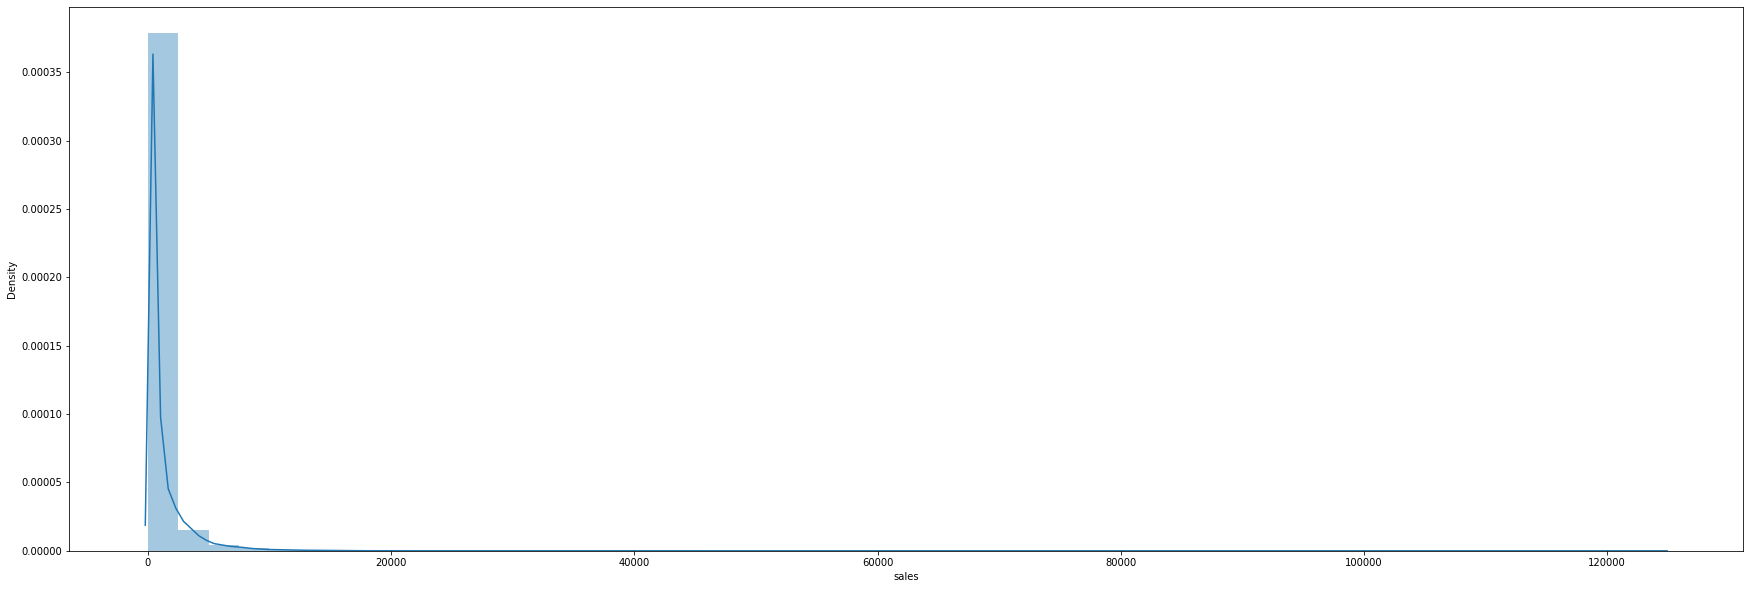

In [ ]:
# response variable distribution
sns.distplot(df5['sales']);

### 5.1.2. Numerical Variables

In [ ]:
num_attributes_eng = df5.select_dtypes(include=['int64','float64','UInt32'])

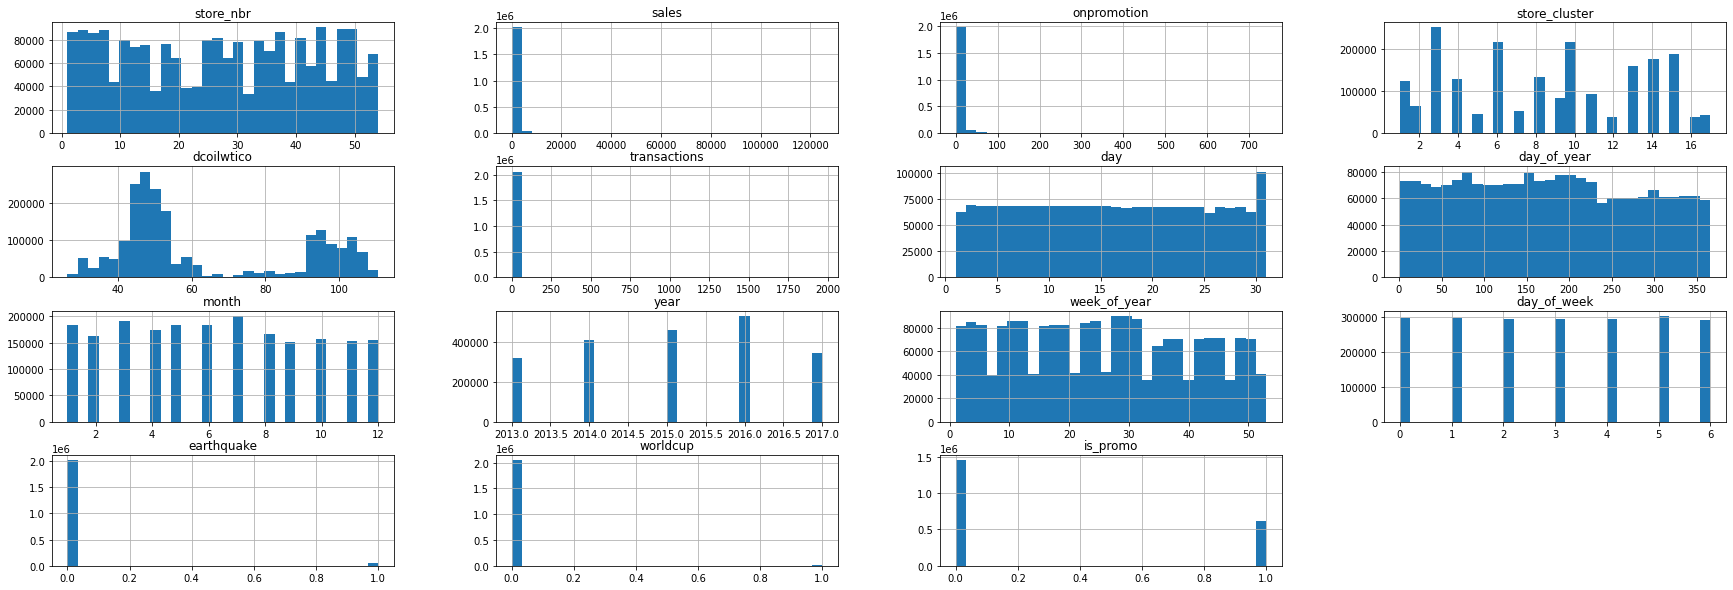

In [ ]:
num_attributes_eng.hist(bins=30);

In [ ]:
# Central Tendency - average/mean, median
_mean = pd.DataFrame(num_attributes_eng.apply(np.mean)).T
_median = pd.DataFrame(num_attributes_eng.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
_min = pd.DataFrame(num_attributes_eng.apply(min)).T
_max = pd.DataFrame(num_attributes_eng.apply(max)).T
_std = pd.DataFrame(num_attributes_eng.apply(np.std)).T
_range = pd.DataFrame(num_attributes_eng.apply(lambda x: x.max() - x.min())).T
_skew = pd.DataFrame(num_attributes_eng.apply(lambda x: x.skew())).T
_kurtosis = pd.DataFrame(num_attributes_eng.apply(lambda x: x.kurtosis())).T

ds_num_eng = pd.concat( [ _min, _max, _range, _mean, _median, _std, _skew, _kurtosis] ).T.reset_index()
ds_num_eng.columns = ['attribute','min','max','range','mean','median','std','skew','kurtosis']
ds_num_eng

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,store_nbr,1.000,54.000,53.000,27.045,27.000,15.820,-0.015,-1.270
1,sales,0.122,124717.000,124716.878,520.742,78.463,1297.187,6.197,113.236
2,onpromotion,0.000,741.000,741.000,3.788,0.000,14.587,9.308,168.638
3,store_cluster,1.000,17.000,16.000,8.578,9.000,4.698,0.016,-1.277
4,dcoilwtico,26.190,110.620,84.430,63.541,50.974,24.567,0.625,-1.258
5,transactions,0.000,1964.905,1964.905,2.891,0.000,72.946,25.310,641.361
6,day,1.000,31.000,30.000,15.660,16.000,8.784,0.026,-1.191
7,day_of_year,1.000,366.000,365.000,176.561,174.000,103.568,0.089,-1.140
8,month,1.000,12.000,11.000,6.310,6.000,3.392,0.077,-1.150
9,year,2013.000,2017.000,4.000,2015.081,2015.000,1.318,-0.121,-1.135


In [ ]:
df5[['earthquake','sales']].groupby('earthquake').mean().reset_index()

,earthquake,sales
0,0,519.040
1,1,595.489


In [ ]:
df5[['worldcup','sales']].groupby('worldcup').mean().reset_index()

,worldcup,sales
0,0,520.790
1,1,514.351


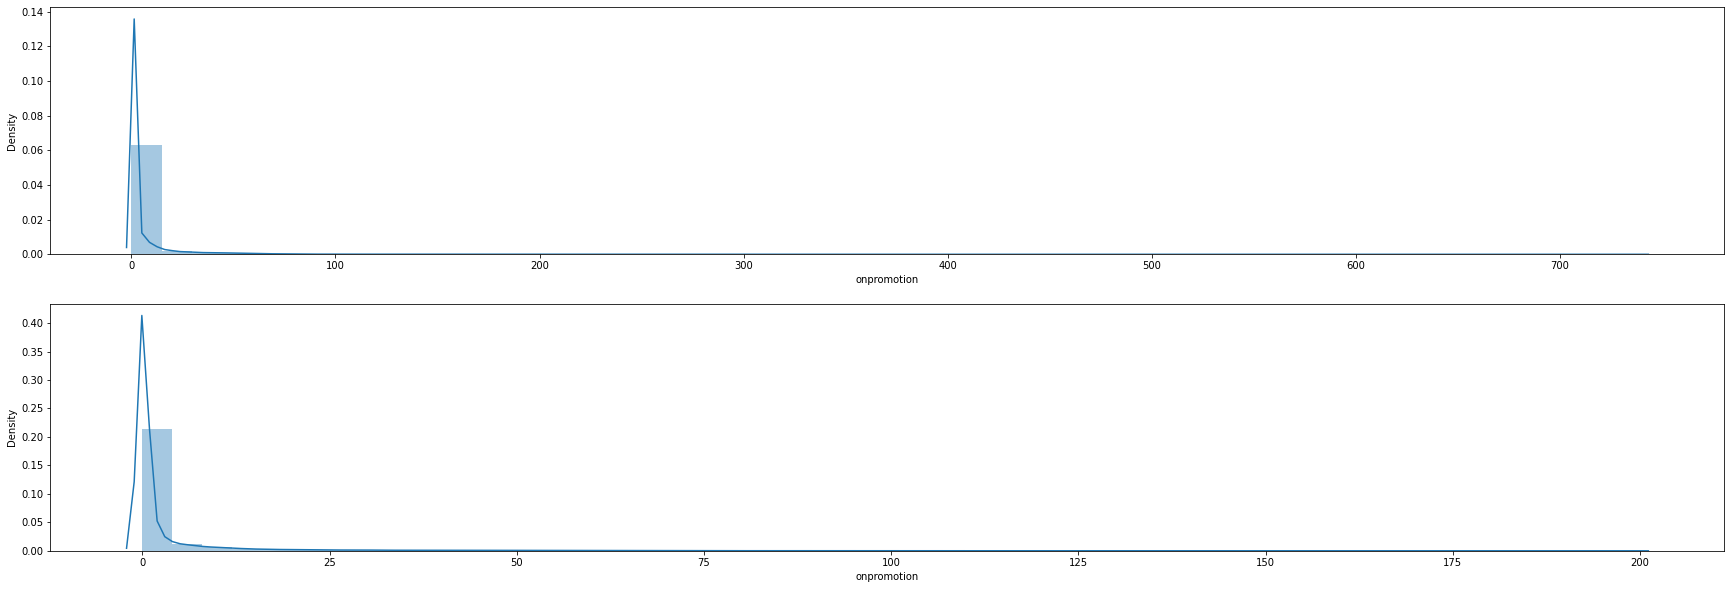

In [ ]:
# onpromotion distribution
plt.subplot(2,1,1)
sns.distplot(df5['onpromotion'])
plt.subplot(2,1,2)
a = df5[df5['onpromotion']<200]
sns.distplot(a['onpromotion']);

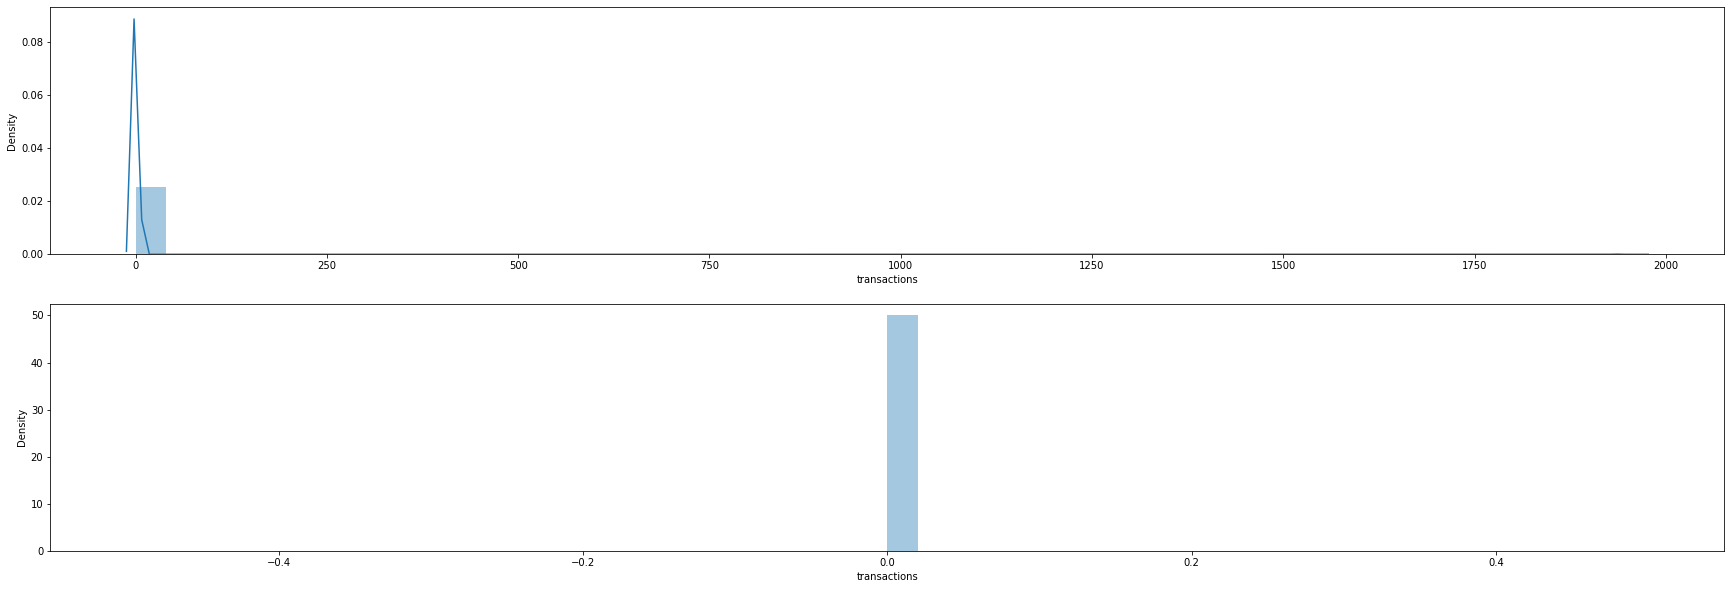

In [ ]:
# transactions distribution
plt.subplot(2,1,1)
sns.distplot(df5['transactions'])
plt.subplot(2,1,2)
a = df5[df5['transactions']<200]
sns.distplot(a['transactions']);

### 5.1.3. Categorical Variables

In [ ]:
cat_attributes_eng = df5.select_dtypes(exclude=['int64','float64','UInt32','datetime64[ns]'])
cat_attributes_eng.head()

,family,city,state,store_type,year_week,holiday_type,day_event
0,BEAUTY,Salinas,Santa Elena,D,2013-00,national,Holiday
1,BEVERAGES,Salinas,Santa Elena,D,2013-00,national,Holiday
2,BREAD/BAKERY,Salinas,Santa Elena,D,2013-00,national,Holiday
3,CLEANING,Salinas,Santa Elena,D,2013-00,national,Holiday
4,DAIRY,Salinas,Santa Elena,D,2013-00,national,Holiday


Family

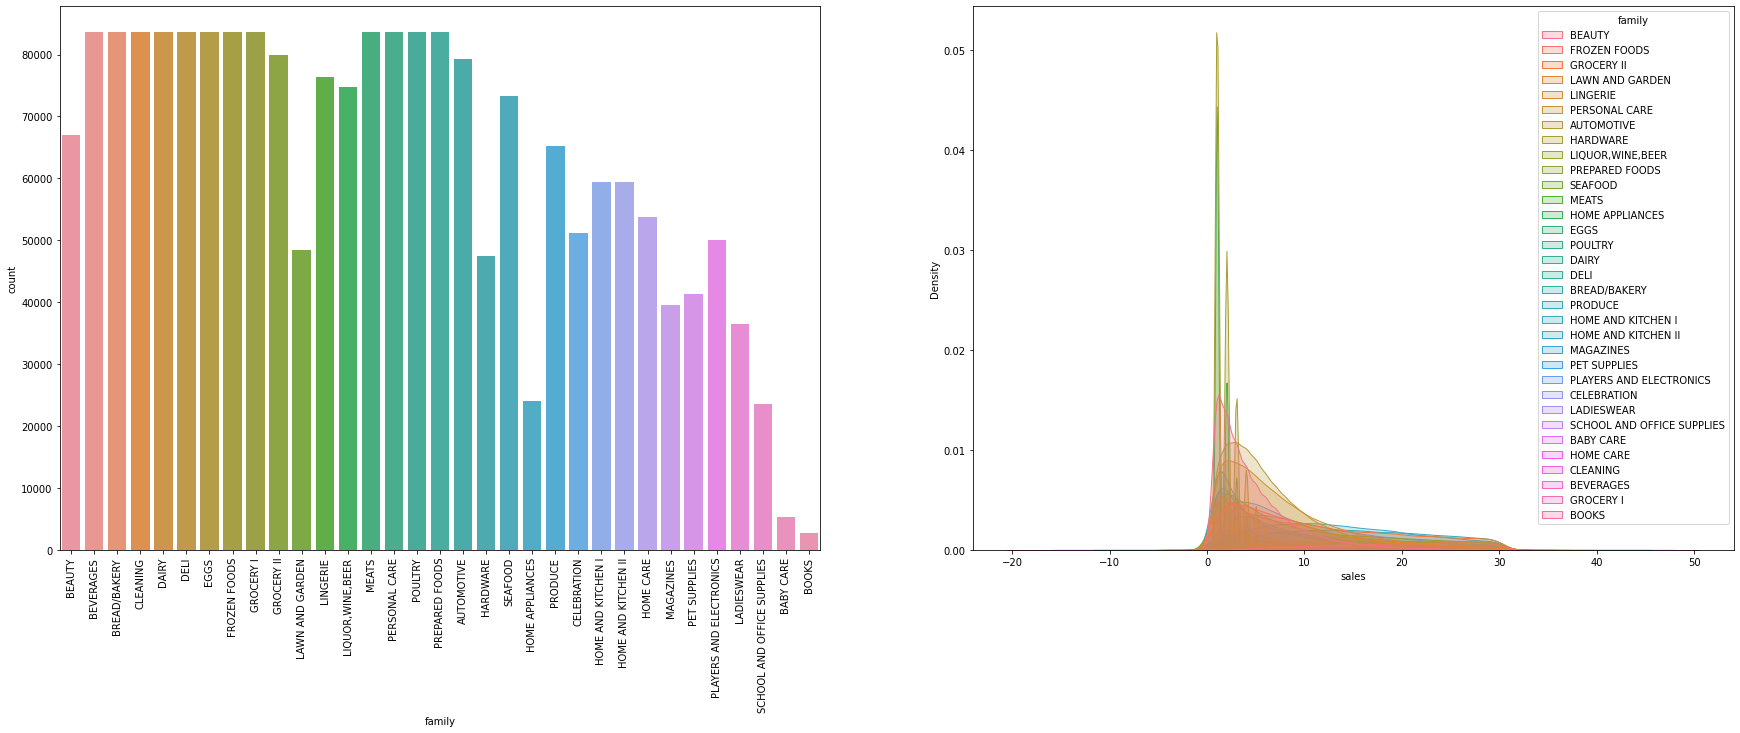

In [ ]:
# family
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
sns.countplot(df5['family'])
plt.xticks(rotation=90);

plt.subplot(1,2,2)
sns.kdeplot(data=df5[df5['sales']<=30], x="sales", hue="family", shade=True);

City

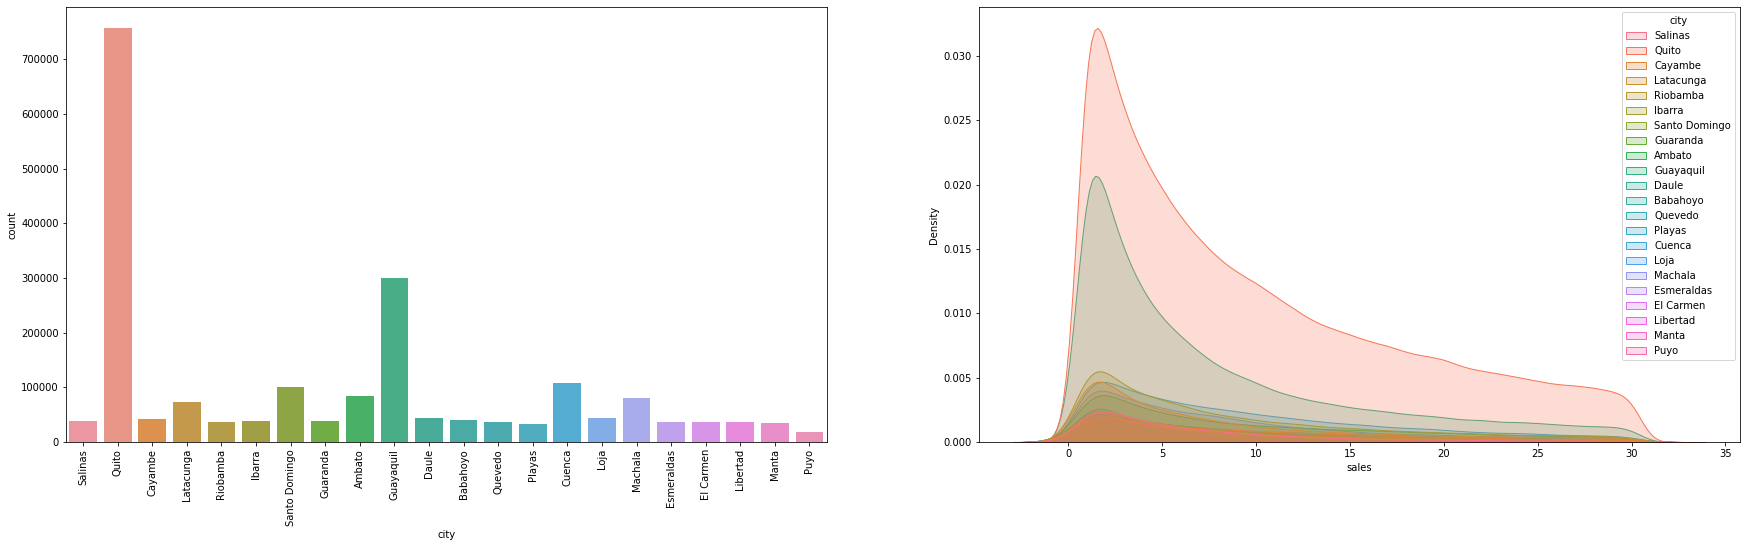

In [ ]:
# city
plt.figure(figsize=(30,8))
plt.subplot(1,2,1)
sns.countplot(df5['city'])
plt.xticks(rotation=90);

plt.subplot(1,2,2)
sns.kdeplot(data=df5[df5['sales']<=30], x="sales", hue="city", shade=True);

State

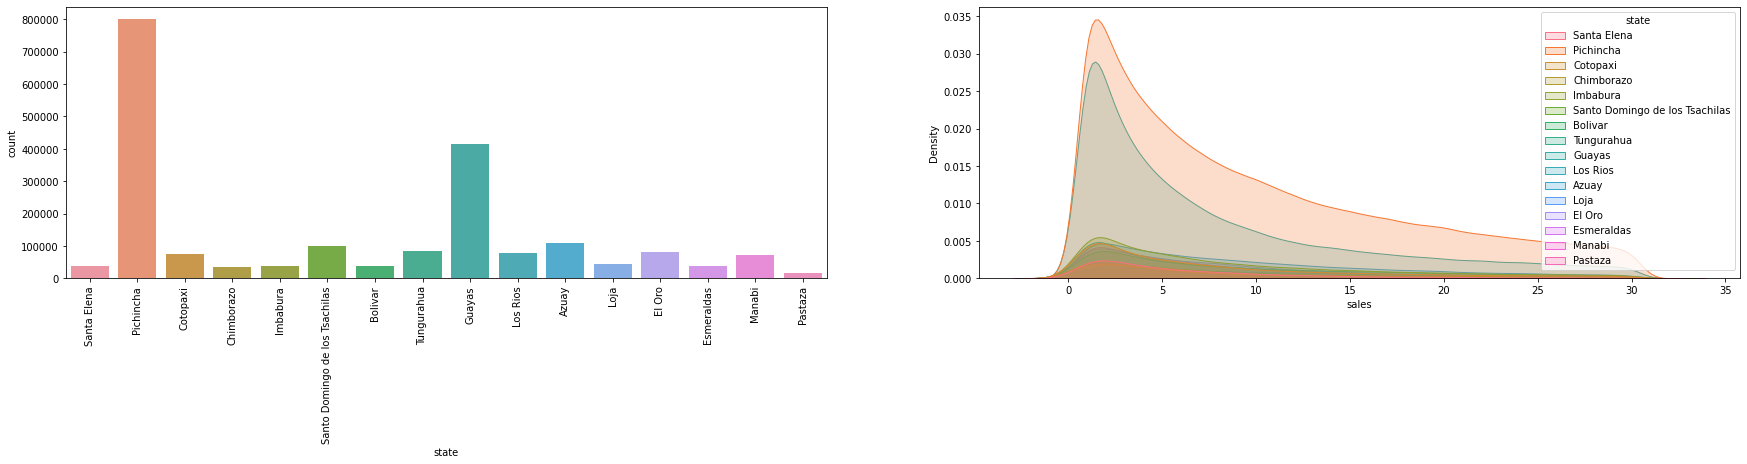

In [ ]:
# state
plt.figure(figsize=(30,5))
plt.subplot(1,2,1)
sns.countplot(df5['state'])
plt.xticks(rotation=90);

plt.subplot(1,2,2)
sns.kdeplot(data=df5[df5['sales']<=30], x="sales", hue="state", shade=True);

Store type

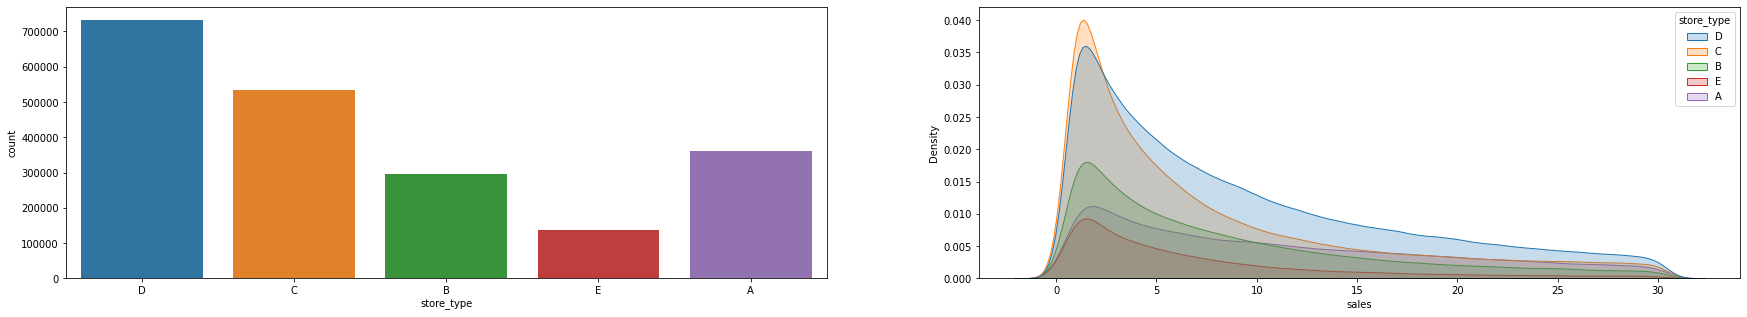

In [ ]:
# store_type
plt.figure(figsize=(30,5))
plt.subplot(1,2,1)
sns.countplot(df5['store_type'])

plt.subplot(1,2,2)
sns.kdeplot(data=df5[df5['sales']<=30], x="sales", hue="store_type", shade=True);

Holiday Type

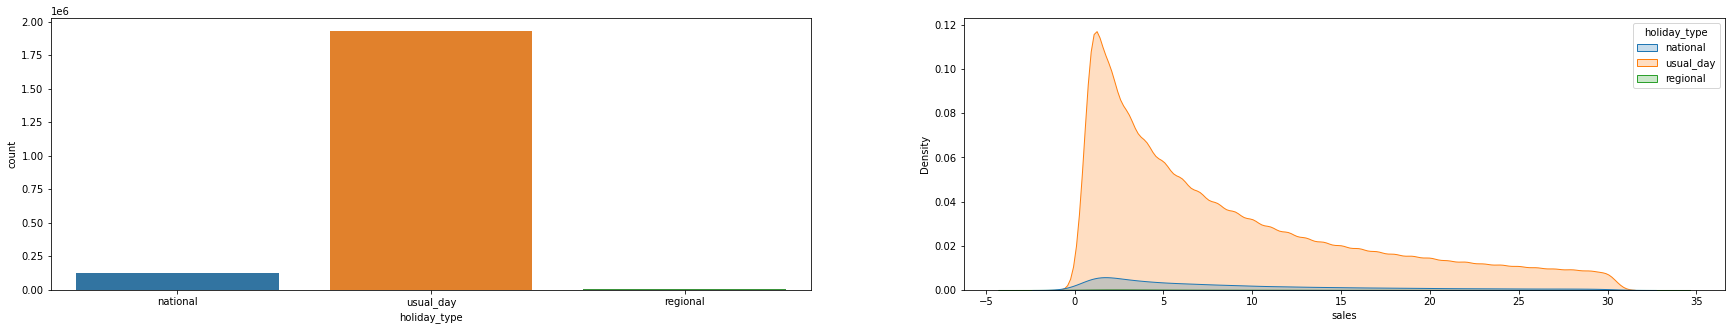

In [ ]:
# holiday_type
plt.figure(figsize=(30,5))
plt.subplot(1,2,1)
sns.countplot(df5['holiday_type'])

plt.subplot(1,2,2)
sns.kdeplot(data=df5[(df5['sales']<=30) & (df5['holiday_type']!='no_holiday')], x="sales", hue="holiday_type", shade=True);

Day event

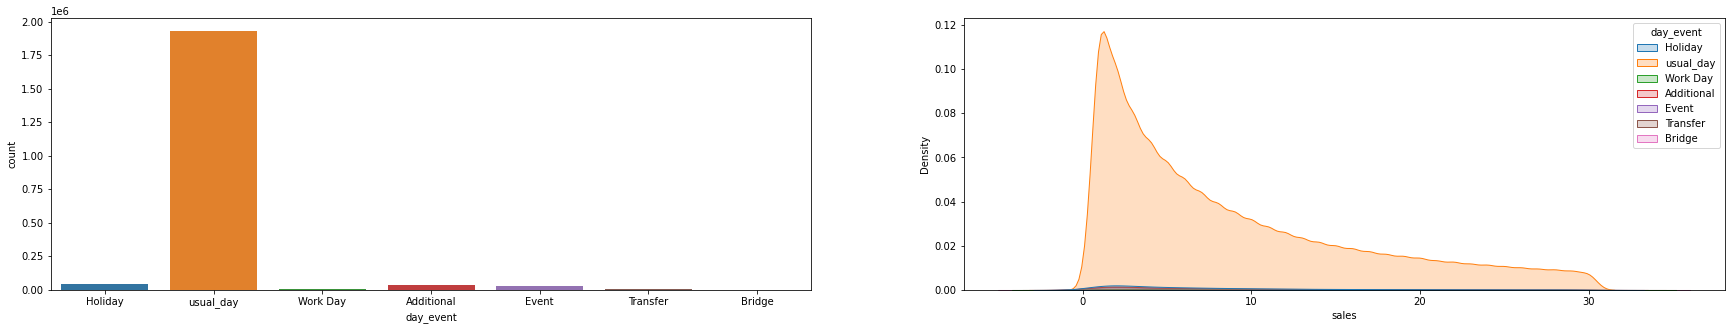

In [ ]:
# day_event
plt.figure(figsize=(30,5))
plt.subplot(1,2,1)
sns.countplot(df5['day_event'])

plt.subplot(1,2,2)
sns.kdeplot(data=df5[(df5['sales']<=30) & (df5['day_event']!='no_holiday')], x="sales", hue="day_event", shade=True);

## 5.2. Bivariate analysis

### Análise de outliers

#### Definindo outliers genericamente

In [ ]:
q1, q3 = df5['sales'].quantile(q=[0.25, 0.75])
outlier = 3 * (q3 - q1)
ol = df5[df5['sales']>outlier]
nol = df5[df5['sales']<=outlier]

#### Store number

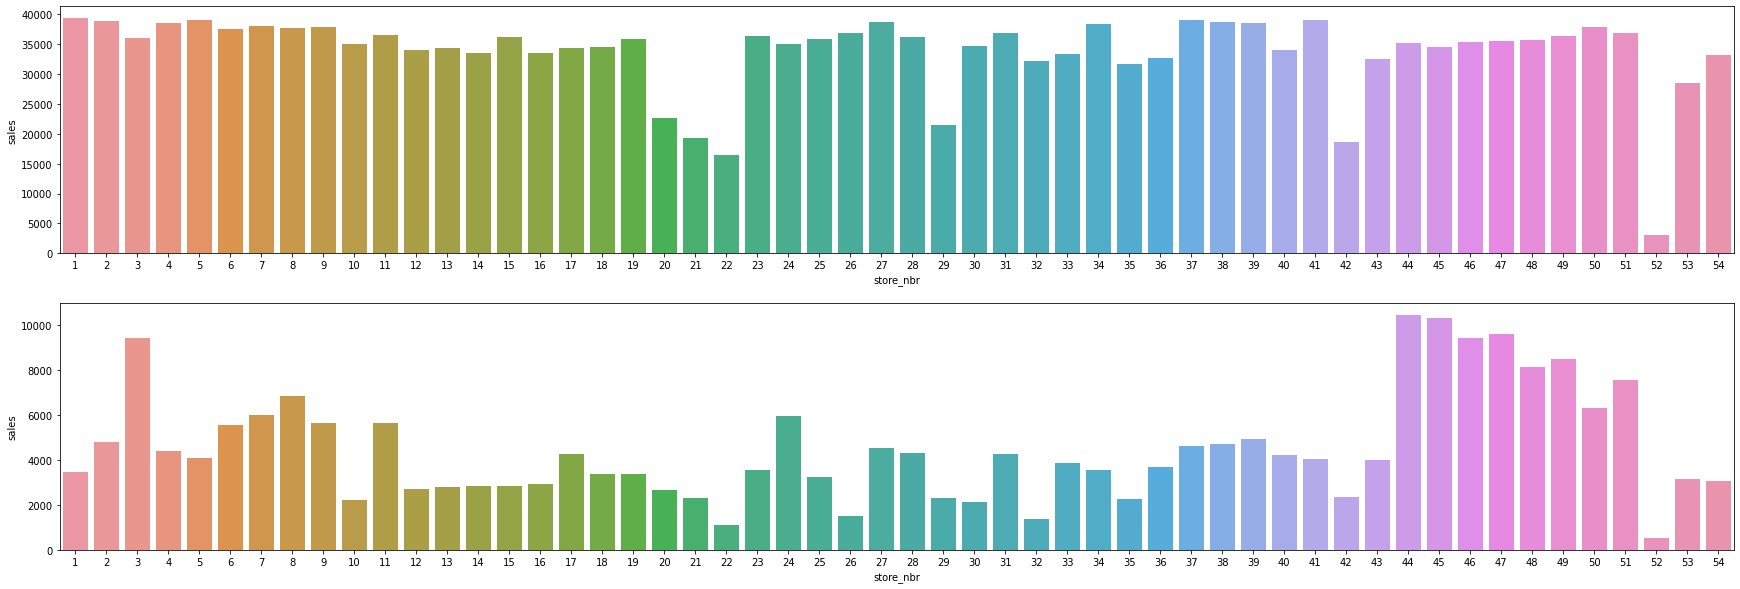

In [ ]:
h1 = nol[['store_nbr','sales']].groupby('store_nbr').count().reset_index(drop=False)
h1o = ol[['store_nbr','sales']].groupby('store_nbr').count().reset_index(drop=False)
plt.subplot(2,1,1)
sns.barplot(data=h1, x='store_nbr', y='sales')
plt.subplot(2,1,2)
sns.barplot(data=h1o, x='store_nbr', y='sales');

#### Day

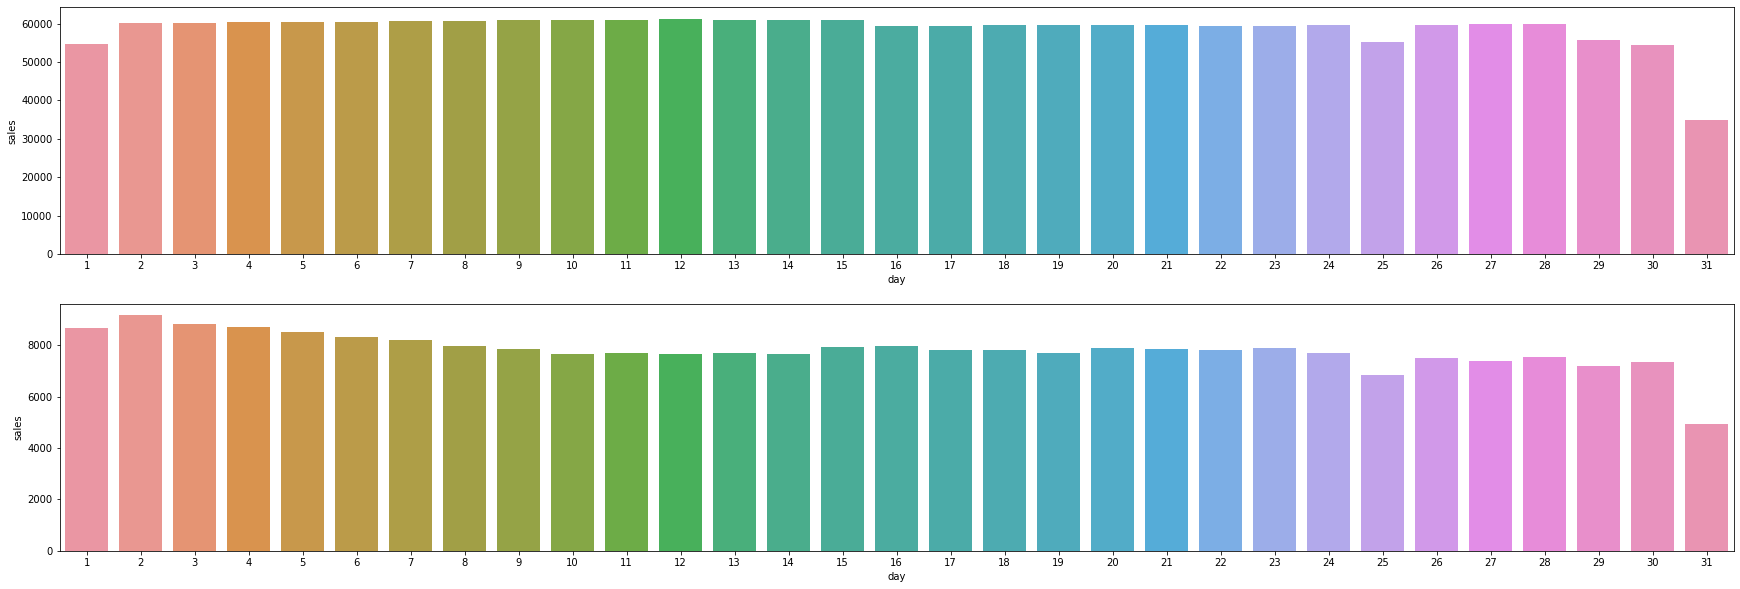

In [ ]:
h2 = nol[['day','sales']].groupby('day').count().reset_index(drop=False)
h2o = ol[['day','sales']].groupby('day').count().reset_index(drop=False)
plt.subplot(2,1,1)
sns.barplot(data=h2, x='day', y='sales')
plt.subplot(2,1,2)
sns.barplot(data=h2o, x='day', y='sales');

#### Month

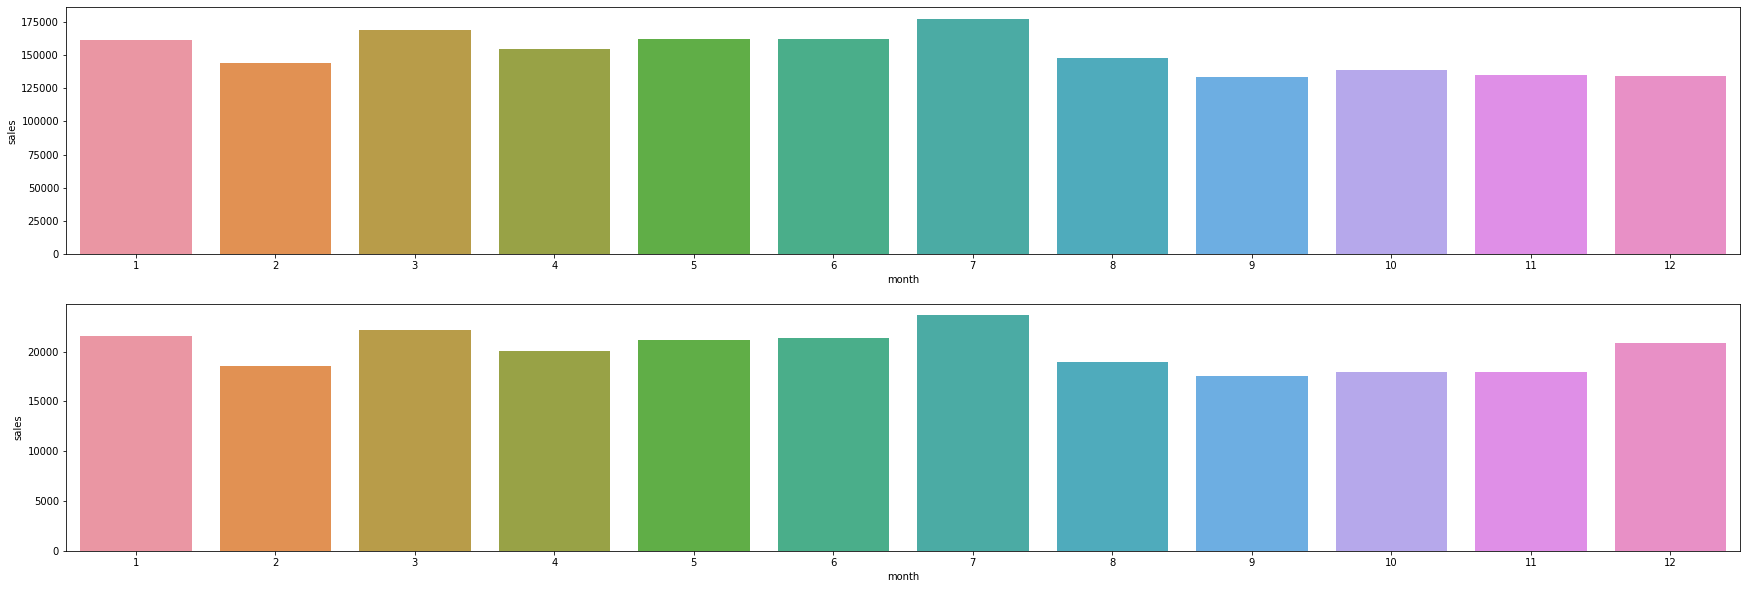

In [ ]:
h3 = nol[['month','sales']].groupby('month').count().reset_index(drop=False)
h3o = ol[['month','sales']].groupby('month').count().reset_index(drop=False)
plt.subplot(2,1,1)
sns.barplot(data=h3, x='month', y='sales')
plt.subplot(2,1,2)
sns.barplot(data=h3o, x='month', y='sales');

#### Day of week

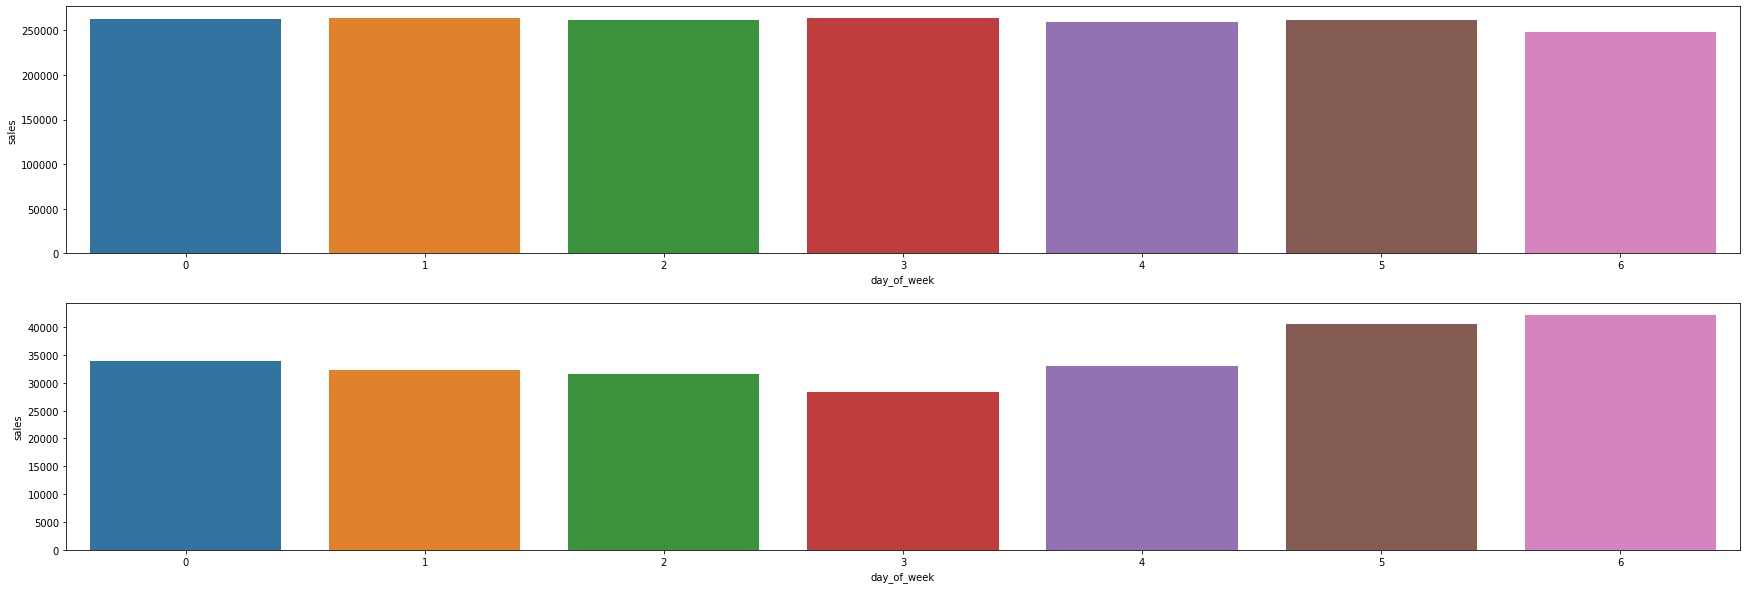

In [ ]:
h4 = nol[['day_of_week','sales']].groupby('day_of_week').count().reset_index(drop=False)
h4o = ol[['day_of_week','sales']].groupby('day_of_week').count().reset_index(drop=False)
plt.subplot(2,1,1)
sns.barplot(data=h4, x='day_of_week', y='sales')
plt.subplot(2,1,2)
sns.barplot(data=h4o, x='day_of_week', y='sales');

#### Week of year

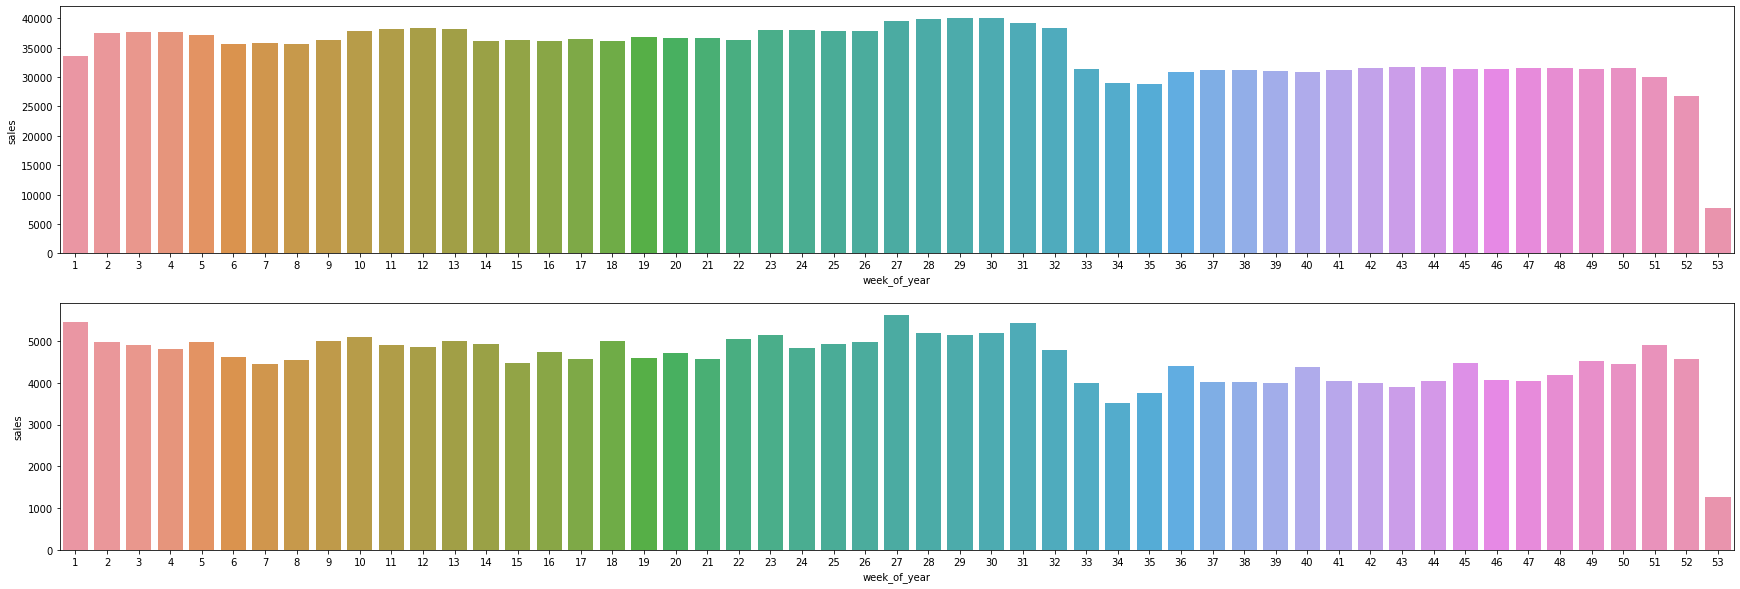

In [ ]:
h5 = nol[['week_of_year','sales']].groupby('week_of_year').count().reset_index(drop=False)
h5o = ol[['week_of_year','sales']].groupby('week_of_year').count().reset_index(drop=False)
plt.subplot(2,1,1)
sns.barplot(data=h5, x='week_of_year', y='sales')
plt.subplot(2,1,2)
sns.barplot(data=h5o, x='week_of_year', y='sales');

#### Worldcup

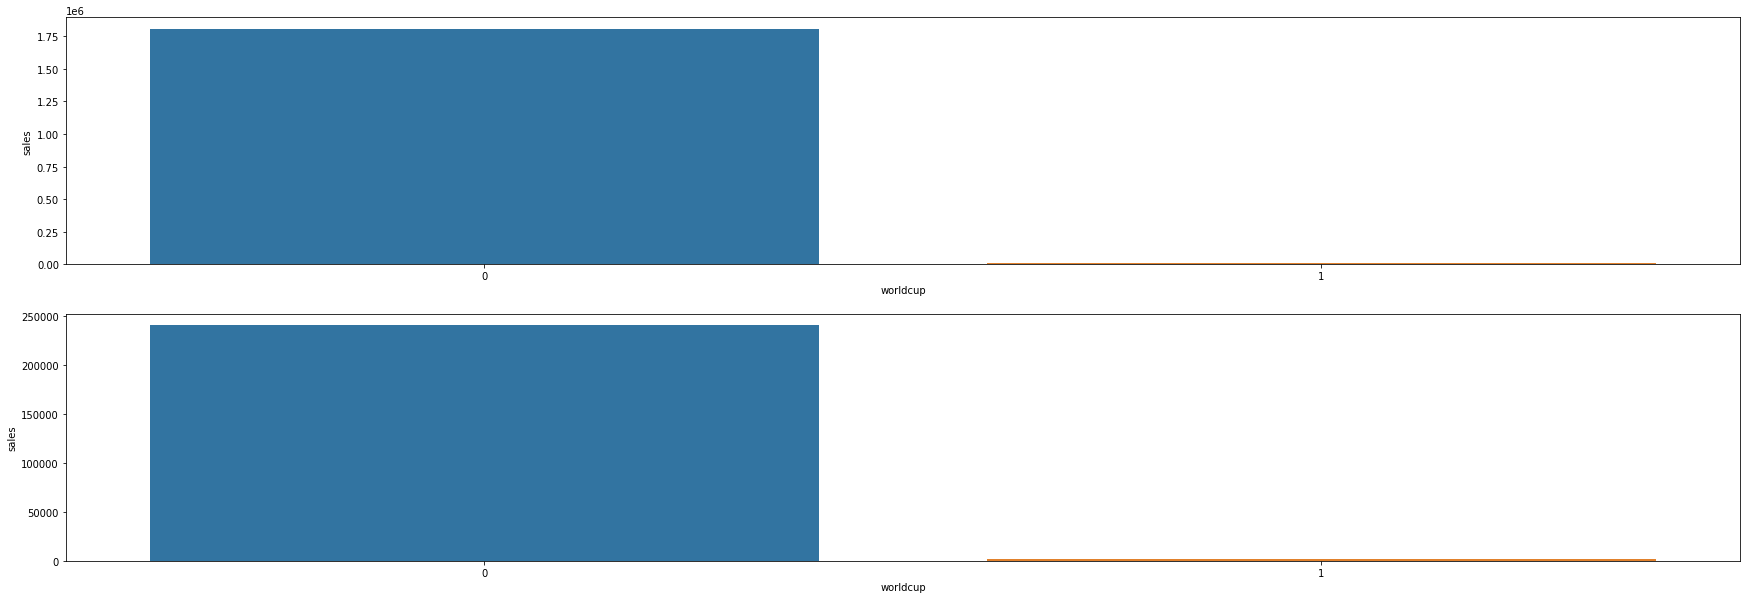

In [ ]:
h6 = nol[['worldcup','sales']].groupby('worldcup').count().reset_index(drop=False)
h6o = ol[['worldcup','sales']].groupby('worldcup').count().reset_index(drop=False)
plt.subplot(2,1,1)
sns.barplot(data=h6, x='worldcup', y='sales')
plt.subplot(2,1,2)
sns.barplot(data=h6o, x='worldcup', y='sales');

#### Earthquake

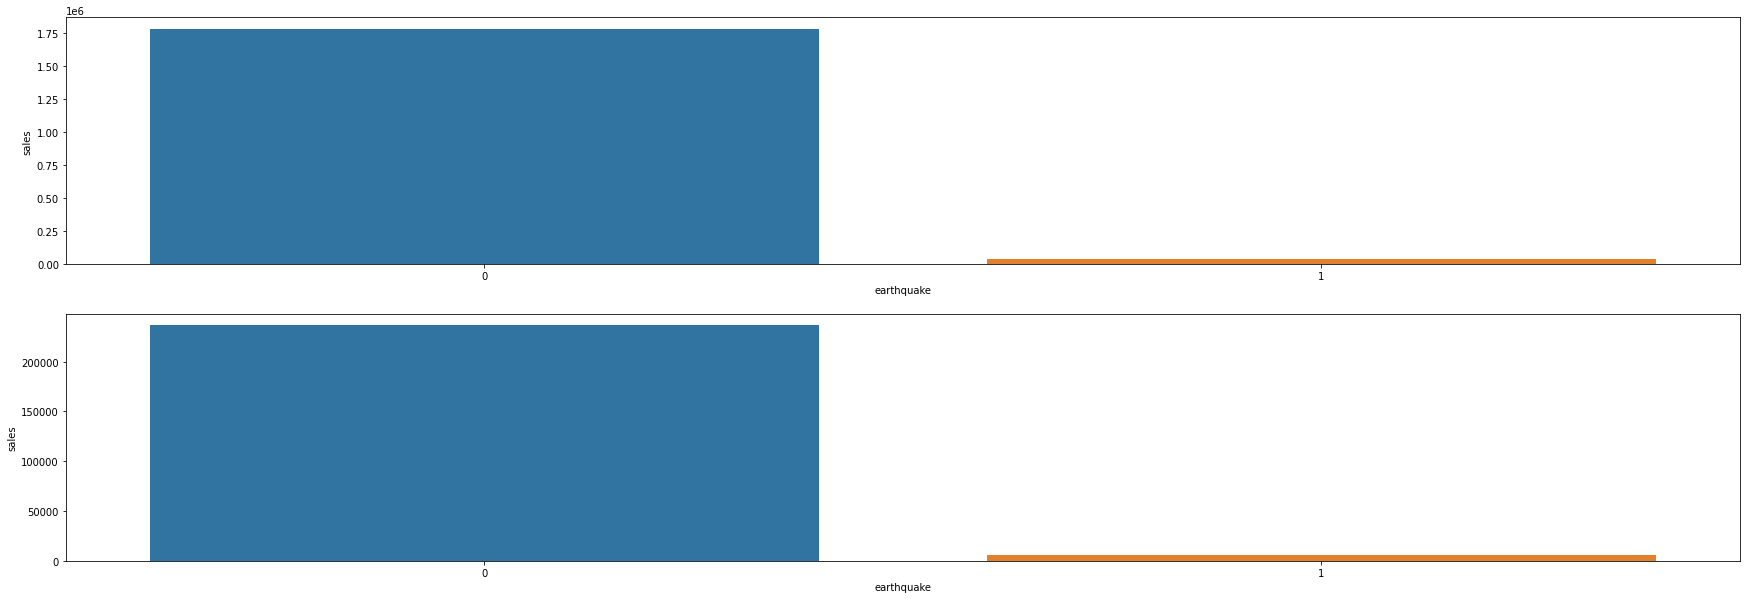

In [ ]:
h7 = nol[['earthquake','sales']].groupby('earthquake').count().reset_index(drop=False)
h7o = ol[['earthquake','sales']].groupby('earthquake').count().reset_index(drop=False)
plt.subplot(2,1,1)
sns.barplot(data=h7, x='earthquake', y='sales')
plt.subplot(2,1,2)
sns.barplot(data=h7o, x='earthquake', y='sales');

#### Holiday type

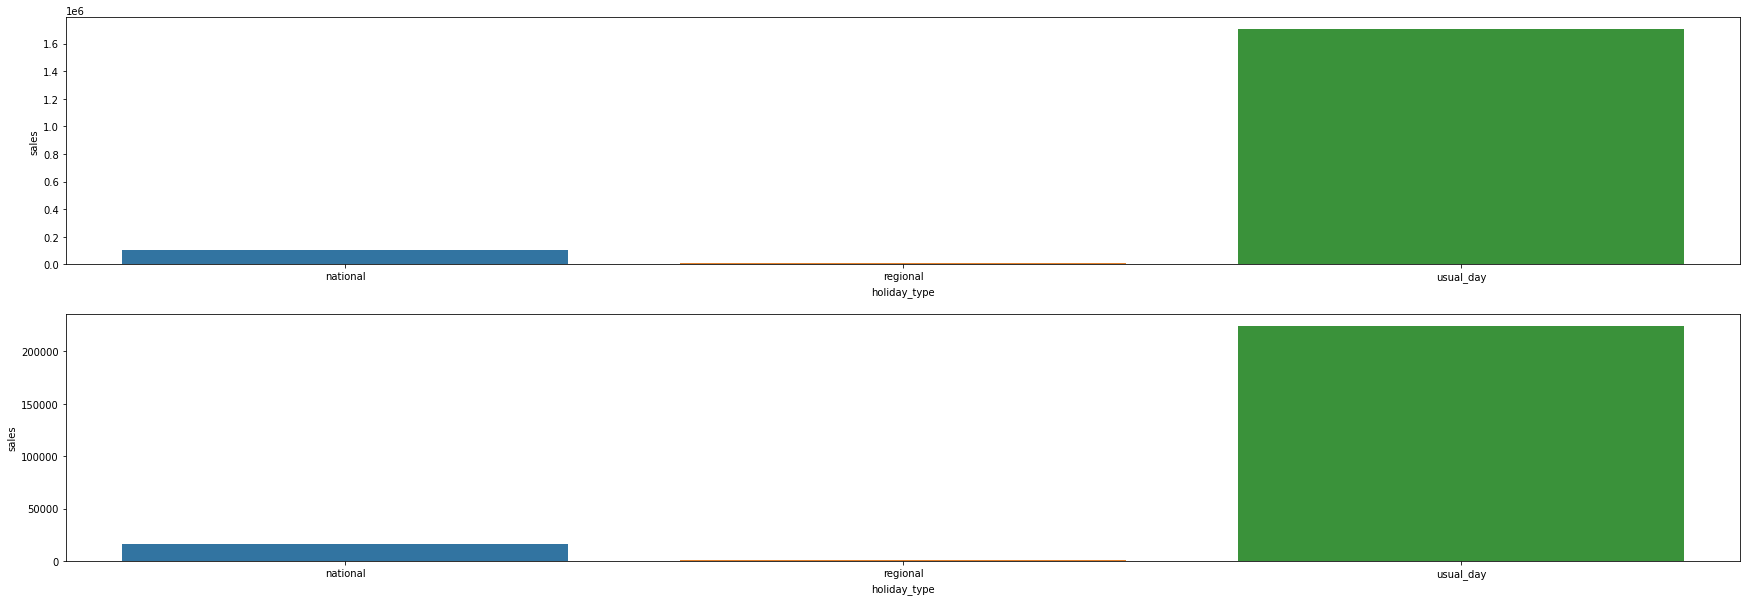

In [ ]:
h8 = nol[['holiday_type','sales']].groupby('holiday_type').count().reset_index(drop=False)
h8o = ol[['holiday_type','sales']].groupby('holiday_type').count().reset_index(drop=False)
plt.subplot(2,1,1)
sns.barplot(data=h8, x='holiday_type', y='sales')
plt.subplot(2,1,2)
sns.barplot(data=h8o, x='holiday_type', y='sales');

#### Day event

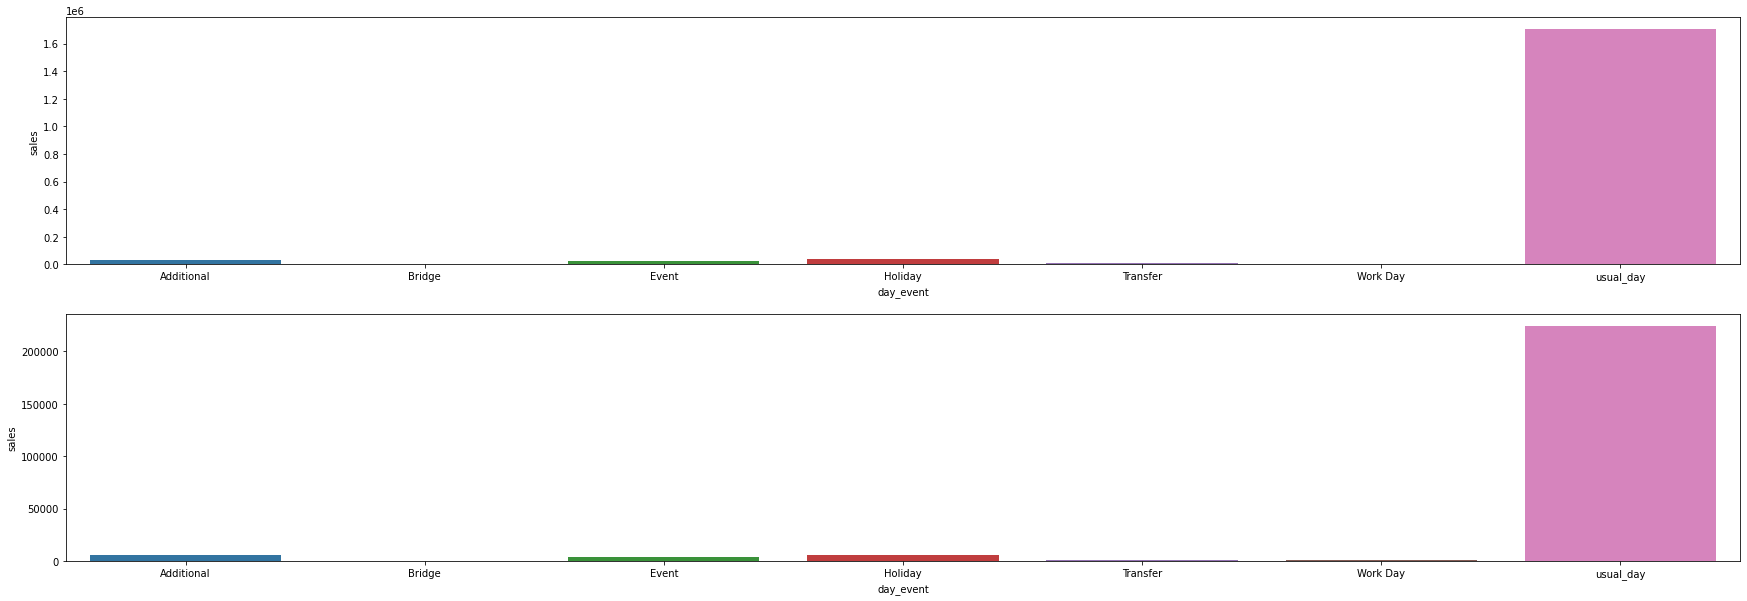

In [ ]:
h9 = nol[['day_event','sales']].groupby('day_event').count().reset_index(drop=False)
h9o = ol[['day_event','sales']].groupby('day_event').count().reset_index(drop=False)
plt.subplot(2,1,1)
sns.barplot(data=h9, x='day_event', y='sales')
plt.subplot(2,1,2)
sns.barplot(data=h9o, x='day_event', y='sales');

#### Family **

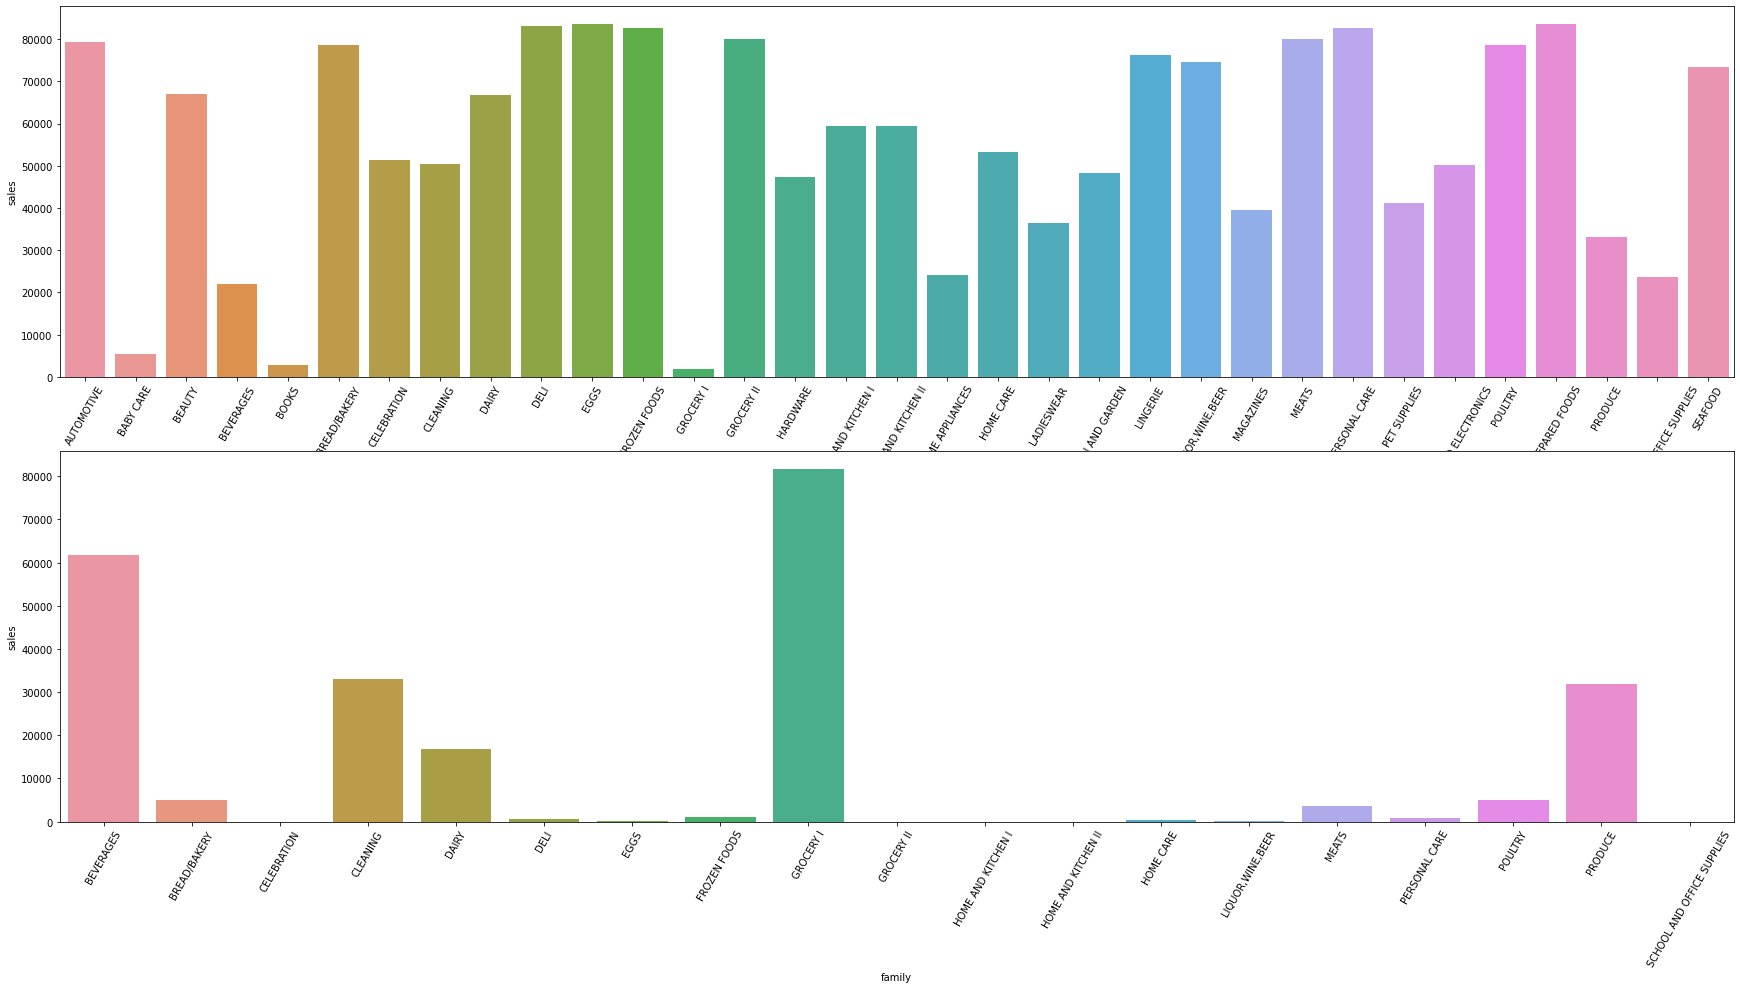

In [ ]:
plt.figure(figsize=(30,15))
h10 = nol[['family','sales']].groupby('family').count().reset_index(drop=False)
h10o = ol[['family','sales']].groupby('family').count().reset_index(drop=False)
plt.subplot(2,1,1)
sns.barplot(data=h10, x='family', y='sales')
plt.xticks(rotation=60)
plt.subplot(2,1,2)
sns.barplot(data=h10o, x='family', y='sales')
plt.xticks(rotation=60);

##### drill

In [ ]:
families = df5['family'].unique().tolist()
len(families)

33

In [ ]:
families

['BEAUTY',
 'BEVERAGES',
 'BREAD/BAKERY',
 'CLEANING',
 'DAIRY',
 'DELI',
 'EGGS',
 'FROZEN FOODS',
 'GROCERY I',
 'GROCERY II',
 'LAWN AND GARDEN',
 'LINGERIE',
 'LIQUOR,WINE,BEER',
 'MEATS',
 'PERSONAL CARE',
 'POULTRY',
 'PREPARED FOODS',
 'AUTOMOTIVE',
 'HARDWARE',
 'SEAFOOD',
 'HOME APPLIANCES',
 'PRODUCE',
 'CELEBRATION',
 'HOME AND KITCHEN I',
 'HOME AND KITCHEN II',
 'HOME CARE',
 'MAGAZINES',
 'PET SUPPLIES',
 'PLAYERS AND ELECTRONICS',
 'LADIESWEAR',
 'SCHOOL AND OFFICE SUPPLIES',
 'BABY CARE',
 'BOOKS']

vlines
- 04: terremoto em 2016
- 07: copa do mundo em 2014

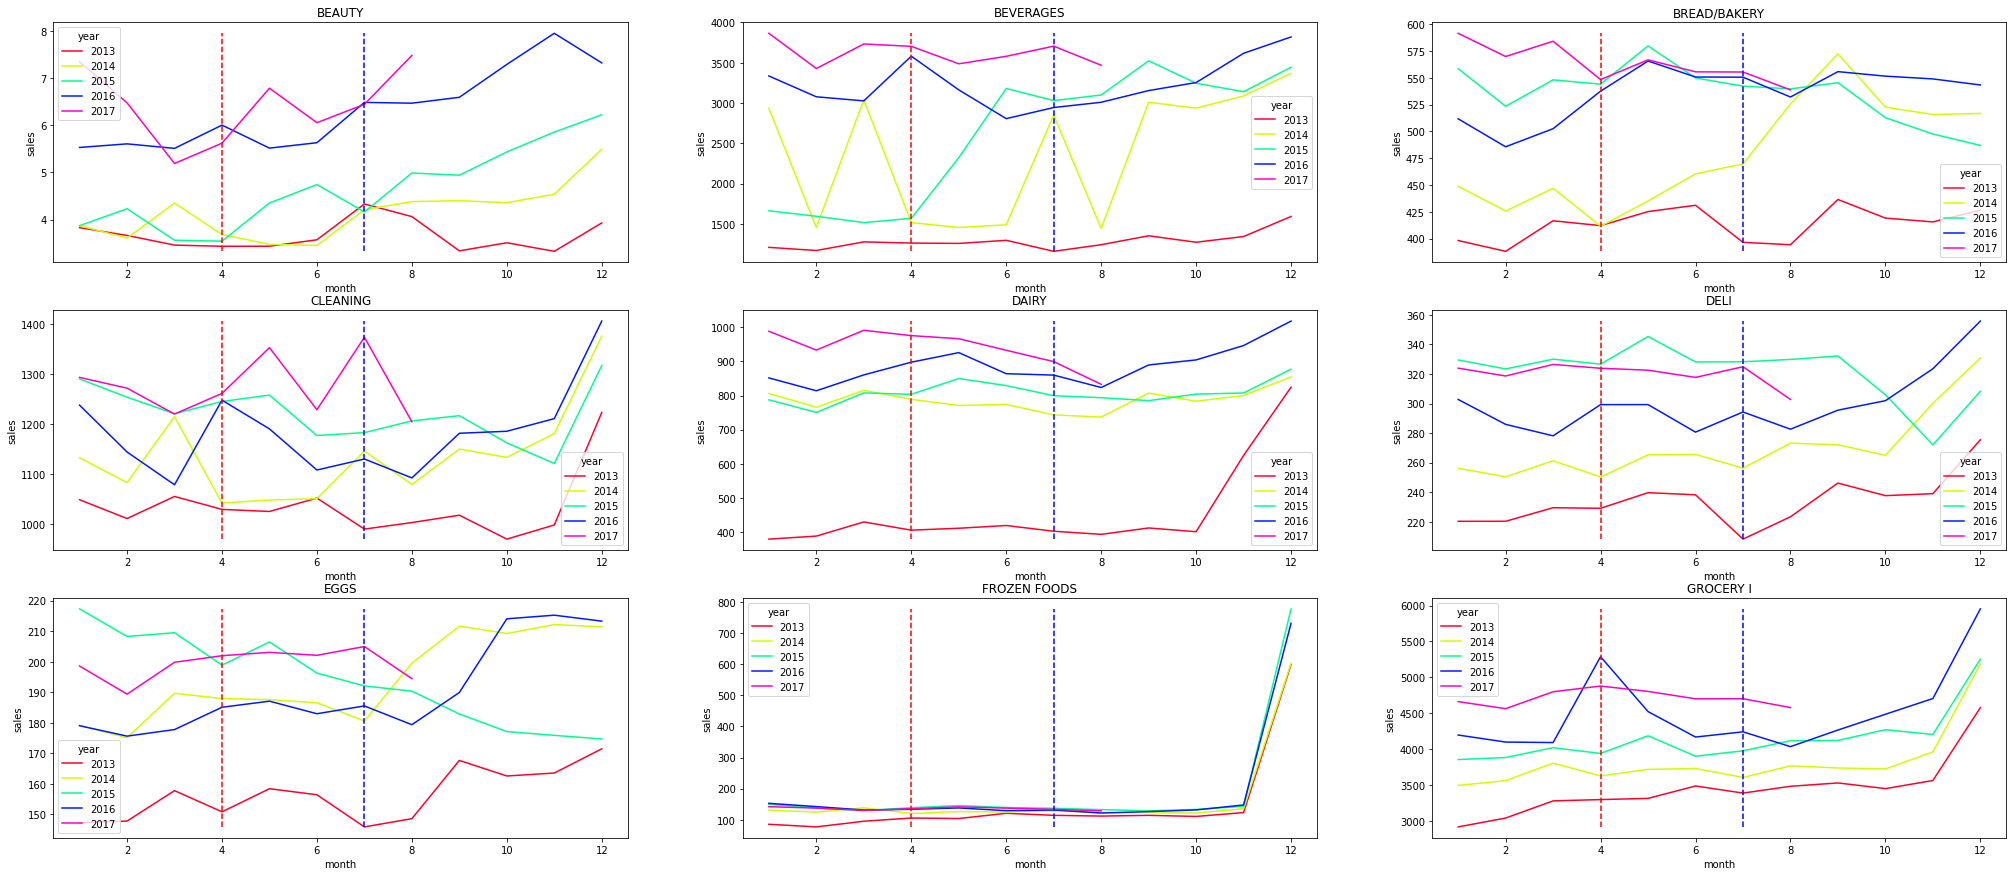

In [ ]:
plt.figure(figsize=(35,15))
f1 = df5.loc[(df5['family']=='BEAUTY')].groupby(['year','month']).mean().reset_index()
f2 = df5.loc[(df5['family']=='BEVERAGES')].groupby(['year','month']).mean().reset_index()
f3 = df5.loc[(df5['family']=='BREAD/BAKERY')].groupby(['year','month']).mean().reset_index()
f4 = df5.loc[(df5['family']=='CLEANING')].groupby(['year','month']).mean().reset_index()
f5 = df5.loc[(df5['family']=='DAIRY')].groupby(['year','month']).mean().reset_index()
f6 = df5.loc[(df5['family']=='DELI')].groupby(['year','month']).mean().reset_index()
f7 = df5.loc[(df5['family']=='EGGS')].groupby(['year','month']).mean().reset_index()
f8 = df5.loc[(df5['family']=='FROZEN FOODS')].groupby(['year','month']).mean().reset_index()
f9 = df5.loc[(df5['family']=='GROCERY I')].groupby(['year','month']).mean().reset_index()

plt.subplot(3,3,1)
plt.title('BEAUTY')
a = sns.lineplot(data=f1, x='month',y='sales', hue='year', palette='gist_rainbow')
a.vlines(4, f1['sales'].min(), f1['sales'].max(), linestyles='dashed', colors='red')
a.vlines(7, f1['sales'].min(), f1['sales'].max(), linestyles='dashed', colors='blue')

plt.subplot(3,3,2)
plt.title('BEVERAGES')
b = sns.lineplot(data=f2, x='month',y='sales', hue='year', palette='gist_rainbow')
b.vlines(4, f2['sales'].min(), f2['sales'].max(), linestyles='dashed', colors='red')
b.vlines(7, f2['sales'].min(), f2['sales'].max(), linestyles='dashed', colors='blue')

plt.subplot(3,3,3)
plt.title('BREAD/BAKERY')
c = sns.lineplot(data=f3, x='month',y='sales', hue='year', palette='gist_rainbow')
c.vlines(4, f3['sales'].min(), f3['sales'].max(), linestyles='dashed', colors='red')
c.vlines(7, f3['sales'].min(), f3['sales'].max(), linestyles='dashed', colors='blue')

plt.subplot(3,3,4)
plt.title('CLEANING')
d = sns.lineplot(data=f4, x='month',y='sales', hue='year', palette='gist_rainbow')
d.vlines(4, f4['sales'].min(), f4['sales'].max(), linestyles='dashed', colors='red')
d.vlines(7, f4['sales'].min(), f4['sales'].max(), linestyles='dashed', colors='blue')

plt.subplot(3,3,5)
plt.title('DAIRY')
e = sns.lineplot(data=f5, x='month',y='sales', hue='year', palette='gist_rainbow')
e.vlines(4, f5['sales'].min(), f5['sales'].max(), linestyles='dashed', colors='red')
e.vlines(7, f5['sales'].min(), f5['sales'].max(), linestyles='dashed', colors='blue')

plt.subplot(3,3,6)
plt.title('DELI')
f = sns.lineplot(data=f6, x='month',y='sales', hue='year', palette='gist_rainbow')
f.vlines(4, f6['sales'].min(), f6['sales'].max(), linestyles='dashed', colors='red')
f.vlines(7, f6['sales'].min(), f6['sales'].max(), linestyles='dashed', colors='blue')

plt.subplot(3,3,7)
plt.title('EGGS')
g = sns.lineplot(data=f7, x='month',y='sales', hue='year', palette='gist_rainbow')
g.vlines(4, f7['sales'].min(), f7['sales'].max(), linestyles='dashed', colors='red')
g.vlines(7, f7['sales'].min(), f7['sales'].max(), linestyles='dashed', colors='blue')

plt.subplot(3,3,8)
plt.title('FROZEN FOODS')
h = sns.lineplot(data=f8, x='month',y='sales', hue='year', palette='gist_rainbow')
h.vlines(4, f8['sales'].min(), f8['sales'].max(), linestyles='dashed', colors='red')
h.vlines(7, f8['sales'].min(), f8['sales'].max(), linestyles='dashed', colors='blue')

plt.subplot(3,3,9)
plt.title('GROCERY I')
i = sns.lineplot(data=f9, x='month',y='sales', hue='year', palette='gist_rainbow')
i.vlines(4, f9['sales'].min(), f9['sales'].max(), linestyles='dashed', colors='red')
i.vlines(7, f9['sales'].min(), f9['sales'].max(), linestyles='dashed', colors='blue');

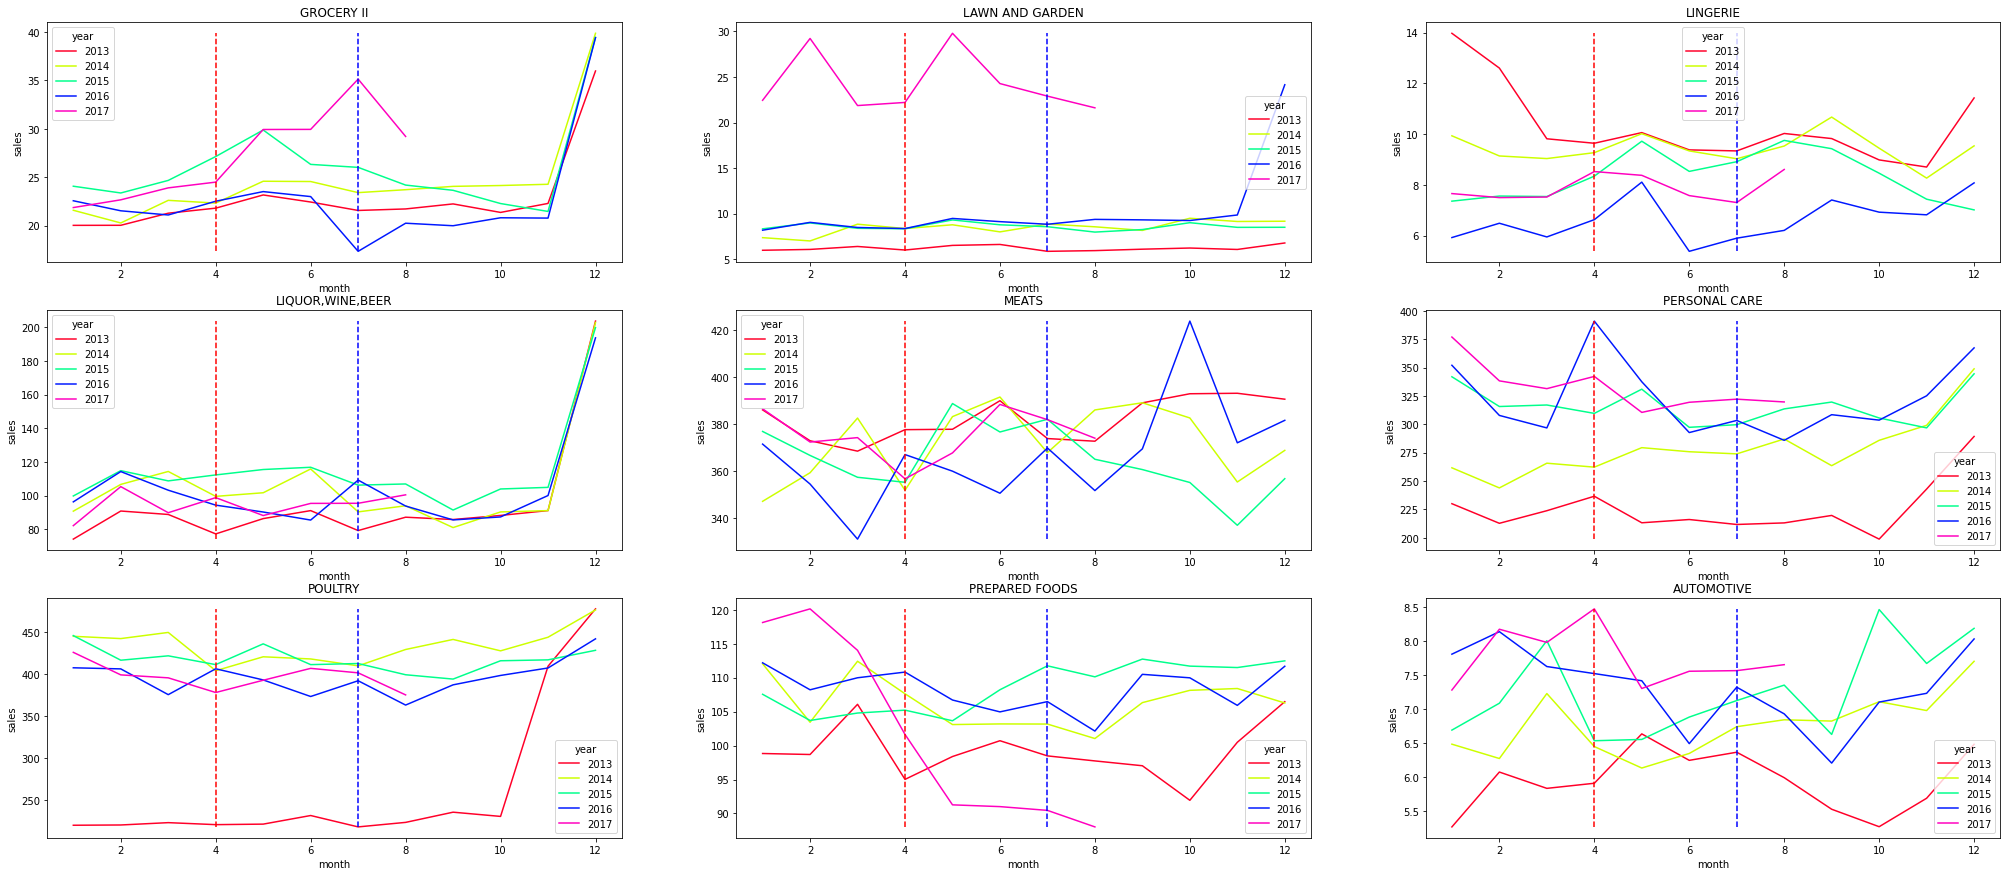

In [ ]:
plt.figure(figsize=(35,15))
f1 = df5.loc[(df5['family']=='GROCERY II')].groupby(['year','month']).mean().reset_index()
f2 = df5.loc[(df5['family']=='LAWN AND GARDEN')].groupby(['year','month']).mean().reset_index()
f3 = df5.loc[(df5['family']=='LINGERIE')].groupby(['year','month']).mean().reset_index()
f4 = df5.loc[(df5['family']=='LIQUOR,WINE,BEER')].groupby(['year','month']).mean().reset_index()
f5 = df5.loc[(df5['family']=='MEATS')].groupby(['year','month']).mean().reset_index()
f6 = df5.loc[(df5['family']=='PERSONAL CARE')].groupby(['year','month']).mean().reset_index()
f7 = df5.loc[(df5['family']=='POULTRY')].groupby(['year','month']).mean().reset_index()
f8 = df5.loc[(df5['family']=='PREPARED FOODS')].groupby(['year','month']).mean().reset_index()
f9 = df5.loc[(df5['family']=='AUTOMOTIVE')].groupby(['year','month']).mean().reset_index()

plt.subplot(3,3,1)
plt.title('GROCERY II')
a = sns.lineplot(data=f1, x='month',y='sales', hue='year', palette='gist_rainbow')
a.vlines(4, f1['sales'].min(), f1['sales'].max(), linestyles='dashed', colors='red')
a.vlines(7, f1['sales'].min(), f1['sales'].max(), linestyles='dashed', colors='blue')

plt.subplot(3,3,2)
plt.title('LAWN AND GARDEN')
b = sns.lineplot(data=f2, x='month',y='sales', hue='year', palette='gist_rainbow')
b.vlines(4, f2['sales'].min(), f2['sales'].max(), linestyles='dashed', colors='red')
b.vlines(7, f2['sales'].min(), f2['sales'].max(), linestyles='dashed', colors='blue')

plt.subplot(3,3,3)
plt.title('LINGERIE')
c = sns.lineplot(data=f3, x='month',y='sales', hue='year', palette='gist_rainbow')
c.vlines(4, f3['sales'].min(), f3['sales'].max(), linestyles='dashed', colors='red')
c.vlines(7, f3['sales'].min(), f3['sales'].max(), linestyles='dashed', colors='blue')

plt.subplot(3,3,4)
plt.title('LIQUOR,WINE,BEER')
d = sns.lineplot(data=f4, x='month',y='sales', hue='year', palette='gist_rainbow')
d.vlines(4, f4['sales'].min(), f4['sales'].max(), linestyles='dashed', colors='red')
d.vlines(7, f4['sales'].min(), f4['sales'].max(), linestyles='dashed', colors='blue')

plt.subplot(3,3,5)
plt.title('MEATS')
e = sns.lineplot(data=f5, x='month',y='sales', hue='year', palette='gist_rainbow')
e.vlines(4, f5['sales'].min(), f5['sales'].max(), linestyles='dashed', colors='red')
e.vlines(7, f5['sales'].min(), f5['sales'].max(), linestyles='dashed', colors='blue')

plt.subplot(3,3,6)
plt.title('PERSONAL CARE')
f = sns.lineplot(data=f6, x='month',y='sales', hue='year', palette='gist_rainbow')
f.vlines(4, f6['sales'].min(), f6['sales'].max(), linestyles='dashed', colors='red')
f.vlines(7, f6['sales'].min(), f6['sales'].max(), linestyles='dashed', colors='blue')

plt.subplot(3,3,7)
plt.title('POULTRY')
g = sns.lineplot(data=f7, x='month',y='sales', hue='year', palette='gist_rainbow')
g.vlines(4, f7['sales'].min(), f7['sales'].max(), linestyles='dashed', colors='red')
g.vlines(7, f7['sales'].min(), f7['sales'].max(), linestyles='dashed', colors='blue')

plt.subplot(3,3,8)
plt.title('PREPARED FOODS')
h = sns.lineplot(data=f8, x='month',y='sales', hue='year', palette='gist_rainbow')
h.vlines(4, f8['sales'].min(), f8['sales'].max(), linestyles='dashed', colors='red')
h.vlines(7, f8['sales'].min(), f8['sales'].max(), linestyles='dashed', colors='blue')

plt.subplot(3,3,9)
plt.title('AUTOMOTIVE')
i = sns.lineplot(data=f9, x='month',y='sales', hue='year', palette='gist_rainbow')
i.vlines(4, f9['sales'].min(), f9['sales'].max(), linestyles='dashed', colors='red')
i.vlines(7, f9['sales'].min(), f9['sales'].max(), linestyles='dashed', colors='blue');

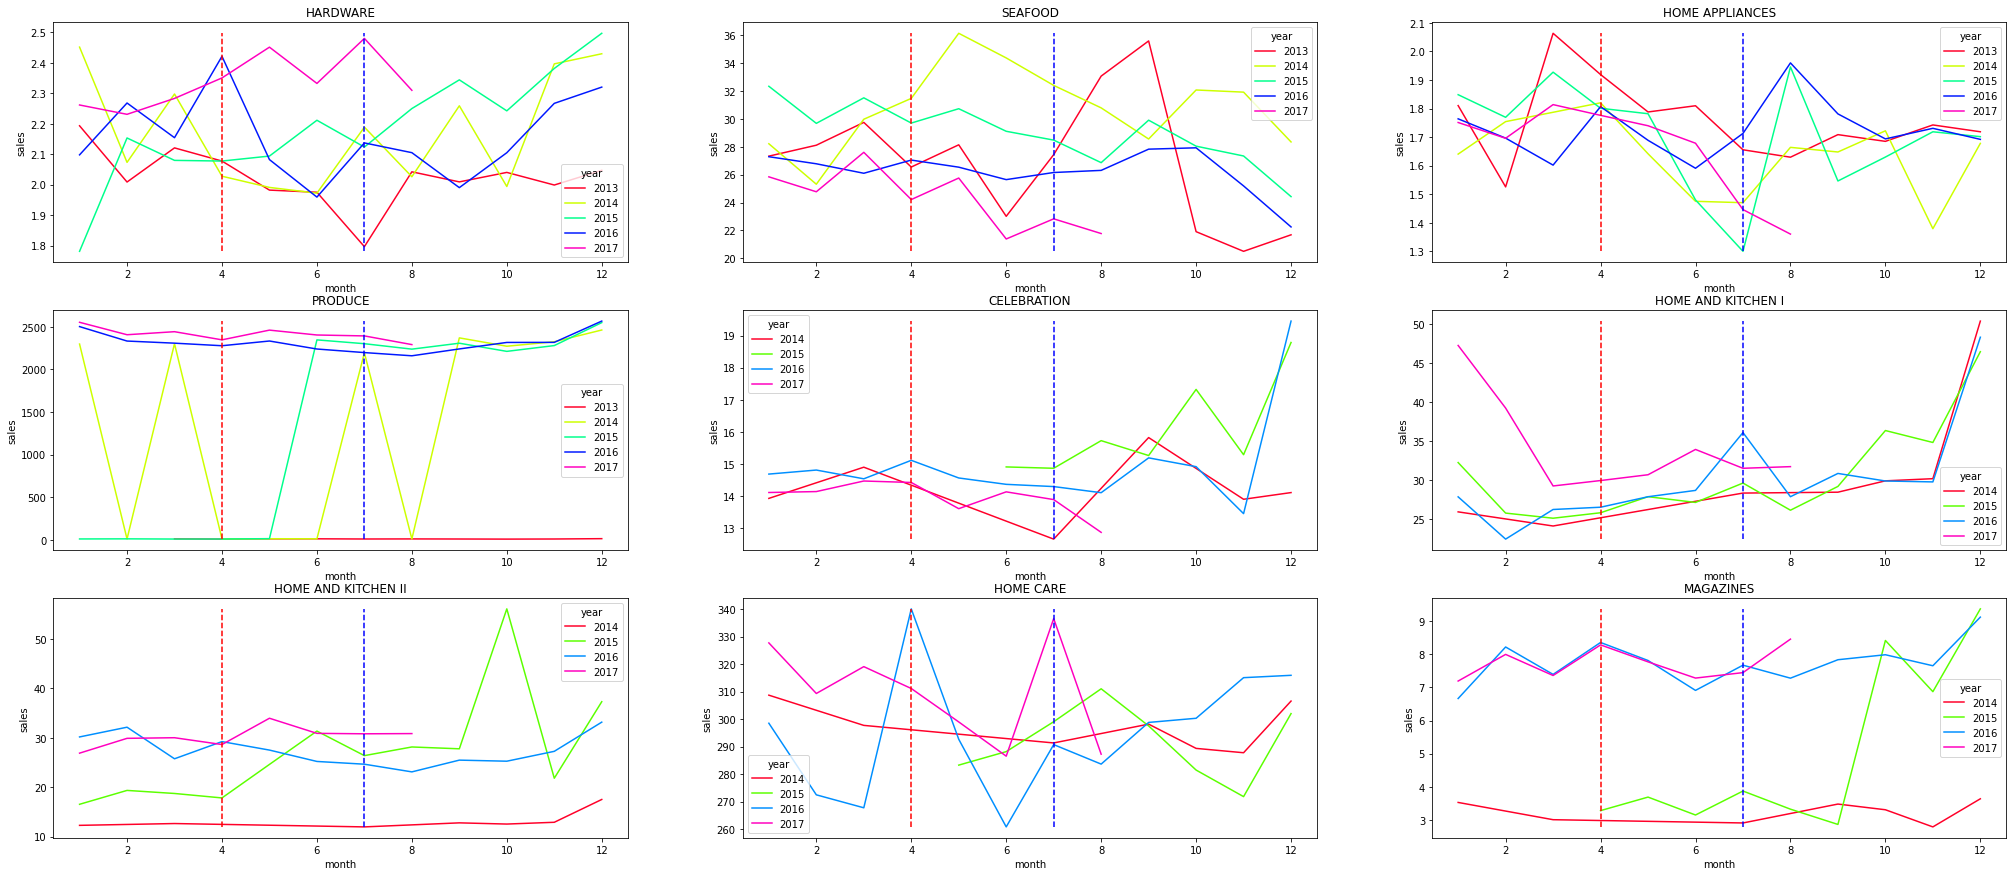

In [ ]:
plt.figure(figsize=(35,15))
f1 = df5.loc[(df5['family']=='HARDWARE')].groupby(['year','month']).mean().reset_index()
f2 = df5.loc[(df5['family']=='SEAFOOD')].groupby(['year','month']).mean().reset_index()
f3 = df5.loc[(df5['family']=='HOME APPLIANCES')].groupby(['year','month']).mean().reset_index()
f4 = df5.loc[(df5['family']=='PRODUCE')].groupby(['year','month']).mean().reset_index()
f5 = df5.loc[(df5['family']=='CELEBRATION')].groupby(['year','month']).mean().reset_index()
f6 = df5.loc[(df5['family']=='HOME AND KITCHEN I')].groupby(['year','month']).mean().reset_index()
f7 = df5.loc[(df5['family']=='HOME AND KITCHEN II')].groupby(['year','month']).mean().reset_index()
f8 = df5.loc[(df5['family']=='HOME CARE')].groupby(['year','month']).mean().reset_index()
f9 = df5.loc[(df5['family']=='MAGAZINES')].groupby(['year','month']).mean().reset_index()

plt.subplot(3,3,1)
plt.title('HARDWARE')
a = sns.lineplot(data=f1, x='month',y='sales', hue='year', palette='gist_rainbow')
a.vlines(4, f1['sales'].min(), f1['sales'].max(), linestyles='dashed', colors='red')
a.vlines(7, f1['sales'].min(), f1['sales'].max(), linestyles='dashed', colors='blue')

plt.subplot(3,3,2)
plt.title('SEAFOOD')
b = sns.lineplot(data=f2, x='month',y='sales', hue='year', palette='gist_rainbow')
b.vlines(4, f2['sales'].min(), f2['sales'].max(), linestyles='dashed', colors='red')
b.vlines(7, f2['sales'].min(), f2['sales'].max(), linestyles='dashed', colors='blue')

plt.subplot(3,3,3)
plt.title('HOME APPLIANCES')
c = sns.lineplot(data=f3, x='month',y='sales', hue='year', palette='gist_rainbow')
c.vlines(4, f3['sales'].min(), f3['sales'].max(), linestyles='dashed', colors='red')
c.vlines(7, f3['sales'].min(), f3['sales'].max(), linestyles='dashed', colors='blue')

plt.subplot(3,3,4)
plt.title('PRODUCE')
d = sns.lineplot(data=f4, x='month',y='sales', hue='year', palette='gist_rainbow')
d.vlines(4, f4['sales'].min(), f4['sales'].max(), linestyles='dashed', colors='red')
d.vlines(7, f4['sales'].min(), f4['sales'].max(), linestyles='dashed', colors='blue')

plt.subplot(3,3,5)
plt.title('CELEBRATION')
e = sns.lineplot(data=f5, x='month',y='sales', hue='year', palette='gist_rainbow')
e.vlines(4, f5['sales'].min(), f5['sales'].max(), linestyles='dashed', colors='red')
e.vlines(7, f5['sales'].min(), f5['sales'].max(), linestyles='dashed', colors='blue')

plt.subplot(3,3,6)
plt.title('HOME AND KITCHEN I')
f = sns.lineplot(data=f6, x='month',y='sales', hue='year', palette='gist_rainbow')
f.vlines(4, f6['sales'].min(), f6['sales'].max(), linestyles='dashed', colors='red')
f.vlines(7, f6['sales'].min(), f6['sales'].max(), linestyles='dashed', colors='blue')

plt.subplot(3,3,7)
plt.title('HOME AND KITCHEN II')
g = sns.lineplot(data=f7, x='month',y='sales', hue='year', palette='gist_rainbow')
g.vlines(4, f7['sales'].min(), f7['sales'].max(), linestyles='dashed', colors='red')
g.vlines(7, f7['sales'].min(), f7['sales'].max(), linestyles='dashed', colors='blue')

plt.subplot(3,3,8)
plt.title('HOME CARE')
h = sns.lineplot(data=f8, x='month',y='sales', hue='year', palette='gist_rainbow')
h.vlines(4, f8['sales'].min(), f8['sales'].max(), linestyles='dashed', colors='red')
h.vlines(7, f8['sales'].min(), f8['sales'].max(), linestyles='dashed', colors='blue')

plt.subplot(3,3,9)
plt.title('MAGAZINES')
i = sns.lineplot(data=f9, x='month',y='sales', hue='year', palette='gist_rainbow')
i.vlines(4, f9['sales'].min(), f9['sales'].max(), linestyles='dashed', colors='red')
i.vlines(7, f9['sales'].min(), f9['sales'].max(), linestyles='dashed', colors='blue');

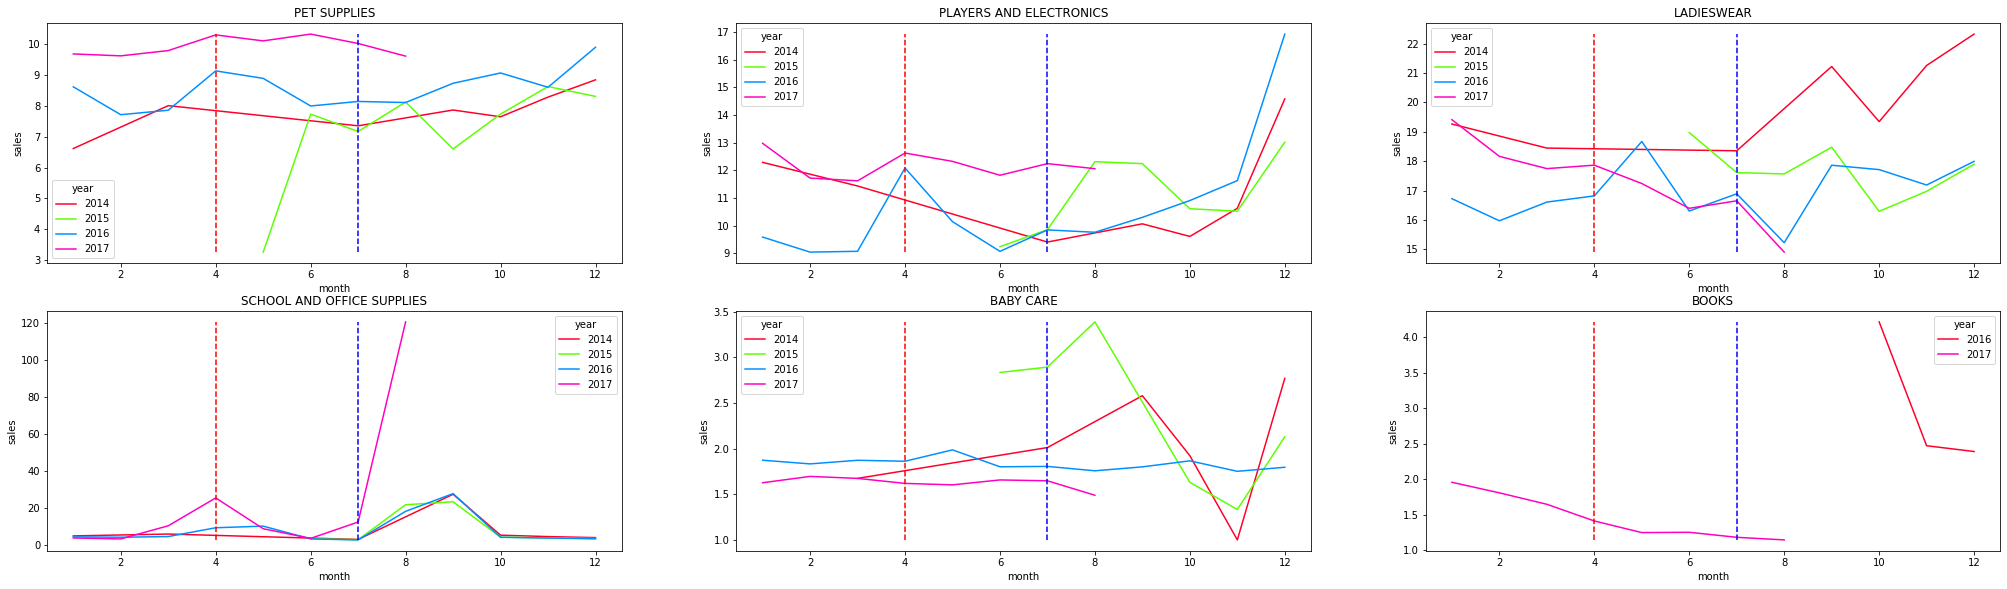

In [ ]:
plt.figure(figsize=(35,15))
f1 = df5.loc[(df5['family']=='PET SUPPLIES')].groupby(['year','month']).mean().reset_index()
f2 = df5.loc[(df5['family']=='PLAYERS AND ELECTRONICS')].groupby(['year','month']).mean().reset_index()
f3 = df5.loc[(df5['family']=='LADIESWEAR')].groupby(['year','month']).mean().reset_index()
f4 = df5.loc[(df5['family']=='SCHOOL AND OFFICE SUPPLIES')].groupby(['year','month']).mean().reset_index()
f5 = df5.loc[(df5['family']=='BABY CARE')].groupby(['year','month']).mean().reset_index()
f6 = df5.loc[(df5['family']=='BOOKS')].groupby(['year','month']).mean().reset_index()

plt.subplot(3,3,1)
plt.title('PET SUPPLIES')
a = sns.lineplot(data=f1, x='month',y='sales', hue='year', palette='gist_rainbow')
a.vlines(4, f1['sales'].min(), f1['sales'].max(), linestyles='dashed', colors='red')
a.vlines(7, f1['sales'].min(), f1['sales'].max(), linestyles='dashed', colors='blue')

plt.subplot(3,3,2)
plt.title('PLAYERS AND ELECTRONICS')
b = sns.lineplot(data=f2, x='month',y='sales', hue='year', palette='gist_rainbow')
b.vlines(4, f2['sales'].min(), f2['sales'].max(), linestyles='dashed', colors='red')
b.vlines(7, f2['sales'].min(), f2['sales'].max(), linestyles='dashed', colors='blue')

plt.subplot(3,3,3)
plt.title('LADIESWEAR')
c = sns.lineplot(data=f3, x='month',y='sales', hue='year', palette='gist_rainbow')
c.vlines(4, f3['sales'].min(), f3['sales'].max(), linestyles='dashed', colors='red')
c.vlines(7, f3['sales'].min(), f3['sales'].max(), linestyles='dashed', colors='blue')

plt.subplot(3,3,4)
plt.title('SCHOOL AND OFFICE SUPPLIES')
d = sns.lineplot(data=f4, x='month',y='sales', hue='year', palette='gist_rainbow')
d.vlines(4, f4['sales'].min(), f4['sales'].max(), linestyles='dashed', colors='red')
d.vlines(7, f4['sales'].min(), f4['sales'].max(), linestyles='dashed', colors='blue')

plt.subplot(3,3,5)
plt.title('BABY CARE')
e = sns.lineplot(data=f5, x='month',y='sales', hue='year', palette='gist_rainbow')
e.vlines(4, f5['sales'].min(), f5['sales'].max(), linestyles='dashed', colors='red')
e.vlines(7, f5['sales'].min(), f5['sales'].max(), linestyles='dashed', colors='blue')

plt.subplot(3,3,6)
plt.title('BOOKS')
f = sns.lineplot(data=f6, x='month',y='sales', hue='year', palette='gist_rainbow')
f.vlines(4, f6['sales'].min(), f6['sales'].max(), linestyles='dashed', colors='red')
f.vlines(7, f6['sales'].min(), f6['sales'].max(), linestyles='dashed', colors='blue');

In [ ]:
# definindo outliers para cada family por ano, bem como valor para substituição dos outliers extremos

outliers_family_per_year_month = df5.groupby(['year','month','store_nbr','family'])['sales'].quantile(q=[0.25, 0.75]).reset_index().pivot(index=['year','month','store_nbr','family'], columns='level_4', values='sales').reset_index().rename(columns={0.25:'q1',0.75:'q3'})
data = df5.groupby(['year','month','store_nbr','family'])['sales'].median().reset_index().rename(columns={'sales':'median'})
outliers_family_per_year_month['outlier'] = outliers_family_per_year_month.apply(lambda x: 3 * (x['q3'] - x['q1']), axis=1)
outliers_family_per_year_month['outlier_max'] = outliers_family_per_year_month.apply(lambda x: x['q3'] + x['outlier'], axis=1)
outliers_family_per_year_month['outlier_min'] = outliers_family_per_year_month.apply(lambda x: x['q1'] - x['outlier'], axis=1)
outliers_family_per_year_month['median'] = data['median']

outliers_family_per_year_month

level_4,year,month,store_nbr,family,q1,q3,outlier,outlier_max,outlier_min,median
0,2013,1,1,AUTOMOTIVE,2.000,3.000,3.000,6.000,-1.000,2.000
1,2013,1,1,BEAUTY,1.750,3.000,3.750,6.750,-2.000,2.000
2,2013,1,1,BEVERAGES,891.250,1123.500,696.750,1820.250,194.500,1032.000
3,2013,1,1,BREAD/BAKERY,279.191,319.277,120.258,439.535,158.933,300.129
4,2013,1,1,CLEANING,620.250,823.000,608.250,1431.250,12.000,694.000
...,...,...,...,...,...,...,...,...,...,...
76128,2017,8,54,PLAYERS AND ELECTRONICS,1.000,4.000,9.000,13.000,-8.000,2.500
76129,2017,8,54,POULTRY,57.887,76.176,54.867,131.043,3.020,65.833
76130,2017,8,54,PREPARED FOODS,74.000,92.500,55.500,148.000,18.500,86.000
76131,2017,8,54,PRODUCE,562.053,833.659,814.817,1648.475,-252.764,617.052


#### Is promo **

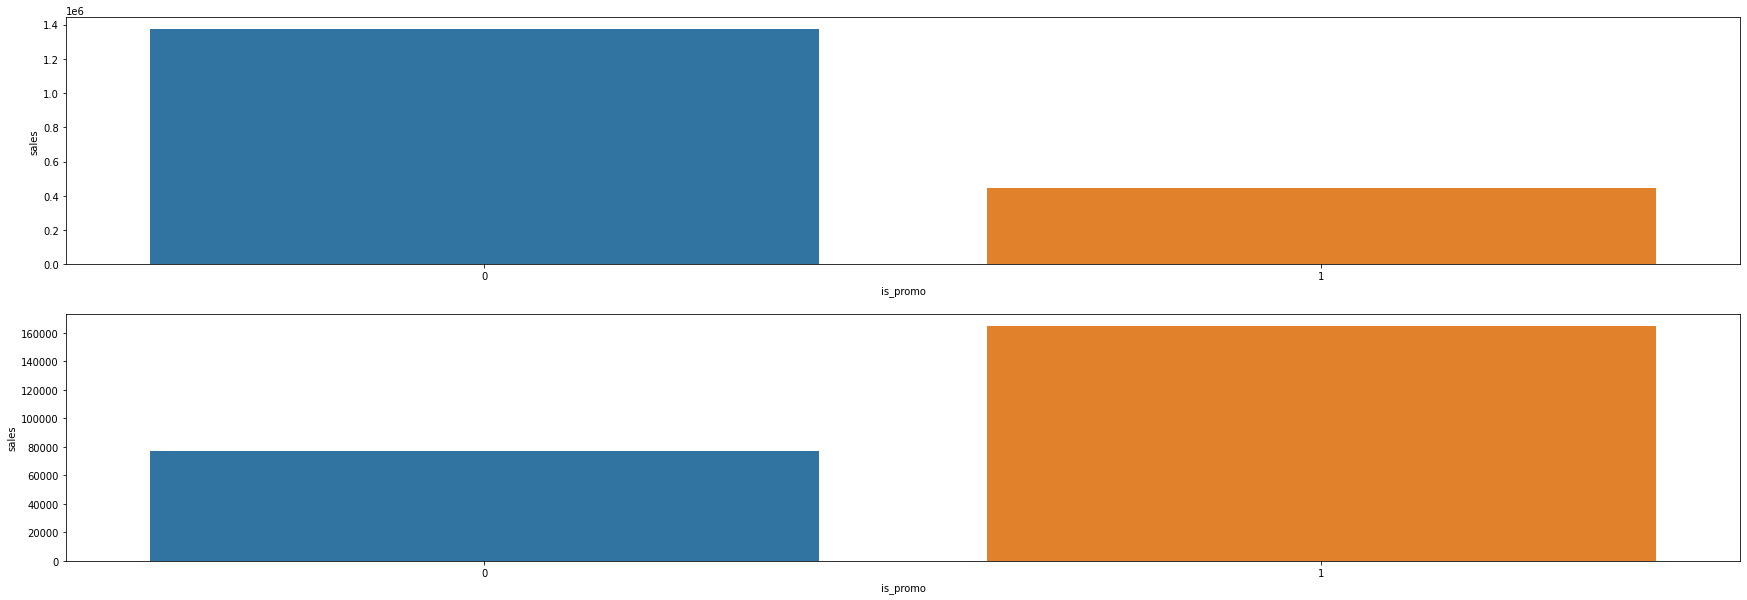

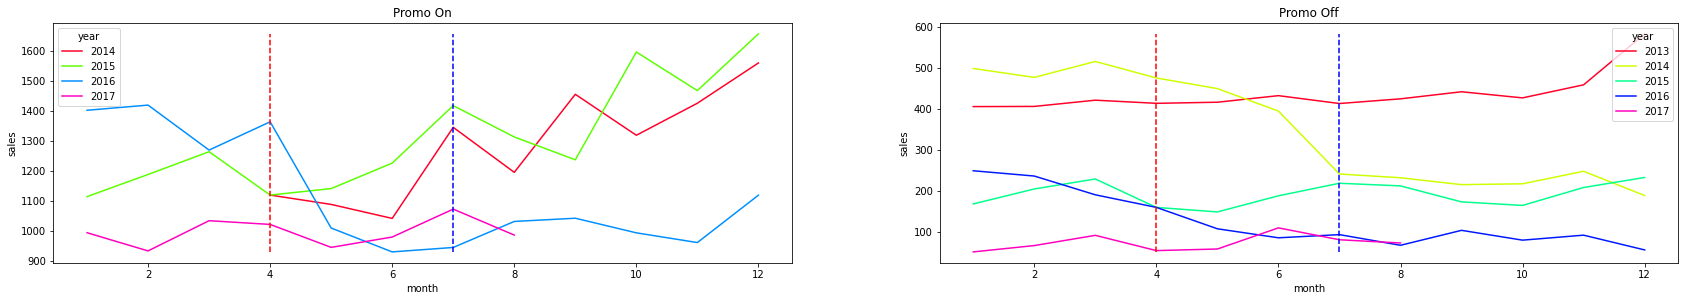

In [ ]:
h11 = nol[['is_promo','sales']].groupby('is_promo').count().reset_index(drop=False)
h11o = ol[['is_promo','sales']].groupby('is_promo').count().reset_index(drop=False)
plt.subplot(2,1,1)
sns.barplot(data=h11, x='is_promo', y='sales')
plt.subplot(2,1,2)
sns.barplot(data=h11o, x='is_promo', y='sales');

plt.figure(figsize=(45,15))
f1 = df5.loc[(df5['is_promo']==1)].groupby(['year','month']).mean().reset_index()
f2 = df5.loc[(df5['is_promo']==0)].groupby(['year','month']).mean().reset_index()

plt.subplot(3,3,1)
plt.title('Promo On')
a = sns.lineplot(data=f1, x='month',y='sales', hue='year', palette='gist_rainbow')
a.vlines(4, f1['sales'].min(), f1['sales'].max(), linestyles='dashed', colors='red')
a.vlines(7, f1['sales'].min(), f1['sales'].max(), linestyles='dashed', colors='blue')

plt.subplot(3,3,2)
plt.title('Promo Off')
b = sns.lineplot(data=f2, x='month',y='sales', hue='year', palette='gist_rainbow')
b.vlines(4, f2['sales'].min(), f2['sales'].max(), linestyles='dashed', colors='red')
b.vlines(7, f2['sales'].min(), f2['sales'].max(), linestyles='dashed', colors='blue');

#### Store cluster

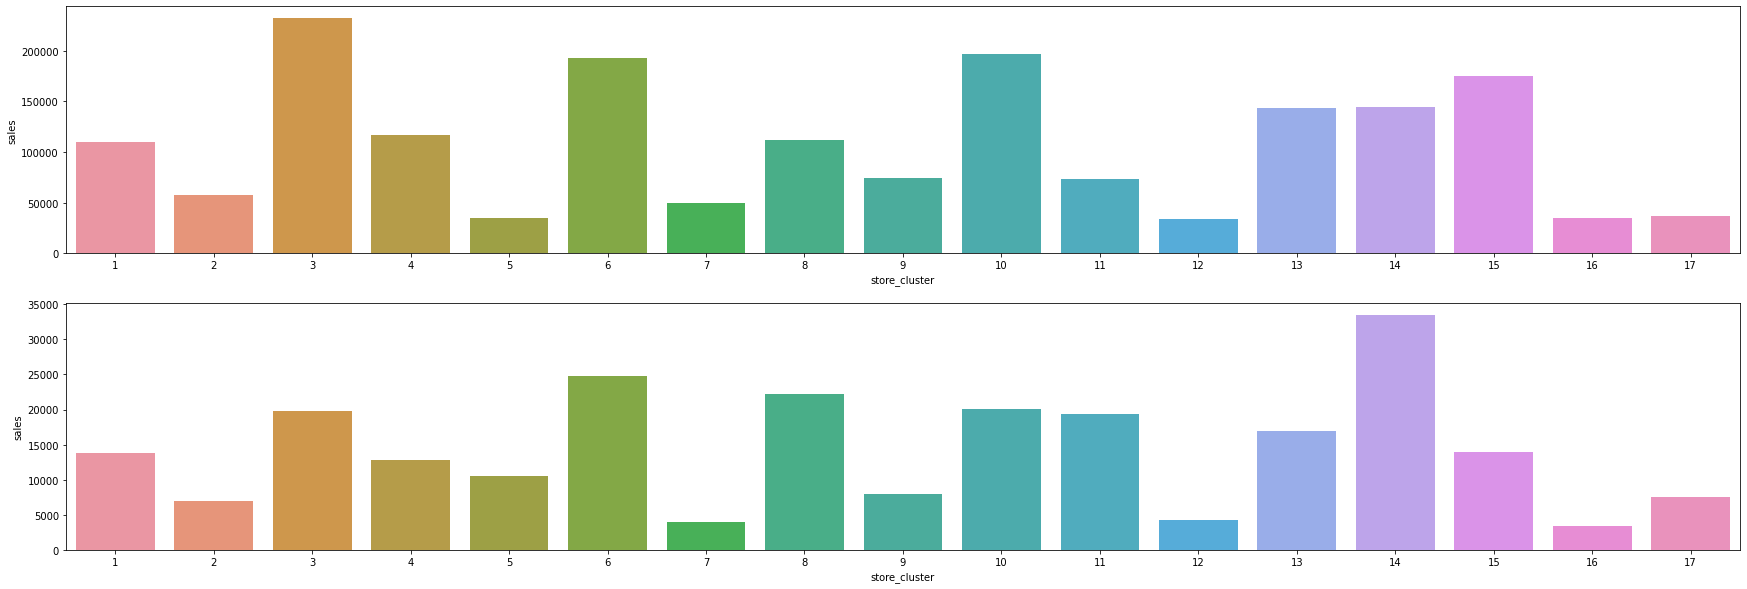

In [ ]:
h12 = nol[['store_cluster','sales']].groupby('store_cluster').count().reset_index(drop=False)
h12o = ol[['store_cluster','sales']].groupby('store_cluster').count().reset_index(drop=False)
plt.subplot(2,1,1)
sns.barplot(data=h12, x='store_cluster', y='sales')
plt.subplot(2,1,2)
sns.barplot(data=h12o, x='store_cluster', y='sales');

### Validação de hipóteses

#### H1. A ocorrência de fenomenos climáticos aumenta o número de vendas
**Verdadeira.** A ocorrência de fenomenos climáticos aumenta ligeiramente as vendas na maioria das cidades

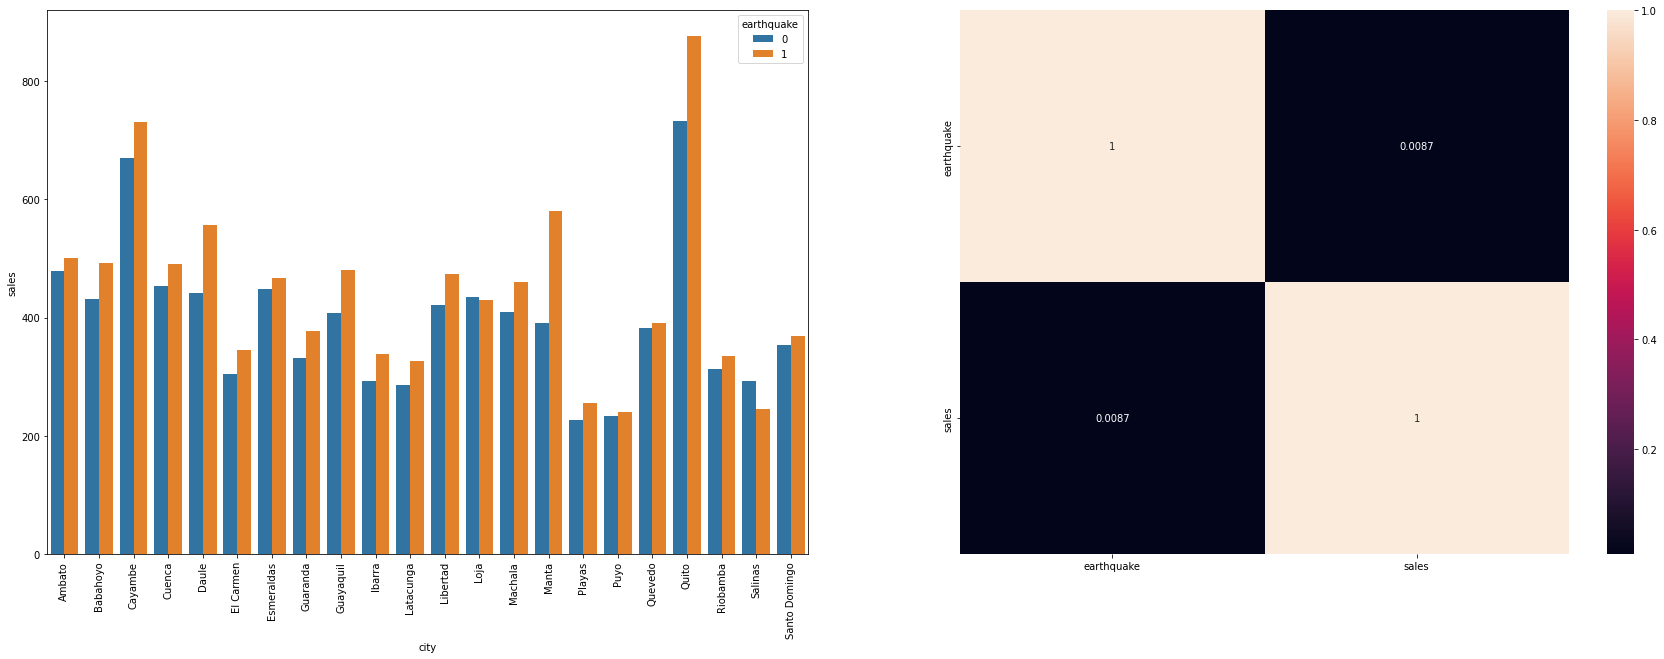

In [ ]:
h1 = df5[['earthquake','city','sales']]
a = h1.groupby(['city','earthquake']).mean().sort_values('city').reset_index(drop=False)

plt.subplot(1,2,1)
sns.barplot(data=a, x='city', y='sales', hue='earthquake')
plt.xticks(rotation=90)

plt.subplot(1,2,2)
sns.heatmap(h1.corr(method='pearson'),annot=True);

##### Os itens mais vendidos na ocorrência de fenômenos climáticos

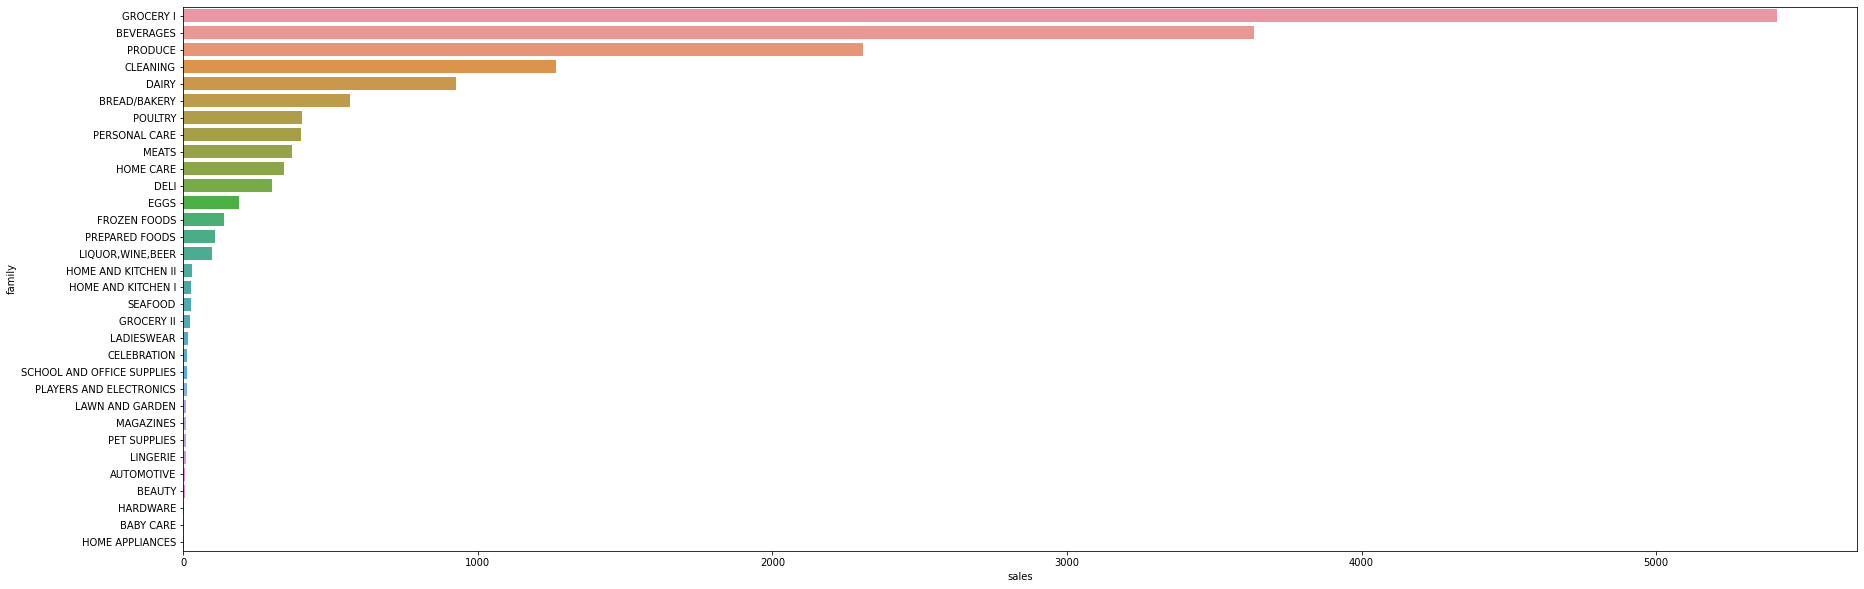

In [ ]:
h1a = df5[['earthquake','family','sales']]

a = h1a.loc[h1a['earthquake']==1, ['family','sales']].groupby('family').mean().sort_values('sales', ascending=False).reset_index(drop=False)
sns.barplot(data=a, y='family', x='sales');

#### H2. O preço do petróleo é inversamente proporcional ao número de vendas ao longo dos anos
**Verdadeira.** O volume de vendas aumenta ao passo que o preço do petróleo diminui

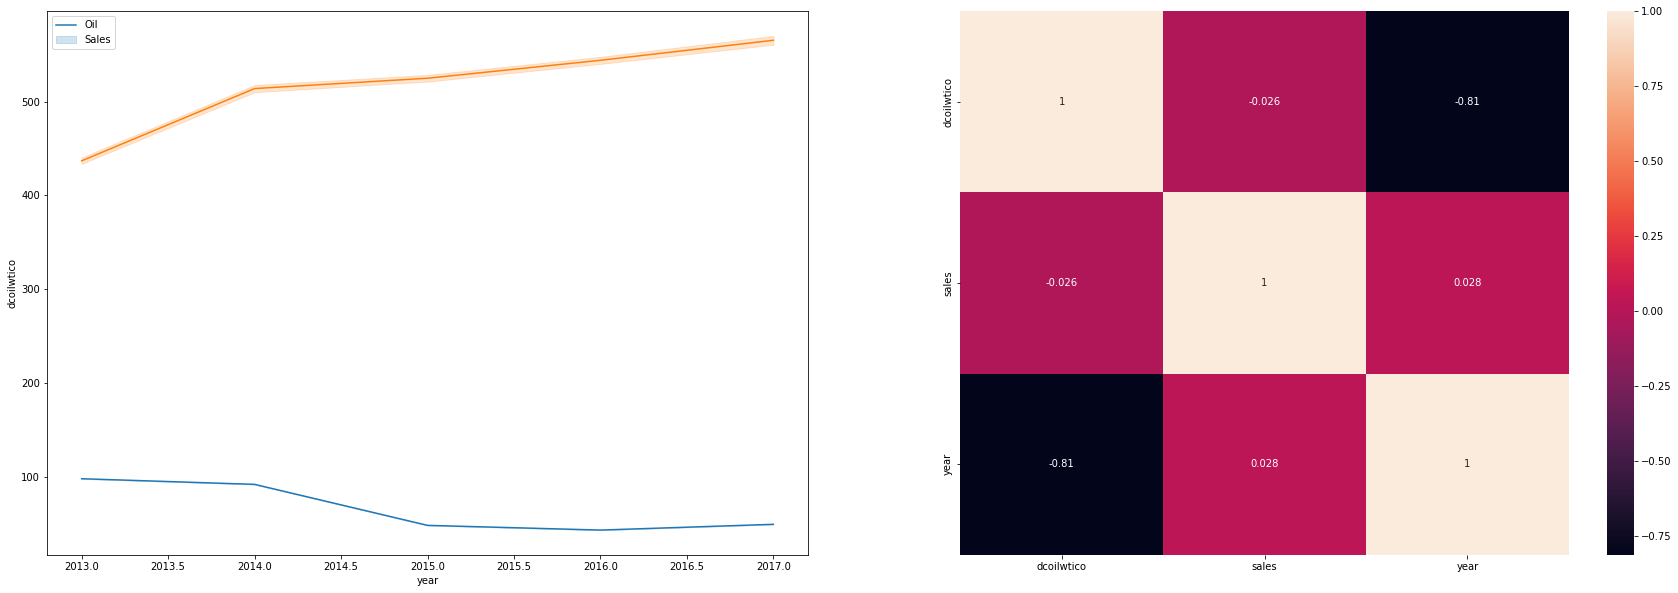

In [ ]:
h3 = df5[['dcoilwtico','sales','year']]

plt.subplot(1,2,1)
ax = sns.lineplot(data=h3, y='dcoilwtico', x='year')
sns.lineplot(data=h3, y='sales', x='year', ax=ax)
ax.legend(labels=['Oil', 'Sales'])

plt.subplot(1,2,2)
sns.heatmap(h3.corr(method='pearson'),annot=True);

##### Variacão YoY

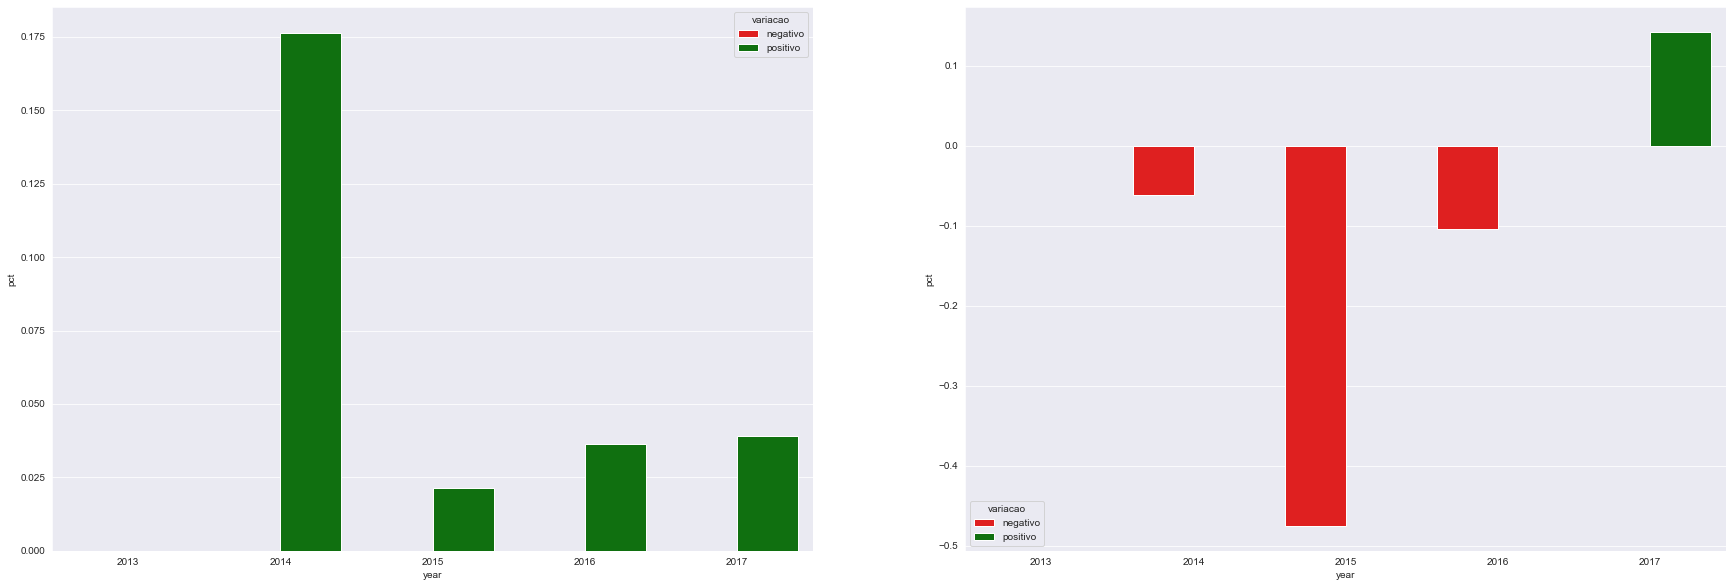

In [ ]:
a = h3[['sales','year']].groupby('year').mean().reset_index(drop=False)
a['pct'] = a['sales'].pct_change()
a['variacao'] = a['pct'].apply(lambda x: 'positivo' if x>0 else 'negativo')


b = h3[['dcoilwtico','year']].groupby('year').mean().reset_index(drop=False)
b['pct'] = b['dcoilwtico'].pct_change()
b['variacao'] = b['pct'].apply(lambda x: 'positivo' if x>0 else 'negativo')

sns.set_style('darkgrid')
color = ['red','green']

plt.subplot(1,2,1)
aplot = sns.barplot(data=a, x='year', y='pct', hue='variacao', palette=color)
plt.subplot(1,2,2)
bplot = sns.barplot(data=b, x='year', y='pct', hue='variacao', palette=color);

#### H3. O pico de vendas de BEVERAGES é de sexta à domingo
**Verdadeira.** De modo geral, o maior volume de vendas de BEVERAGES é de sexta à domingo

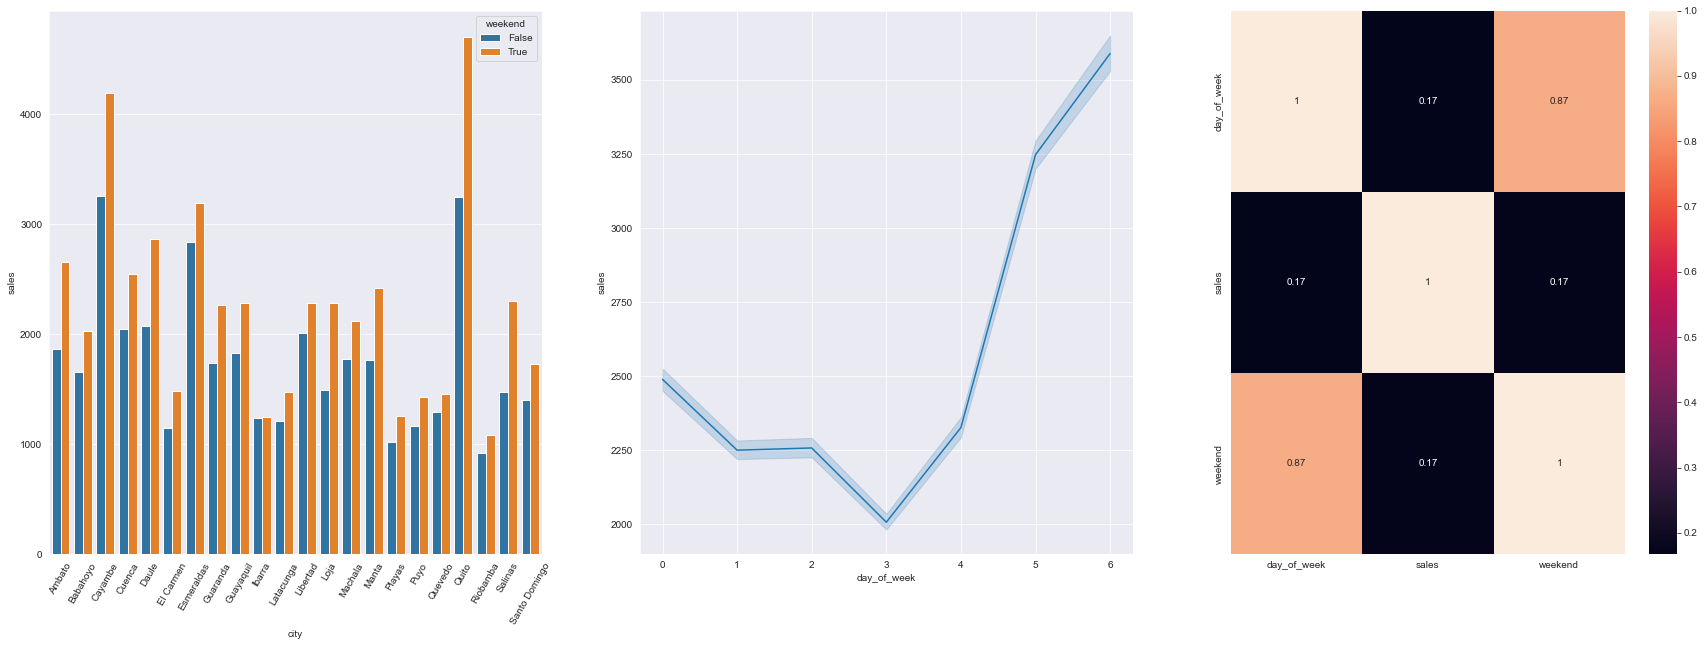

In [ ]:
h6 = df5.loc[df5['family']=='BEVERAGES',['family','city','day_of_week','sales']]
h6['weekend'] = h6['day_of_week'].apply(lambda x: True if x in([4,5,6]) else False)
a = h6[['city','weekend','sales']].groupby(['city','weekend']).mean().reset_index(drop=False)

plt.subplot(1,3,1)
sns.barplot(data=a, x='city', y='sales', hue='weekend')
plt.xticks(rotation=60)
plt.subplot(1,3,2)
sns.lineplot(data=h6, x='day_of_week', y='sales')
plt.subplot(1,3,3)
sns.heatmap(h6.corr(method='pearson'),annot=True);

#### H4. Lojas que fazem mais promoções vendem mais
**Falsa.** A relação da quantidade de promoções e volume de vendas não é diretamente proporcional

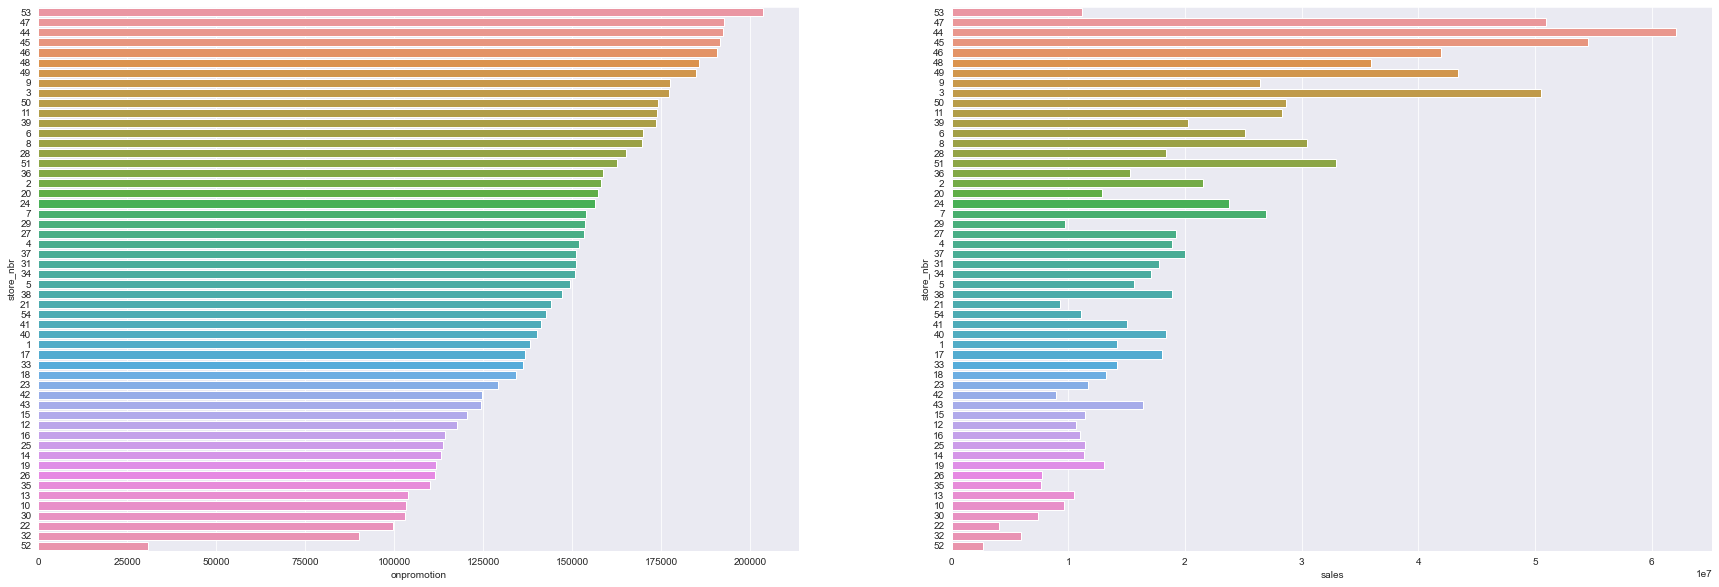

In [ ]:
h7 = df5[['store_nbr', 'onpromotion', 'sales']]
h7['store_nbr'] = h7['store_nbr'].astype('string')

a = h7[['store_nbr','onpromotion']].groupby('store_nbr').sum().reset_index(drop=False).sort_values('onpromotion', ascending=False)
b = h7[['store_nbr','sales']].groupby('store_nbr').sum().reset_index(drop=False).sort_values('sales', ascending=False)
plot = pd.merge(a,b,how='inner',on='store_nbr')

plt.subplot(1,2,1)
sns.barplot(data=plot, y='store_nbr', x='onpromotion', orient='h')
plt.subplot(1,2,2)
sns.barplot(data=plot, y='store_nbr', x='sales', orient='h');

#### H5. O dia de pagamento do setor público interfere no volume de vendas
**Verdadeiro.** Os dias de pagamento do setor público (15 e 30) causam um ligeiro aumento na vendas

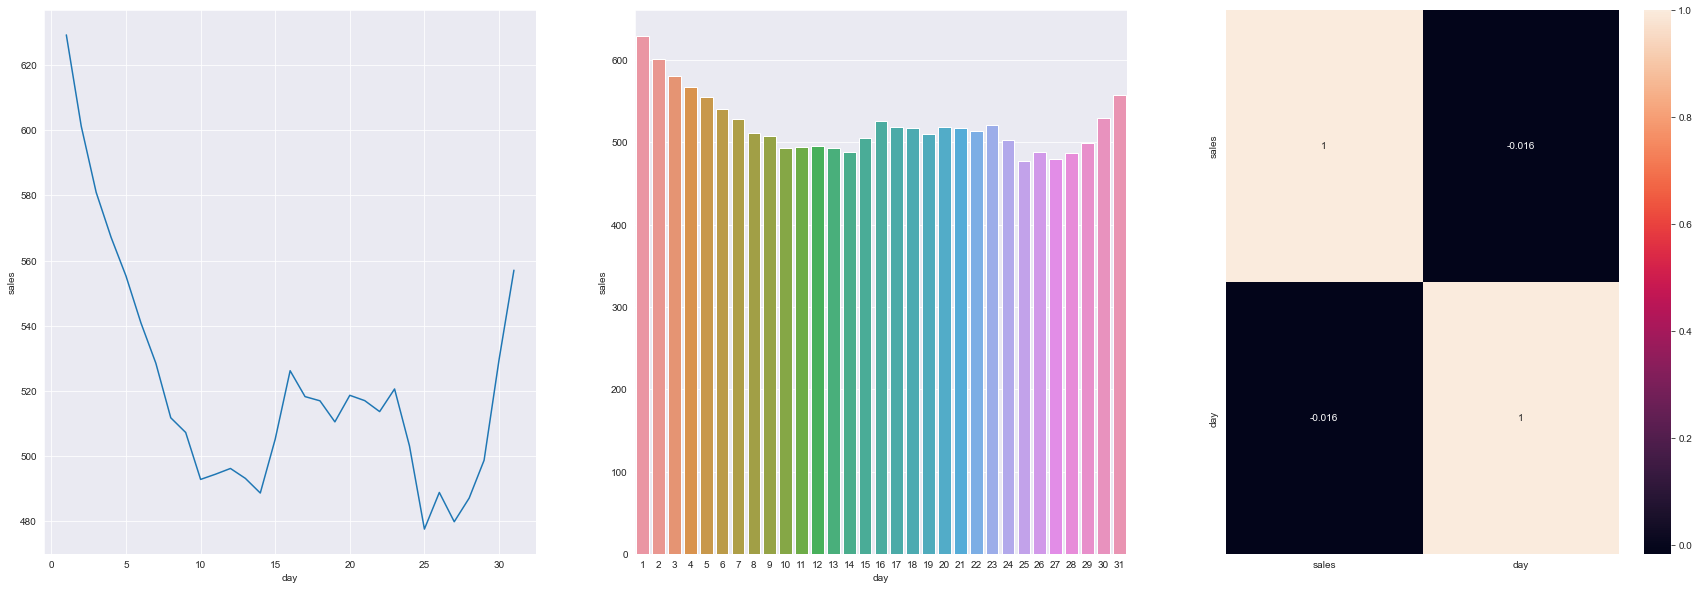

In [ ]:
h10 = df5[['sales','day']]
a = h10.groupby('day').mean().reset_index(drop=False).sort_values('day')

plt.subplot(1,3,1)
sns.lineplot(data=a, x='day', y='sales')
plt.subplot(1,3,2)
sns.barplot(data=a, x='day', y='sales')
plt.subplot(1,3,3)
sns.heatmap(h10.corr(method='pearson'), annot=True);

#### H6. Na semana, o maior volume de vendas se concentra de sexta à domingo
**Falsa.** O maior volume de vendas se concentra de sábado à segunda

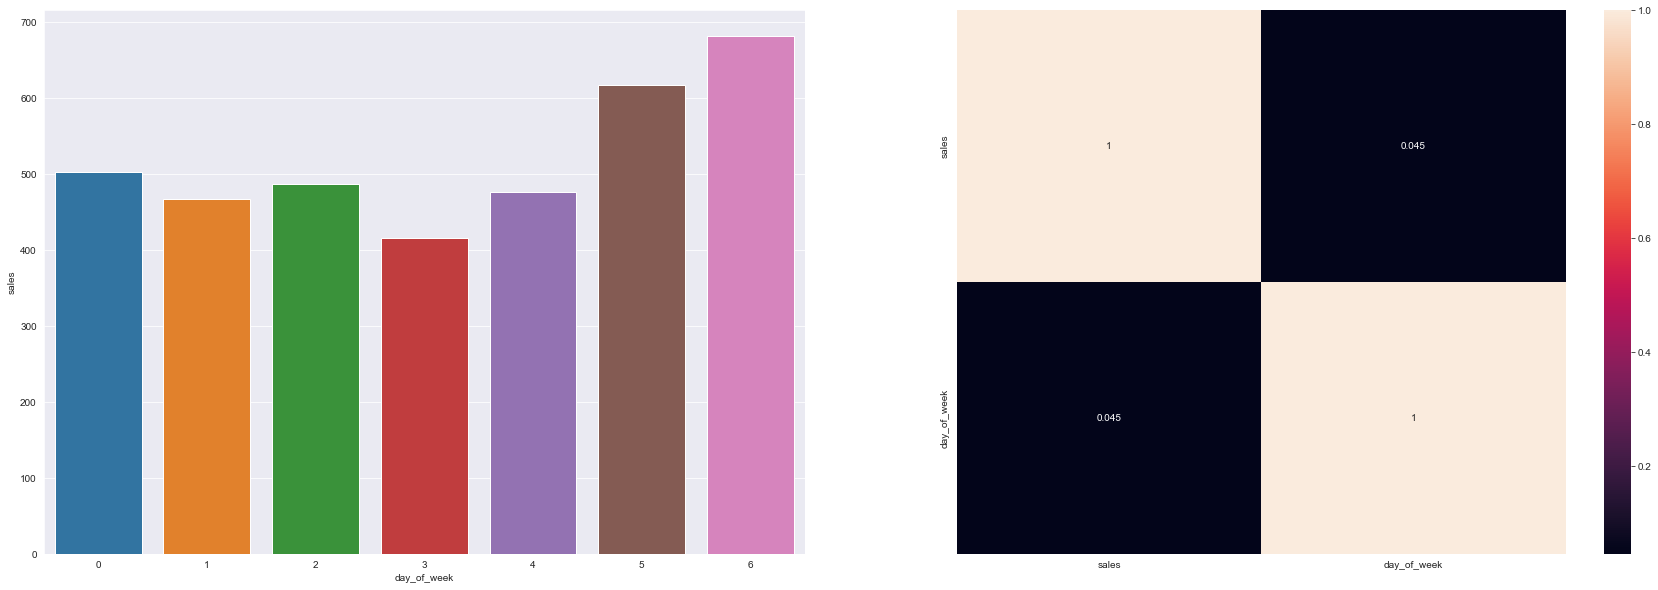

In [ ]:
h11 = df5[['sales','day_of_week']]

a = h11.groupby('day_of_week').mean().reset_index(drop=False)

plt.subplot(1,2,1)
sns.barplot(data=a, x='day_of_week',y='sales')
plt.subplot(1,2,2)
sns.heatmap(h11.corr(method='pearson'),annot=True);

Store related

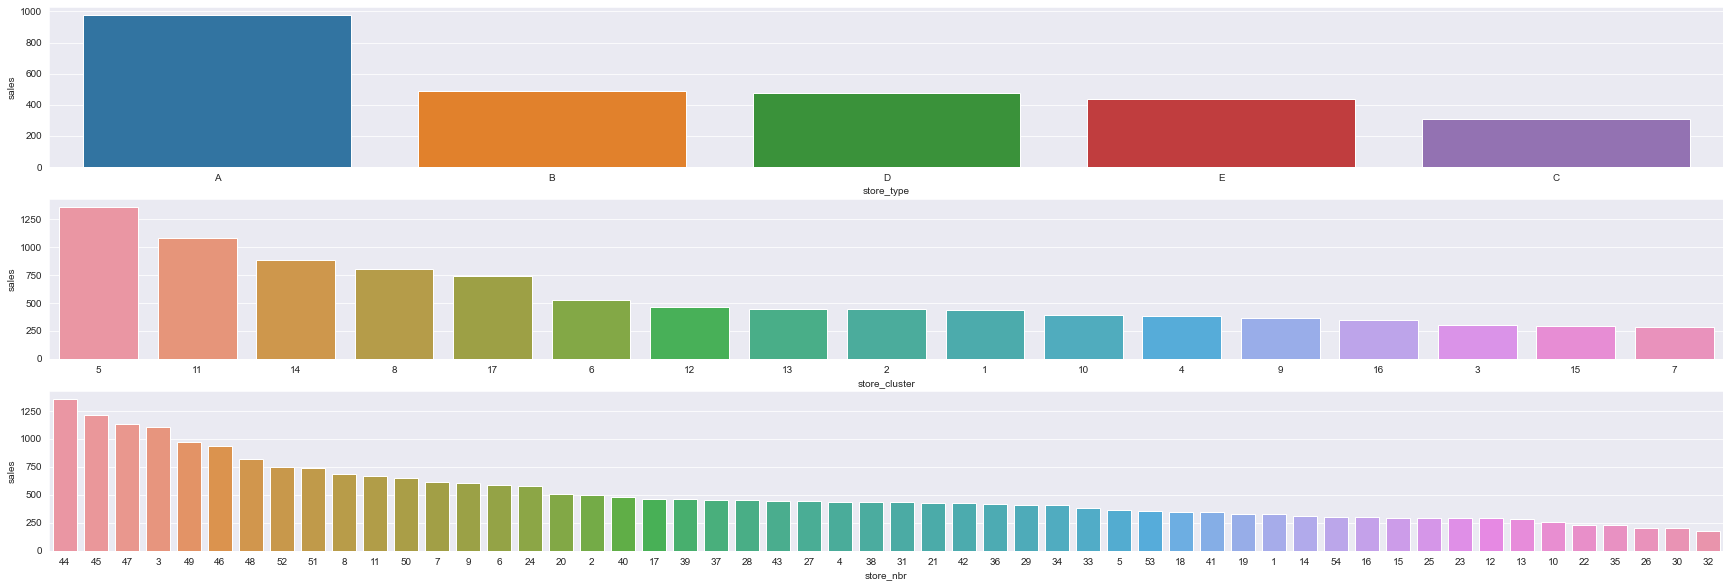

In [ ]:
# store related
a = df5[['store_type','sales']].groupby('store_type').mean().reset_index(drop=False).sort_values('sales',ascending=False)
b = df5[['store_cluster','sales']].groupby('store_cluster').mean().reset_index(drop=False).sort_values('sales',ascending=False)
b['store_cluster'] = b['store_cluster'].astype('string')
c = df5[['store_nbr','sales']].groupby('store_nbr').mean().reset_index(drop=False).sort_values('sales',ascending=False)
c['store_nbr'] = c['store_nbr'].astype('string')

plt.subplot(3,1,1)
sns.barplot(data=a, x='store_type', y='sales')
plt.subplot(3,1,2)
sns.barplot(data=b, x='store_cluster', y='sales')
plt.subplot(3,1,3)
sns.barplot(data=c, x='store_nbr', y='sales');

Spacial related

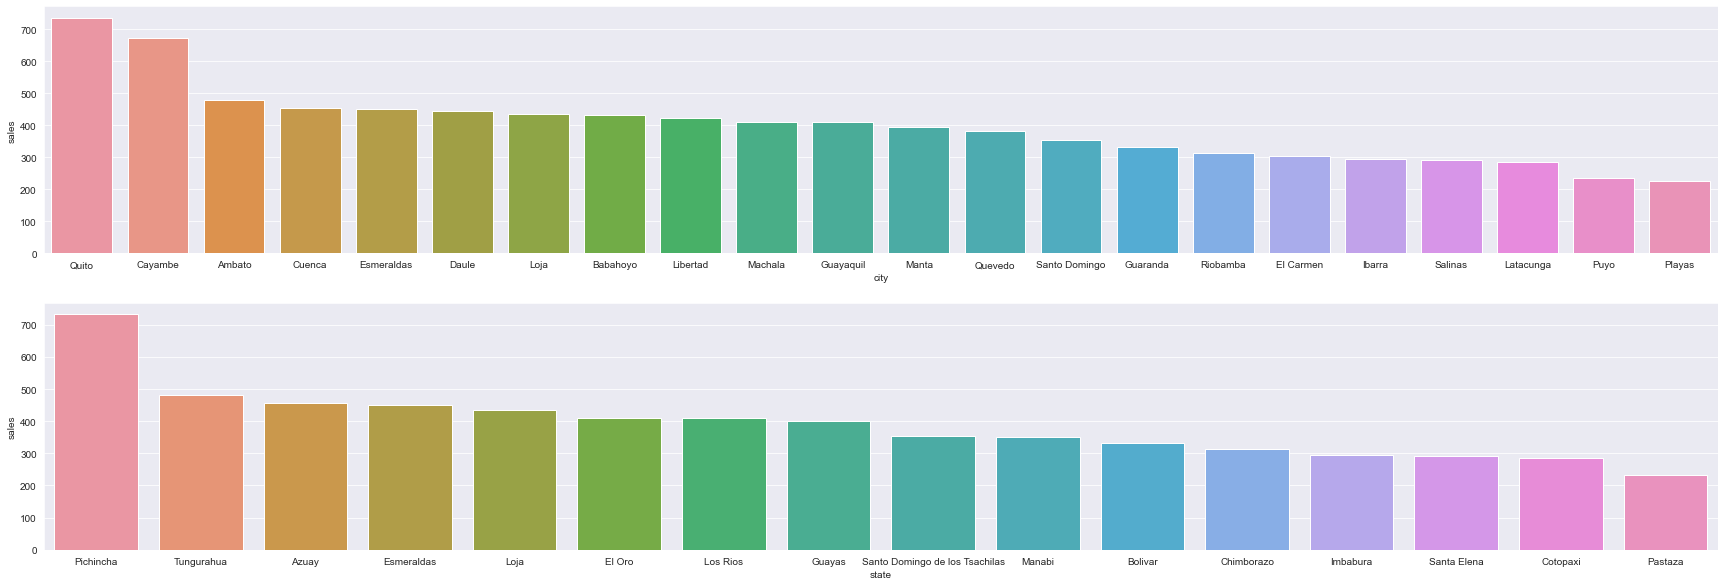

In [ ]:
# spacial related
a = df5[['city','sales']].groupby('city').mean().reset_index(drop=False).sort_values('sales',ascending=False)
b = df5[['state','sales']].groupby('state').mean().reset_index(drop=False).sort_values('sales',ascending=False)

plt.subplot(2,1,1)
sns.barplot(data=a, x='city', y='sales')
plt.subplot(2,1,2)
sns.barplot(data=b, x='state', y='sales');

Time related

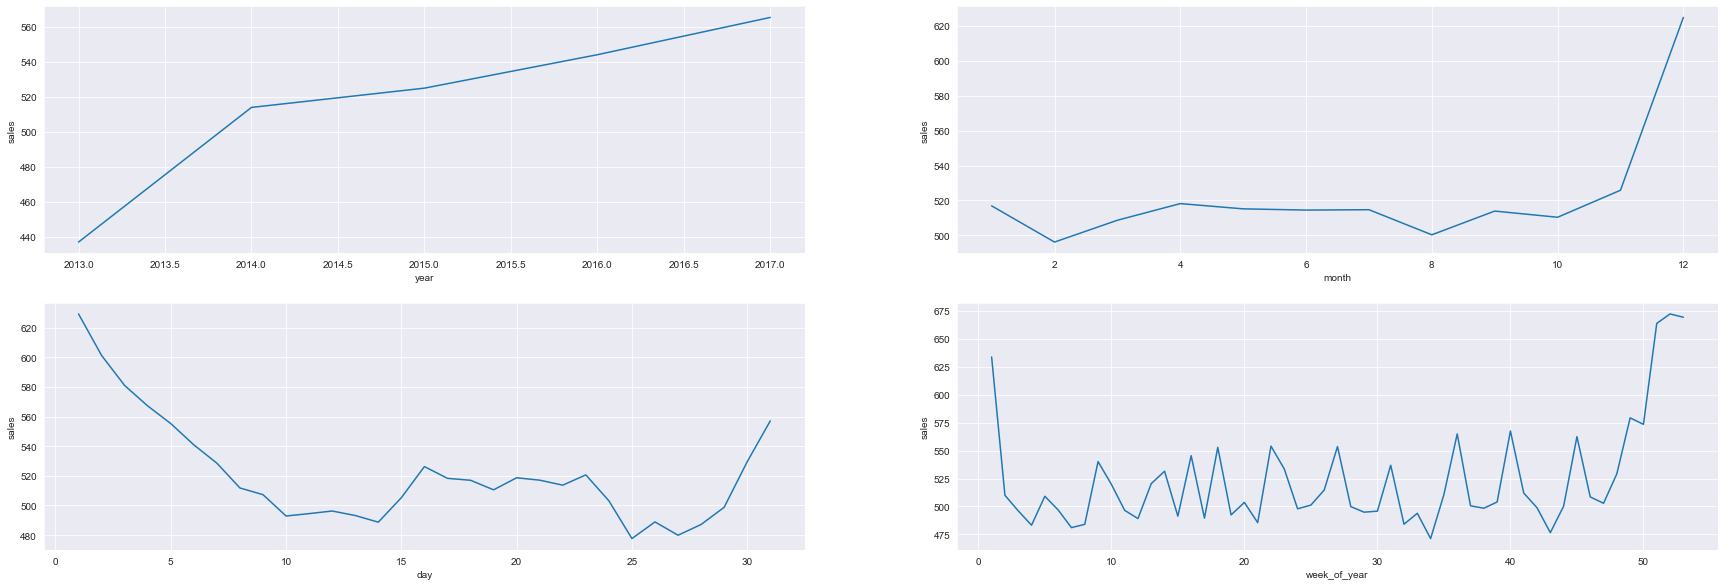

In [ ]:
# time related
a = df5[['year','sales']].groupby('year').mean().reset_index(drop=False)
b = df5[['month','sales']].groupby('month').mean().reset_index(drop=False)
c = df5[['day','sales']].groupby('day').mean().reset_index(drop=False)
d = df5[['week_of_year','sales']].groupby('week_of_year').mean().reset_index(drop=False)

plt.subplot(2,2,1)
sns.lineplot(data=a, x='year', y='sales')
plt.subplot(2,2,2)
sns.lineplot(data=b, x='month', y='sales')
plt.subplot(2,2,3)
sns.lineplot(data=c, x='day', y='sales')
plt.subplot(2,2,4)
sns.lineplot(data=d, x='week_of_year', y='sales');

Others

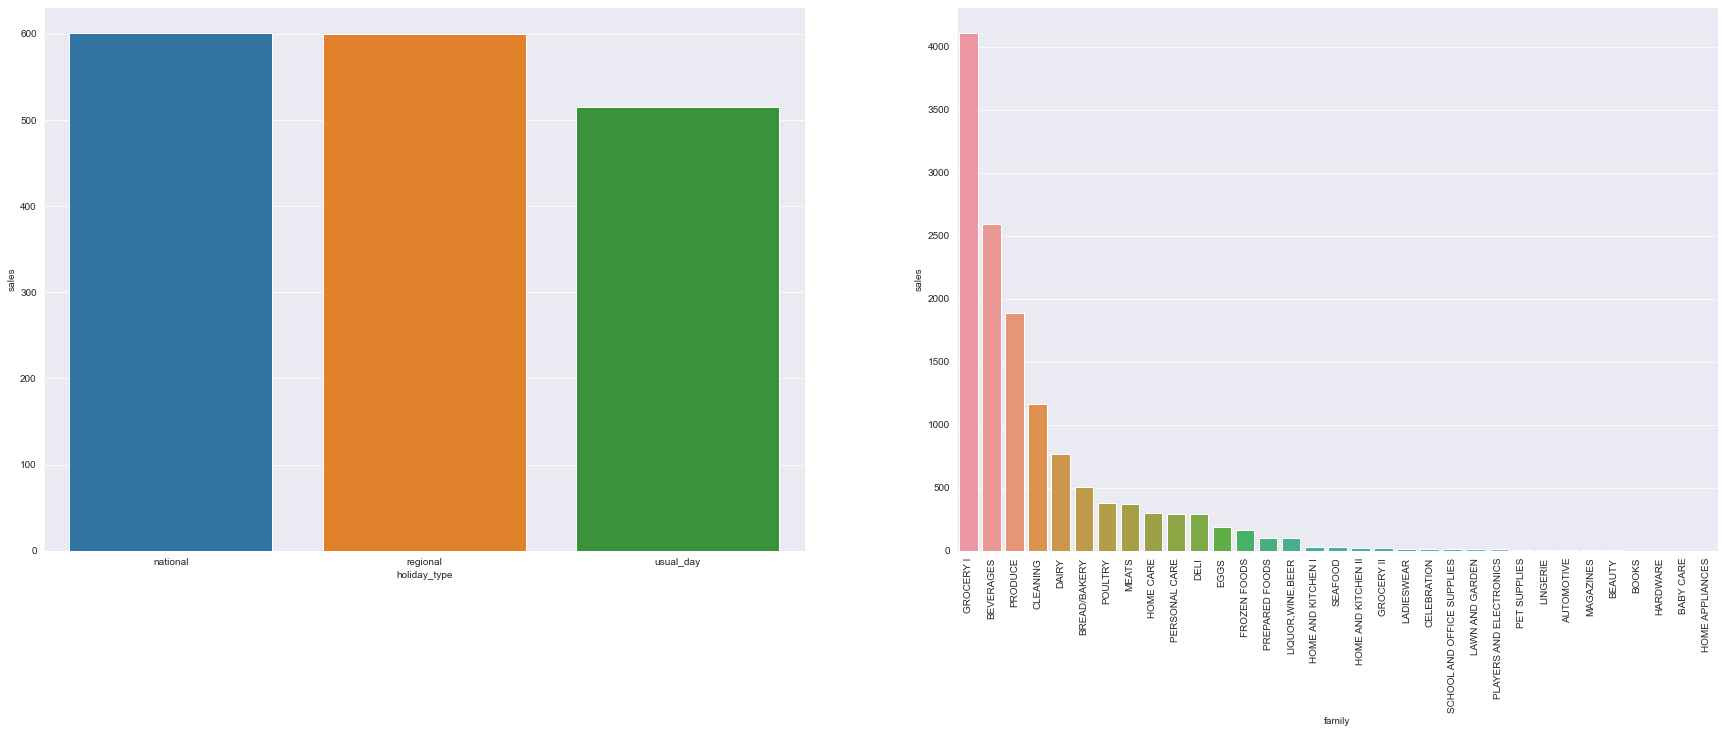

In [ ]:
# others
a = df5[['holiday_type','sales']].groupby('holiday_type').mean().reset_index(drop=False).sort_values('sales',ascending=False)
b = df5[['family','sales']].groupby('family').mean().reset_index(drop=False).sort_values('sales',ascending=False)

plt.subplot(1,2,1)
sns.barplot(data=a, x='holiday_type', y='sales')
plt.subplot(1,2,2)
sns.barplot(data=b, x='family', y='sales')
plt.xticks(rotation=90);

## 5.3. Multivariate analysis

### 5.3.1. Numerical Attributes

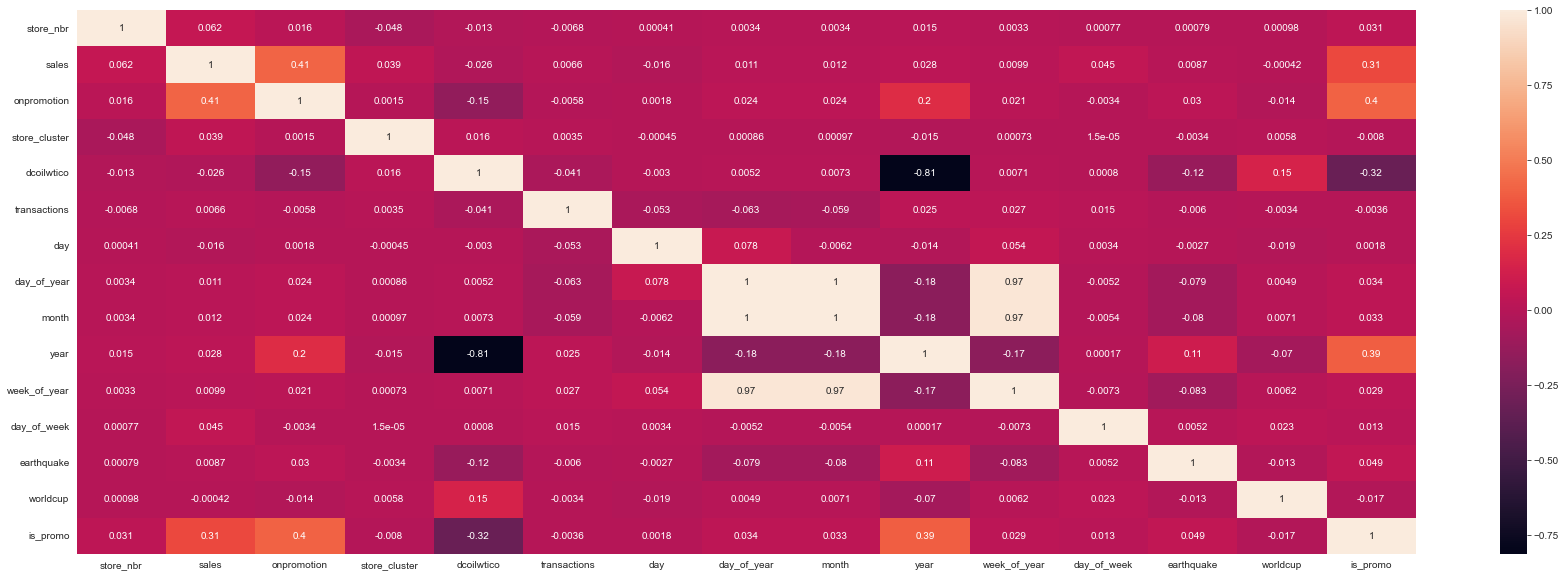

In [ ]:
correlation = num_attributes_eng.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 5.3.2. Categorical Attributes

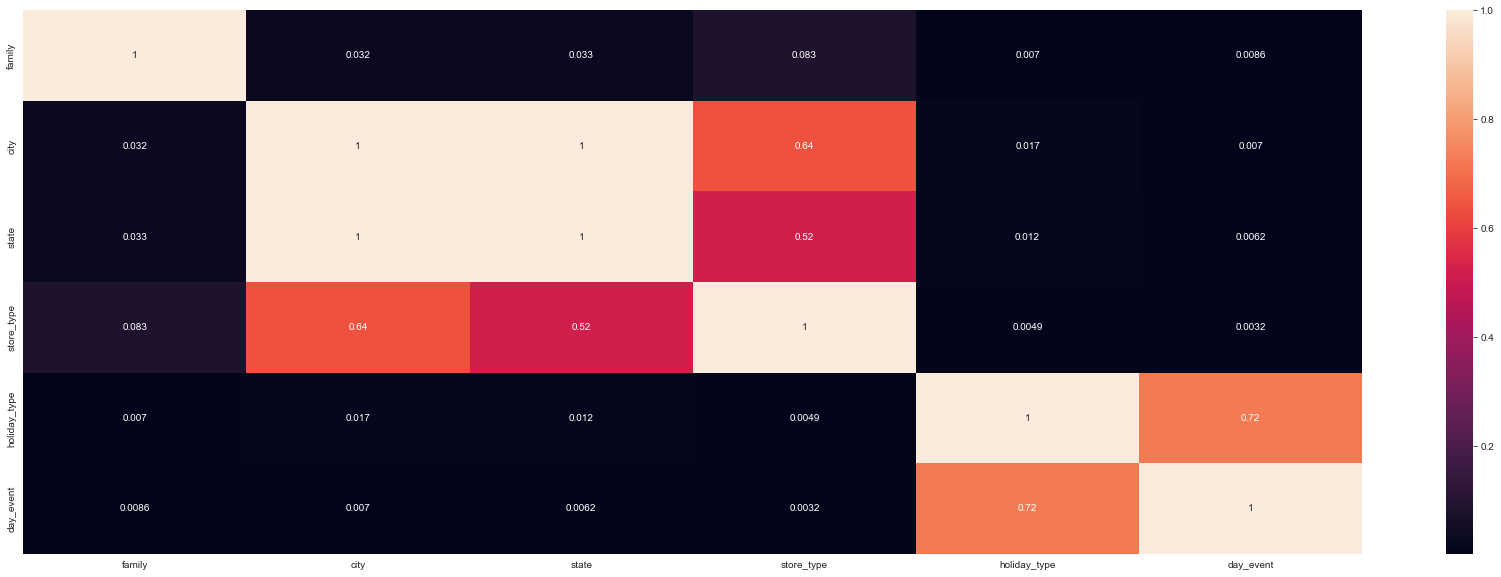

In [ ]:
# categorical data only
a = df5.select_dtypes(include='object')

# cramer's v calculus
a1 = cramer_v(a['family'],a['family'])
a2 = cramer_v(a['family'],a['city'])
a3 = cramer_v(a['family'],a['state'])
a4 = cramer_v(a['family'],a['store_type'])
a5 = cramer_v(a['family'],a['holiday_type'])
a6 = cramer_v(a['family'],a['day_event'])

b1 = cramer_v(a['city'],a['family'])
b2 = cramer_v(a['city'],a['city'])
b3 = cramer_v(a['city'],a['state'])
b4 = cramer_v(a['city'],a['store_type'])
b5 = cramer_v(a['city'],a['holiday_type'])
b6 = cramer_v(a['city'],a['day_event'])

c1 = cramer_v(a['state'],a['family'])
c2 = cramer_v(a['state'],a['city'])
c3 = cramer_v(a['state'],a['state'])
c4 = cramer_v(a['state'],a['store_type'])
c5 = cramer_v(a['state'],a['holiday_type'])
c6 = cramer_v(a['state'],a['day_event'])

d1 = cramer_v(a['store_type'],a['family'])
d2 = cramer_v(a['store_type'],a['city'])
d3 = cramer_v(a['store_type'],a['state'])
d4 = cramer_v(a['store_type'],a['store_type'])
d5 = cramer_v(a['store_type'],a['holiday_type'])
d6 = cramer_v(a['store_type'],a['day_event'])

e1 = cramer_v(a['holiday_type'],a['family'])
e2 = cramer_v(a['holiday_type'],a['city'])
e3 = cramer_v(a['holiday_type'],a['state'])
e4 = cramer_v(a['holiday_type'],a['store_type'])
e5 = cramer_v(a['holiday_type'],a['holiday_type'])
e6 = cramer_v(a['holiday_type'],a['day_event'])

f1 = cramer_v(a['day_event'],a['family'])
f2 = cramer_v(a['day_event'],a['city'])
f3 = cramer_v(a['day_event'],a['state'])
f4 = cramer_v(a['day_event'],a['store_type'])
f5 = cramer_v(a['day_event'],a['holiday_type'])
f6 = cramer_v(a['day_event'],a['day_event'])

# new dataframe
d = pd.DataFrame(
    {
        'family'       : [a1,a2,a3,a4,a5,a6],
        'city'         : [b1,b2,b3,b4,b5,b6],
        'state'        : [c1,c2,c3,c4,c5,c6],
        'store_type'   : [d1,d2,d3,d4,d5,d6],
        'holiday_type' : [e1,e2,e3,e4,e5,e6],
        'day_event'    : [f1,f2,f3,f4,f5,f6]
    }
)

d = d.set_index(d.columns)

# heatmap
sns.heatmap(d, annot=True);

In [ ]:
df5 = pd.merge(df5, outliers_family_per_year_month[['year','month','store_nbr','family','outlier_min','outlier_max','median']], how='left', on=['year','month','store_nbr','family'])
df5.to_csv('../data/processed/df5.csv',index=False)

# 6.0. Data Preparation

In [ ]:
# copy into a new dataset to keep the progress made until now
df6 = df5.copy()
#df6 = pd.read_csv('..\data\processed\df5.csv')

In [ ]:
df6['sales'] = df6.apply(lambda x: x['median'] if (x['year']==2016) & (x['month']==4) & (x['sales']>=x['outlier_max']) else x['sales'], axis=1)
df6.describe()

,store_nbr,sales,onpromotion,store_cluster,dcoilwtico,transactions,day,day_of_year,month,year,week_of_year,day_of_week,earthquake,worldcup,is_promo,outlier_min,outlier_max,median
count,2061758.000,2061758.000,2061758.000,2061758.000,2061758.000,2061758.000,2061758.000,2061758.000,2061758.000,2061758.000,2061758.000,2061758.000,2061758.000,2061758.000,2061758.000,2061758.000,2061758.000,2061758.000
mean,27.045,520.451,3.788,8.578,63.541,2.891,15.660,176.561,6.310,2015.081,25.623,2.998,0.022,0.007,0.297,-170.046,1186.811,480.279
std,15.820,1292.756,14.587,4.698,24.567,72.946,8.784,103.568,3.392,1.318,14.829,2.001,0.148,0.085,0.457,729.767,2903.793,1121.979
min,1.000,0.122,0.000,1.000,26.190,0.000,1.000,1.000,1.000,2013.000,1.000,0.000,0.000,0.000,0.000,-17800.250,1.000,0.689
25%,13.000,9.000,0.000,4.000,45.598,0.000,8.000,87.000,3.000,2014.000,13.000,1.000,0.000,0.000,0.000,-98.000,32.750,9.000
50%,27.000,78.412,0.000,9.000,50.974,0.000,16.000,174.000,6.000,2015.000,25.000,3.000,0.000,0.000,0.000,-19.000,217.500,77.000
75%,41.000,388.000,1.000,13.000,93.340,0.000,23.000,264.000,9.000,2016.000,38.000,5.000,0.000,0.000,1.000,-5.000,891.782,365.944
max,54.000,124717.000,741.000,17.000,110.620,1964.905,31.000,366.000,12.000,2017.000,53.000,6.000,1.000,1.000,1.000,4868.000,41789.000,15000.500


## 6.1. Standardization

In [ ]:
ss1 = StandardScaler()
ss2 = StandardScaler()

# onpromotion
df6['onpromotion']  = ss1.fit_transform(df6[['onpromotion']].values)
pickle.dump(ss1, open('../parameters/onpromotion_std.pkl','wb'))

# transactions
df6['transactions'] = ss2.fit_transform(df6[['transactions']].values)
pickle.dump(ss2, open('../parameters/transactions_std.pkl','wb'))

## 6.2. Rescaling

In [ ]:
mms1 = MinMaxScaler()
mms2 = MinMaxScaler()
mms3 = MinMaxScaler()

# store_nbr
df6['store_nbr'] = mms1.fit_transform(df6[['store_nbr']].values)
pickle.dump(mms1, open('../parameters/store_nbr_scaler.pkl','wb'))

# store_cluster
df6['store_cluster'] = mms2.fit_transform(df6[['store_cluster']].values)
pickle.dump(mms2, open('../parameters/store_cluster_scaler.pkl','wb'))

# oil
df6['dcoilwtico'] = mms3.fit_transform(df6[['dcoilwtico']].values)
pickle.dump(mms3, open('../parameters/dcoilwtico_scaler.pkl','wb'))

## 6.3. Transformation

### 6.3.1. Encoding

In [ ]:
# holiday_type
df6 = pd.get_dummies( df6, prefix=['holiday_type'], columns=['holiday_type'] )

# day_event
df6 = pd.get_dummies( df6, prefix=['day_event'], columns=['day_event'] )

# city
freq_encoder_city = df6.groupby('city').size() / len(df6)
df6['city'] = df6['city'].apply(lambda x: freq_encoder_city[x])
pickle.dump(freq_encoder_city, open('../parameters/city_encoding.pkl','wb'))

# state
freq_encoder_state = df6.groupby('state').size() / len(df6)
df6['state'] = df6['state'].apply(lambda x: freq_encoder_state[x])
pickle.dump(freq_encoder_state, open('../parameters/state_encoding.pkl','wb'))

# store_type
freq_encoder_store_type = df6.groupby('store_type').size() / len(df6)
df6['store_type'] = df6['store_type'].apply(lambda x: freq_encoder_store_type[x])
pickle.dump(freq_encoder_store_type, open('../parameters/store_type_encoding.pkl','wb'))

# family
label_encoder_family = LabelEncoder()
df6['family'] = label_encoder_family.fit_transform(df6[['family']].values)
pickle.dump(label_encoder_family, open('../parameters/family_encoding.pkl','wb'))

### 6.3.2. Response Variable Transformation

In [ ]:
# sale
df6['sales'] = np.log1p(df6['sales'])

### 6.3.3. Nature Transformation

In [ ]:
# day
df6['day_sin'] = df6['day'].apply(lambda x: np.sin( x * ( 2 * np.pi / 30 ) ) )
df6['day_cos'] = df6['day'].apply(lambda x: np.cos( x * ( 2 * np.pi / 30 ) ) )

# day_of_week
df6['day_of_week_sin'] = df6['day_of_week'].apply(lambda x: np.sin( x * ( 2 * np.pi / 7 ) ) )
df6['day_of_week_cos'] = df6['day_of_week'].apply(lambda x: np.cos( x * ( 2 * np.pi / 7 ) ) )

# day_of_year
df6['day_of_year_sin'] = df6['day_of_year'].apply(lambda x: np.sin( x * ( 2 * np.pi / 365 ) ) )
df6['day_of_year_cos'] = df6['day_of_year'].apply(lambda x: np.cos( x * ( 2 * np.pi / 365 ) ) )

# month
df6['month_sin'] = df6['month'].apply(lambda x: np.sin( x * ( 2 * np.pi / 12 ) ) )
df6['month_cos'] = df6['month'].apply(lambda x: np.cos( x * ( 2 * np.pi / 12 ) ) )

# week_of_year
df6['week_of_year_sin'] = df6['week_of_year'].apply(lambda x: np.sin( x * ( 2 * np.pi / 52 ) ) )
df6['week_of_year_cos'] = df6['week_of_year'].apply(lambda x: np.cos( x * ( 2 * np.pi / 52 ) ) )

df6 = df6.drop(['year_week', 'week_of_year', 'day', 'month', 'day_of_week','day_of_year'],axis=1)

In [ ]:
df6.to_csv('../data/processed/df6.csv',index=False)

# 7.0. Feature Selection

In [ ]:
# copy into a new dataset to keep the progress made until now
df7 = df6.copy()
#df7 = pd.read_csv('..\data\processed\df6.csv')

## 7.1. Split dataframe into training and test dataset

In [ ]:
# training dataset - all sales until the last 6 weeks
X_train = df7[df7['date'] < '2017-08-01']
y_train = X_train['sales']
y_train.to_csv('../data/processed/y_train.csv', index=False)

# test dataset - last 6 weeks of sales
X_test = df7[df7['date'] >= '2017-08-01']
y_test = X_test['sales']
y_test.to_csv('../data/processed/y_test.csv', index=False)

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))
print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2017-07-31 00:00:00

Test Min Date: 2017-08-01 00:00:00
Test Max Date: 2017-08-15 00:00:00


## 7.2. Boruta as Feature Selector

In [ ]:
# training and test dataset for Boruta
X_train_n = X_train.drop(['sales','date'], axis=1).values
y_train_n = y_train.values.ravel()

# define RandomForestRegressor
rf = RandomForestRegressor( n_jobs=-1 )

# define Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=43).fit(X_train_n, y_train_n)

### 7.2.1 Features from Boruta

In [ ]:
cols_selected = boruta.support_.tolist()
 
# selected boruta
X_train_fs = X_train.drop(['date','sales'],axis=1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
 
# not selected boruta
cols_not_selected_boruta = np.setdiff1d(X_train_fs.columns,cols_selected_boruta).tolist()

## 7.3. Manual Feature Selection

In [ ]:
cols_selected_boruta = ['store_nbr', 'family', 'store_type', 'store_cluster',
 'year', 'city', 'state', 'day_sin', 'day_cos', 'onpromotion', 'dcoilwtico',
 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
 'week_of_year_sin', 'week_of_year_cos']

cols_not_selected_boruta = ['earthquake', 'transactions', 'worldcup',
 'day_event_Additional', 'day_event_Bridge', 'day_event_Event',
 'day_event_Holiday', 'day_event_Transfer', 'day_event_Work Day',
 'day_event_usual_day','holiday_type_national', 'holiday_type_regional',
 'holiday_type_usual_day']

# columns to add
feat_to_add = ['date','sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 8.0. Machine Learning Modelling

In [ ]:
#x_train    = pd.read_csv('../data/processed/x_train.csv')
#x_test     = pd.read_csv('../data/processed/x_test.csv')
#y_train    = pd.read_csv('../data/processed/y_train.csv')
#y_test     = pd.read_csv('../data/processed/y_test.csv')
#x_training = pd.read_csv('../data/processed/x_training.csv')
#x_training['date'] = pd.to_datetime(x_training['date'])

In [ ]:
# split between train and test dataset
x_train = X_train[cols_selected_boruta]
x_train.to_csv('../data/processed/x_train.csv', index=False)

x_test = X_test[cols_selected_boruta]
x_test.to_csv('../data/processed/x_test.csv', index=False)

x_training = X_train[cols_selected_boruta_full]
x_training.to_csv('../data/processed/x_training.csv', index=False)

## 8.1. Average Model

In [ ]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['family','store_nbr','sales']].groupby(['store_nbr','family']).mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on=['store_nbr','family'])
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', y_test, yhat_baseline )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,99.423,0.357,316.842


## 8.2. Linear Regression Model

In [ ]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error('Linear Regression', y_test, yhat_lr )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,7365.263,5.525,212832.607


### 8.2.1. Cross-validation

In [ ]:
cv_lr_result = cross_validation(x_training, 5, 'Linear Regression', lr)
cv_lr_result

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,932010233516.83 +/- 1850313185973.14,203312107.1 +/- 404061930.17,141676368634016.2 +/- 281281479103972.62


## 8.3. Linear Regression Regularized Model - Lasso

In [ ]:
# model
lrr = Lasso().fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error('Linear Regression - Lasso', y_test, yhat_lrr )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,528.397,7.615,1410.536


### 8.3.1 Cross-validation

In [ ]:
cv_lrr_result = cross_validation(x_training, 5, 'Lasso', lrr)
cv_lrr_result

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,546.42 +/- 9.26,8.15 +/- 0.09,1508.84 +/- 43.57


## 8.4. XGBoost Regressor

In [ ]:
# model
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror').fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )
pickle.dump(model_xgb, open('../models/xgb.pkl', 'wb'))

# performance
xgb_result = ml_error('XGBoost', y_test, yhat_xgb )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost,103.326,0.420,322.669


### 8.4.1. Cross-validation

In [ ]:
cv_xgb_result = cross_validation(x_training, 5, 'XGBoost', model_xgb)
cv_xgb_result

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost,116.29 +/- 9.0,0.43 +/- 0.02,409.47 +/- 45.16


## 8.5. Random Forest Regressor

In [ ]:
# model
rf = RandomForestRegressor().fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error('Random Forest Regression', y_test, yhat_rf )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regression,81.901,0.354,288.977


### 8.5.1. Cross-validation

In [ ]:
cv_rf_result = cross_validation(x_training, 5, 'Random Forest', rf)
cv_rf_result

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,74.21 +/- 9.94,0.35 +/- 0.01,272.04 +/- 44.85


## 8.6. Compare Models' Performance

In [ ]:
# merge results from each model
modelling_result = pd.concat( [ baseline_result, lr_result, lrr_result, rf_result, xgb_result ] )
modelling_result.reset_index(drop=True).sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
3,Random Forest Regression,81.901,0.354,288.977
4,XGBoost,108.932,0.425,343.279
0,Average Model,261.837,0.997,804.361
2,Linear Regression - Lasso,528.397,7.615,1410.536
1,Linear Regression,7365.263,5.525,212832.607


### 8.6.1. Cross-validation

In [ ]:
cv_modelling_result = pd.concat( [ cv_lr_result, cv_lrr_result, cv_rf_result, cv_xgb_result ] )
cv_modelling_result.reset_index(drop=True).sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,932010233516.83 +/- 1850313185973.14,203312107.1 +/- 404061930.17,141676368634016.2 +/- 281281479103972.62
1,Lasso,546.42 +/- 9.26,8.15 +/- 0.09,1508.84 +/- 43.57
2,Random Forest,74.21 +/- 9.94,0.35 +/- 0.01,272.04 +/- 44.85
3,XGBoost,116.29 +/- 9.0,0.43 +/- 0.02,409.47 +/- 45.16


In [ ]:
modelling_result.to_csv('../data/interim/modelling_result.csv',index=False)
cv_modelling_result.to_csv('../data/interim/cv_modelling_result.csv',index=False)

# 9. Hyperparameter Fine Tunning

## 9.1. Random Search

In [ ]:
param = {
    'n_estimators': [300, 500, 1000, 1500, 2000],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
}

max_eval = 10

In [ ]:
final_result = pd.DataFrame()
p = []

for i in range( max_eval ):
    # choose values for parameters randomly
    hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
    print('{} > {}'.format(i, hp))
    p.append('{} > {}'.format(i+1, hp))

    # model
    model_xgb = xgb.XGBRegressor( objective = 'reg:squarederror',
                               n_estimators = hp['n_estimators'],
                               eta = hp['eta'],
                               max_depth = hp['max_depth'],
                               subsample = hp['subsample'],
                               colsample_bytree = hp['colsample_bytree'],
                               min_child_weight= hp['min_child_weight'] )
  
    # performance
    result = cross_validation(x_training, 5, 'XGBoost', model_xgb)
    final_result = pd.concat([final_result, result])  

final_result

0 > {'n_estimators': 1500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 15}
1 > {'n_estimators': 2000, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 8}
2 > {'n_estimators': 1500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 8}
3 > {'n_estimators': 1000, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 15}
4 > {'n_estimators': 1000, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 15}
5 > {'n_estimators': 1500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 8}
6 > {'n_estimators': 2000, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 3}
7 > {'n_estimators': 2000, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 8}
8 > {'n_estimators': 

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost,214.82 +/- 17.99,0.51 +/- 0.04,721.3 +/- 56.27
0,XGBoost,184.24 +/- 15.41,0.48 +/- 0.03,637.93 +/- 37.55
0,XGBoost,181.5 +/- 13.52,0.46 +/- 0.03,636.29 +/- 39.22
0,XGBoost,249.22 +/- 18.42,0.71 +/- 0.03,790.86 +/- 63.35
0,XGBoost,269.03 +/- 17.79,0.81 +/- 0.04,861.77 +/- 59.42
0,XGBoost,217.98 +/- 19.68,0.56 +/- 0.03,696.26 +/- 61.39
0,XGBoost,245.31 +/- 16.14,0.67 +/- 0.03,767.84 +/- 54.5
0,XGBoost,244.6 +/- 17.65,0.67 +/- 0.03,767.11 +/- 59.91
0,XGBoost,215.03 +/- 19.44,0.54 +/- 0.03,717.39 +/- 56.81
0,XGBoost,241.16 +/- 18.05,0.67 +/- 0.03,780.7 +/- 62.99


In [ ]:
final_result.reset_index(drop=True).to_csv('../data/interim/final_result.csv', index=False)
pickle.dump(p, open('../parameters/parameters_fine_tuning.pkl', 'wb'))

## 9.2. Final Model

In [ ]:
param_tuned = {
    'n_estimators': 1500,
    'eta': 0.03,
    'max_depth': 9,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 8
}

In [ ]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective = 'reg:squarederror',
                              n_estimators = param_tuned['n_estimators'],
                              eta = param_tuned['eta'],
                              max_depth = param_tuned['max_depth'],
                              subsample = param_tuned['subsample'],
                              colsample_bytree = param_tuned['colsample_bytree'],
                              min_child_weight= param_tuned['min_child_weight'] ).fit( x_train, y_train )

# save/load model externally
pickle.dump(model_xgb_tuned, open('../models/model_tuned_favorita.pkl', 'wb'))

In [ ]:
model_xgb_tuned = pickle.load(open('../models/model_tuned_favorita.pkl', 'rb'))
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )
pickle.dump(yhat_xgb_tuned, open('../data/processed/yhat_xgb_tuned.pkl', 'wb'))

# performance
xgb_result_tuned = ml_error('XGBoost', y_test, yhat_xgb_tuned )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost,74.326,0.346,234.629


In [ ]:
model_xgb_tuned = pickle.load(open('../models/model_tuned_favorita.pkl', 'rb'))
final_model_cv = cross_validation(x_training, 5, 'XGBoost', model_xgb_tuned)
final_model_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost,75.91 +/- 10.2,0.35 +/- 0.01,267.91 +/- 42.75


# 10. Error Interpretation

In [ ]:
sales_predictions = pickle.load(open('../data/processed/yhat_xgb_tuned.pkl', 'rb'))

df11 = pd.read_csv('../data/processed/df6.csv')
df11['date'] = pd.to_datetime(df11['date'])
X_test = df11[df11['date'] >= '2017-08-01']

df11 = X_test[cols_selected_boruta_full].copy()

In [ ]:
# rescale result feature back from log
df11['sales'] = np.expm1(df11['sales'])
df11['predictions'] = np.expm1( sales_predictions )

# restoring encoded/scaled data
df11 = df11.drop(columns=['year','day_sin','day_cos','day_of_week_sin','day_of_week_cos','month_sin',
                            'month_cos','week_of_year_sin','week_of_year_cos'])

# standardization
onpromotion_std = pickle.load( open('../parameters/onpromotion_std.pkl', 'rb') )
df11['onpromotion'] = onpromotion_std.inverse_transform(df11[['onpromotion']])

# rescale
store_nbr_scl = pickle.load( open('../parameters/store_nbr_scaler.pkl', 'rb') )
df11['store_nbr'] = store_nbr_scl.inverse_transform(df11[['store_nbr']])

store_cluster_scl = pickle.load( open('../parameters/store_cluster_scaler.pkl', 'rb') )
df11['store_cluster'] = store_cluster_scl.inverse_transform(df11[['store_cluster']])

dcoilwtico_scl = pickle.load( open('../parameters/dcoilwtico_scaler.pkl', 'rb') )
df11['dcoilwtico'] = dcoilwtico_scl.inverse_transform(df11[['dcoilwtico']])

# encode
freq_encoder_city = pickle.load( open('../parameters/city_encoding.pkl', 'rb') )
df11['city'] = df11['city'].apply(lambda x: ''.join(list(freq_encoder_city[freq_encoder_city == x].index)))

freq_encoder_state = pickle.load( open('../parameters/state_encoding.pkl', 'rb') )
df11['state'] = df11['state'].apply(lambda x: ''.join(list(freq_encoder_state[freq_encoder_state == x].index)))

freq_encoder_store_type = pickle.load( open('../parameters/store_type_encoding.pkl', 'rb') )
df11['store_type'] = df11['store_type'].apply(lambda x: ''.join(list(freq_encoder_store_type[round(freq_encoder_store_type,3) == round(x,3)].index)))

label_encoder_family = pickle.load( open('../parameters/family_encoding.pkl', 'rb') )
df11['family'] = label_encoder_family.inverse_transform(df11[['family']])

df11.to_csv('../data/processed/df11.csv', index=False)

In [ ]:
df11.head()

,store_nbr,family,store_type,store_cluster,city,state,onpromotion,dcoilwtico,date,sales,predictions
2038931,1.000,AUTOMOTIVE,D,13.000,Quito,Pichincha,0.000,49.190,2017-08-01,5.000,4.412
2038932,1.000,BEAUTY,D,13.000,Quito,Pichincha,0.000,49.190,2017-08-01,4.000,3.599
2038933,1.000,BEVERAGES,D,13.000,Quito,Pichincha,26.000,49.190,2017-08-01,2627.000,2163.247
2038934,1.000,BREAD/BAKERY,D,13.000,Quito,Pichincha,0.000,49.190,2017-08-01,373.709,404.472
2038935,1.000,CELEBRATION,D,13.000,Quito,Pichincha,0.000,49.190,2017-08-01,11.000,11.690


## 10.1. Machine Learning Performance

In [ ]:
predictions = pd.read_csv('../data/processed/df11.csv')
predictions['error'] = predictions['sales'] - predictions['predictions']
predictions['error_rate'] = predictions['predictions'] / predictions['sales']

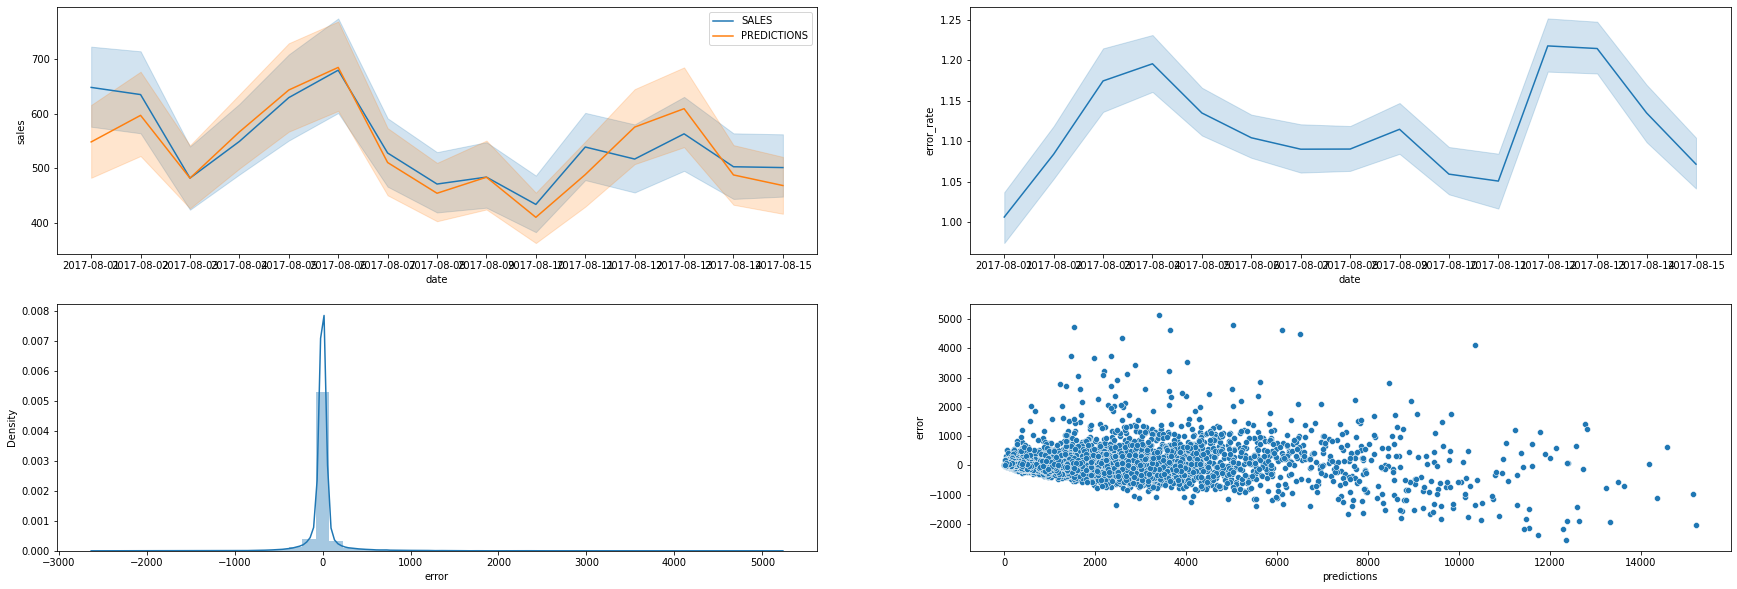

In [ ]:
plt.subplot(2,2,1)
sns.lineplot(data=predictions, x='date', y='sales', label='SALES')
sns.lineplot(data=predictions, x='date', y='predictions', label='PREDICTIONS')
plt.xticks(rotation=60);

plt.subplot(2,2,2)
sns.lineplot(data=predictions, x='date', y='error_rate')
plt.xticks(rotation=60);

plt.subplot(2,2,3)
sns.distplot(predictions['error'])

plt.subplot(2,2,4)
sns.scatterplot(data=predictions, x='predictions', y='error');

## 10.2. Business Performance

In [ ]:
# sum of predictions
_predictions = predictions[['predictions','store_nbr','family']].groupby(['store_nbr','family']).sum().reset_index()

# MAE and MAPE
predictions_aux1 = predictions[['store_nbr','family','sales','predictions']].groupby(['store_nbr','family']).apply(lambda x: mean_absolute_error( x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
predictions_aux2 = predictions[['store_nbr','family','sales','predictions']].groupby(['store_nbr','family']).apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})
predictions_aux3 = pd.merge(predictions_aux1, predictions_aux2, how='inner', on=['store_nbr','family'])
performance = pd.merge(_predictions, predictions_aux3, how='inner', on=['store_nbr','family'])

# scenarios
performance['worst_scenario'] = performance['predictions'] - performance['MAE']
performance['best_scenario']  = performance['predictions'] + performance['MAE']

# order columns
performance.head(50)

,store_nbr,family,predictions,MAE,MAPE,worst_scenario,best_scenario
0,1.000,AUTOMOTIVE,55.843,2.064,0.644,53.779,57.907
1,1.000,BEAUTY,60.808,1.530,0.560,59.278,62.337
2,1.000,BEVERAGES,26589.531,290.963,0.149,26298.568,26880.493
3,1.000,BREAD/BAKERY,5800.661,80.524,0.335,5720.137,5881.185
4,1.000,CELEBRATION,174.178,4.638,0.835,169.540,178.816
5,1.000,CLEANING,9716.532,82.506,0.189,9634.027,9799.038
6,1.000,DAIRY,9874.856,97.998,0.187,9776.858,9972.854
7,1.000,DELI,1783.745,14.640,0.152,1769.104,1798.385
8,1.000,EGGS,1889.458,10.367,0.098,1879.091,1899.825
9,1.000,FROZEN FOODS,1458.931,32.384,0.256,1426.547,1491.314


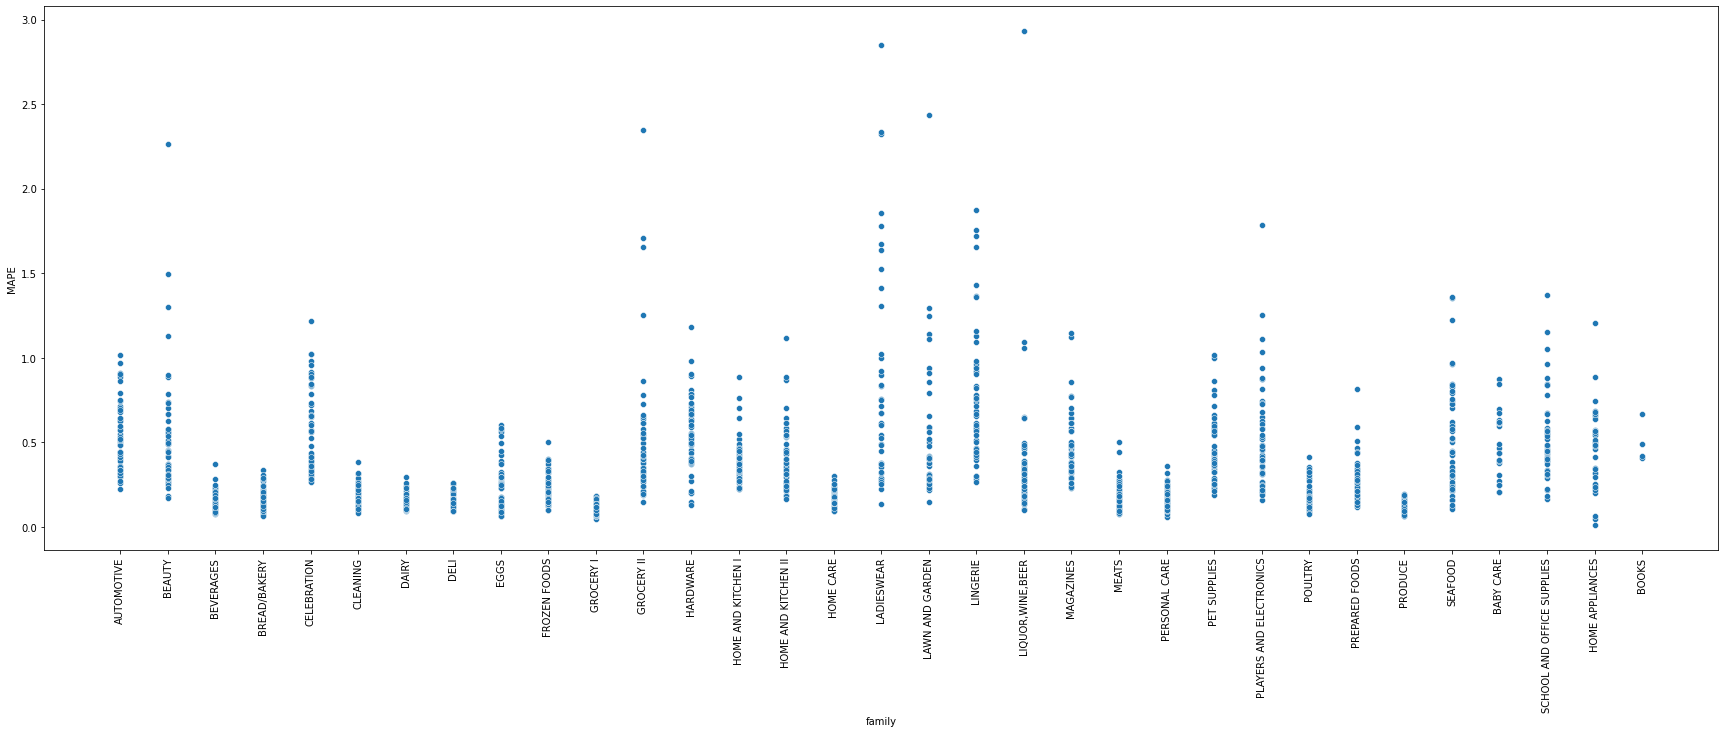

In [ ]:
sns.scatterplot(data=performance,x='family', y='MAPE')
plt.xticks(rotation=90);

## 10.3. Total Performance

In [ ]:
tp = performance[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x),axis=0).reset_index().rename(columns={'index':'Scenario', 0:'Values'})
tp['Values'] = tp['Values'].map('{:,.2f}'.format)
tp

,Scenario,Values
0,predictions,"12,201,257.08"
1,worst_scenario,"12,087,996.99"
2,best_scenario,"12,314,517.17"


# 11. Final model - Test dataset

In [ ]:
cols_selected_boruta = ['store_nbr', 'family', 'store_type', 'store_cluster',
 'year', 'city', 'state', 'day_sin', 'day_cos', 'onpromotion', 'dcoilwtico',
 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
 'week_of_year_sin', 'week_of_year_cos']

param_tuned = {
    'n_estimators': 1500,
    'eta': 0.03,
    'max_depth': 9,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 8
}

df = pd.read_csv('../data/processed/df6.csv')
final_y = df['sales'].copy()
final_x = df[cols_selected_boruta]

# model
model_final = xgb.XGBRegressor( objective = 'reg:squarederror',
                              n_estimators = param_tuned['n_estimators'],
                              eta = param_tuned['eta'],
                              max_depth = param_tuned['max_depth'],
                              subsample = param_tuned['subsample'],
                              colsample_bytree = param_tuned['colsample_bytree'],
                              min_child_weight= param_tuned['min_child_weight'] ).fit( final_x, final_y )

# save/load model externally
pickle.dump(model_final, open('../models/model_final_favorita.pkl', 'wb'))


In [ ]:
df_test_raw = pd.read_csv('../data/raw/test.csv')
df_stores_raw = pd.read_csv('../data/raw/stores.csv')
df_oil_raw = pd.read_csv('../data/raw/oil.csv')
df_test_raw = pd.merge(df_test_raw, df_oil_raw, how='left', on='date')
df_test_raw = pd.merge(df_test_raw, df_stores_raw, how='left', on='store_nbr')
df_test = df_test_raw.rename(columns={'type':'store_type','cluster':'store_cluster'})

df_test['date'] = pd.to_datetime(df_test['date'])

# setando colunas de datas
df_test['day']          = df_test['date'].dt.day
df_test['day_of_year']  = df_test['date'].dt.dayofyear
df_test['month']        = df_test['date'].dt.month
df_test['year']         = df_test['date'].dt.year
df_test['week_of_year'] = df_test['date'].dt.weekofyear
df_test['day_of_week']  = df_test['date'].dt.dayofweek #The day of the week with Monday=0, Sunday=6.

# finais de semana e feriados não há registro de cotação. utilizando a média da semana para preencher esses NAs
aux = df_test[['date','dcoilwtico']].copy()
aux = aux.drop_duplicates(subset='date').reset_index(drop=True)
aux['year_week'] = aux['date'].dt.strftime('%Y-%U')
aux2 = aux[['year_week','dcoilwtico']].groupby('year_week').mean().reset_index()
#excepcionalmente, a virada de 2015/2016 nao segue o padrao das demais pois a semana fica quebrada
aux2.loc[aux2['year_week'] == '2016-00', 'dcoilwtico'] = aux2.loc[aux2['year_week'] == '2015-52', 'dcoilwtico'].values
aux = pd.merge(aux, aux2, how='left', on='year_week')
aux = aux.drop(columns=['dcoilwtico_x','year_week']).rename(columns={'dcoilwtico_y':'dcoilwtico'})
df_test = pd.merge(df_test,aux, how='left', on='date')
df_test['dcoilwtico_x'] = df_test[['dcoilwtico_x','dcoilwtico_y']].apply(lambda x: x['dcoilwtico_y'] if pd.isna(x['dcoilwtico_x']) else x['dcoilwtico_x'], axis = 1 )

# removendo colunas extras criadas para tratamento dos NAs
df_test = df_test.drop('dcoilwtico_y', axis=1).rename(columns={'dcoilwtico_x':'dcoilwtico'})

ss1                     = pickle.load(open('../parameters/onpromotion_std.pkl','rb'))
mms1                    = pickle.load(open('../parameters/store_nbr_scaler.pkl','rb'))
mms2                    = pickle.load(open('../parameters/store_cluster_scaler.pkl','rb'))
mms3                    = pickle.load(open('../parameters/dcoilwtico_scaler.pkl','rb'))
freq_encoder_city       = pickle.load(open('../parameters/city_encoding.pkl','rb'))
freq_encoder_state      = pickle.load(open('../parameters/state_encoding.pkl','rb'))
freq_encoder_store_type = pickle.load(open('../parameters/store_type_encoding.pkl','rb'))
label_encoder_family    = pickle.load(open('../parameters/family_encoding.pkl','rb'))

# onpromotion
df_test['onpromotion']  = ss1.transform(df_test[['onpromotion']].values)
# store_nbr
df_test['store_nbr'] = mms1.transform(df_test[['store_nbr']].values)
# store_cluster
df_test['store_cluster'] = mms2.transform(df_test[['store_cluster']].values)
# oil
df_test['dcoilwtico'] = mms3.transform(df_test[['dcoilwtico']].values)
# city
df_test['city'] = df_test['city'].apply(lambda x: freq_encoder_city[x])
# state
df_test['state'] = df_test['state'].apply(lambda x: freq_encoder_state[x])
# store_type
df_test['store_type'] = df_test['store_type'].apply(lambda x: freq_encoder_store_type[x])
# family
df_test['family'] = label_encoder_family.transform(df_test[['family']].values)

# day
df_test['day_sin'] = df_test['day'].apply(lambda x: np.sin( x * ( 2 * np.pi / 30 ) ) )
df_test['day_cos'] = df_test['day'].apply(lambda x: np.cos( x * ( 2 * np.pi / 30 ) ) )

# day_of_week
df_test['day_of_week_sin'] = df_test['day_of_week'].apply(lambda x: np.sin( x * ( 2 * np.pi / 7 ) ) )
df_test['day_of_week_cos'] = df_test['day_of_week'].apply(lambda x: np.cos( x * ( 2 * np.pi / 7 ) ) )

# day_of_year
df_test['day_of_year_sin'] = df_test['day_of_year'].apply(lambda x: np.sin( x * ( 2 * np.pi / 365 ) ) )
df_test['day_of_year_cos'] = df_test['day_of_year'].apply(lambda x: np.cos( x * ( 2 * np.pi / 365 ) ) )

# month
df_test['month_sin'] = df_test['month'].apply(lambda x: np.sin( x * ( 2 * np.pi / 12 ) ) )
df_test['month_cos'] = df_test['month'].apply(lambda x: np.cos( x * ( 2 * np.pi / 12 ) ) )

# week_of_year
df_test['week_of_year_sin'] = df_test['week_of_year'].apply(lambda x: np.sin( x * ( 2 * np.pi / 52 ) ) )
df_test['week_of_year_cos'] = df_test['week_of_year'].apply(lambda x: np.cos( x * ( 2 * np.pi / 52 ) ) )

df_test = df_test[cols_selected_boruta]
df_test.to_csv('../data/processed/df_test.csv', index=False)

In [ ]:
model_final = pickle.load(open('../models/model_final_favorita.pkl', 'rb'))
df_test = pd.read_csv('../data/processed/df_test.csv')

final_predictions = model_final.predict( df_test )
pickle.dump(final_predictions, open('../data/processed/final_predictions.pkl', 'wb'))

In [ ]:
df_predicted = pd.read_csv('../data/raw/test.csv')
final_predictions = pickle.load(open('../data/processed/final_predictions.pkl', 'rb'))

df_predicted['predictions'] = np.expm1(final_predictions)
df_predicted

,id,date,store_nbr,family,onpromotion,predictions
0,3000888,2017-08-16,1,AUTOMOTIVE,0,4.526
1,3000889,2017-08-16,1,BABY CARE,0,1.200
2,3000890,2017-08-16,1,BEAUTY,2,7.082
3,3000891,2017-08-16,1,BEVERAGES,20,2374.790
4,3000892,2017-08-16,1,BOOKS,0,1.910
...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1,422.959
28508,3029396,2017-08-31,9,PREPARED FOODS,0,98.788
28509,3029397,2017-08-31,9,PRODUCE,1,1446.636
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,79.834


In [ ]:
# submission
df_predicted[['id','predictions']].rename(columns={'predictions':'sales'}).to_csv('../data/processed/submission.csv', index=False)
df_predicted.to_csv('../data/processed/results.csv', index=False)

# 12. Deploy to production

## 12.1. API Handler

In [ ]:
from flask import Flask, request, Response, send_file
from api.favorita.Favorita import Favorita
from api.favorita.Visualization import Visualization
import pandas as pd
import pickle

# loading model
model = pickle.load( open('../models/model_favorita.pkl', 'rb') )

app = Flask(__name__)

@app.route( '/favorita/predict', methods=['POST'] )
def favorita_predict():

    print('start')
    
    test_json = request.get_json()
    print('get_json')
    
    if test_json: #there's data

        test_raw = pd.DataFrame(test_json)

        # instantiate rossmann class
        pipeline = Favorita()
        
        # data cleaning
        data_cleaned = pipeline.data_cleaning(test_raw)
        print('data_cleaned')

        # feature engineering
        data_transformed = pipeline.feature_engineering(data_cleaned)
        print('data_transformed')

        # data preparation
        data_prediction = pipeline.data_preparation(data_transformed)
        print('data_prediction')

        # prediction
        data_predicted = pipeline.prediction(model, test_raw, data_prediction)
        print('data_predicted')

        return data_predicted
        
    else:
        return Response('{}',status=200,mimetype='application/json')    

@app.route( '/favorita/viz', methods=['POST'] )
def favorita_visualization():

    raw_data_json = request.get_json()

    if raw_data_json:

        data_json = pd.DataFrame(raw_data_json)
    
        pipeline = Visualization()

        pipeline.data_transformation(data_json)

        pipeline.plots()

        return send_file('./plots.png', mimetype='image/png')

    else:
        return Response('{}',status=200,mimetype='application/json')      

if __name__ == '__main__':
    app.run('0.0.0.0')

## 12.2. Telegram BOT Handler

In [ ]:
from flask import Response, request, Flask
import pandas as pd
import requests
import json
import os

TOKEN = 'token'
REPLY_OPTIONS = ('See details','Search other store', 'Leave')

def get_message():
    url = 'https://api.telegram.org/bot{}/getUpdates'.format(TOKEN)
    r = requests.post( url, data={'offset': '-1' })

    return r.json()

def parse_message( message ):    

    chat_id = message['message']['chat']['id']
    text = message['message']['text']

    text = text.replace('/','')

    try:
        text = int(text)

    except ValueError:
        if REPLY_OPTIONS.__contains__(text):
            text
        elif text != 'start':
            text = 'error'
        else: text

    return chat_id, text

def load_dataset( store_id ):  

    df_test_raw   = pd.read_csv('../data/test.csv')
    df_stores_raw = pd.read_csv('../data/stores.csv')
    df_oil_raw    = pd.read_csv('../data/oil.csv')
    
    data = pd.merge(df_test_raw, df_oil_raw, how='left', on='date')
    data = pd.merge(data, df_stores_raw, how='left', on='store_nbr')
    data = data.rename(columns={'type':'store_type','cluster':'store_cluster'})

    # choose store for prediction
    data = data[data['store_nbr']==store_id]

    if data.empty:
        data = 'error'
    else:
        # convert Dataframe to json
        data = json.dumps(data.to_dict(orient='records'))

    return data

def predict( data ):
    
    # API call
    url = 'https://favoritasales.herokuapp.com/predict'
    header = {'Content-type': 'application/json'}

    r = requests.post(url, data=data, headers=header)

    return pd.DataFrame(r.json(), columns=r.json()[0].keys())

def plots( data ):    
    # API call
    url = 'https://favoritasales.herokuapp.com/viz'
    header = {'Content-type': 'application/json'}

    r = requests.post(url, data=data, headers=header)

    file = open('../reports/figures/plots.png', 'wb')
    file.write(r.content)
    file.close()

    return None

def send_message( text, chat_id ): 
    payload = { 'chat_id': chat_id, 'text': text }    

    url = 'https://api.telegram.org/bot{}/sendMessage'.format(TOKEN)
    r = requests.post( url, data=payload )

    return None

def send_photo( chat_id ):
    payload = {
        'chat_id': chat_id,        
        'caption': "Here's detailed info"
    }

    file = {
        'photo': open('../reports/figures/plots.png', 'rb')
    }

    url = 'https://api.telegram.org/bot{}/sendPhoto'.format(TOKEN)
    r = requests.post( url, data=payload, files=file )

    return None

def reply_message( chat_id ):
    # try:
    header = {'Content-type': 'application/json'}
    
    payload = {'chat_id': chat_id, 'text': 'Select an option below',
                'reply_markup': { 'keyboard':
                                [[{'text':REPLY_OPTIONS[0]}],
                                    [{'text':REPLY_OPTIONS[1]}],
                                    [{'text':REPLY_OPTIONS[2]}]],
                                    'resize_keyboard': True,
                                    'one_time_keyboard':True }}

    data = json.dumps(payload)

    url = 'https://api.telegram.org/bot{}/sendMessage'.format(TOKEN)
    r = requests.post( url, headers=header, data=data)

    return r.json()

def reply_image( chat_id ):
    # try:
    header = {'Content-type': 'application/json'}
    
    payload = {'chat_id': chat_id, 'text': 'Select an option below',
                'reply_markup': { 'keyboard':
                                [[{'text':REPLY_OPTIONS[1]}],
                                    [{'text':REPLY_OPTIONS[2]}]],
                                    'resize_keyboard': True,
                                    'one_time_keyboard':True }}

    data = json.dumps(payload)

    url = 'https://api.telegram.org/bot{}/sendMessage'.format(TOKEN)
    r = requests.post( url, headers=header, data=data)

    return r.json()

# API initialize
app = Flask( __name__ )
@app.route('/',methods=['GET','POST'])

def index():  

    if request.method == 'POST':

        message = request.get_json() 
        
        chat_id, store_id = parse_message(message)

        if str(store_id).isnumeric():
            # loading data
            data = load_dataset(store_id)
            if data != 'error':
                # prediction
                pred = predict(data)
                pred.to_csv('../data/external/pred.csv',index=False)                
                # calculation
                _pred = pred[['store_nbr','prediction']].groupby('store_nbr').sum().reset_index()
                # send message
                msg = 'Store number {} will sell US${:,.2f} in the next 2 weeks'.format(_pred['store_nbr'].values[0], _pred['prediction'].values[0]) 
                send_message(msg, chat_id)
                reply_message(chat_id)
                return Response('OK', status=200)
            else:
                send_message('An error ocurred. Please try other store.',chat_id)
                return Response('OK', status=200)
        else:
            if store_id == 'start':
                send_message('Send store ID', chat_id )  
                return Response('OK', status=200)  
            if store_id == REPLY_OPTIONS[0]:
                data = json.dumps(pd.read_csv('../data/external/pred.csv').to_dict(orient='records'))
                plots(data)
                send_message('Sending image...', chat_id )
                send_photo(chat_id)
                reply_image(chat_id)
                return Response('OK', status=200)
            if store_id == REPLY_OPTIONS[1]:
                send_message('Send store ID', chat_id )
                return Response('OK', status=200)
            if store_id == REPLY_OPTIONS[2]:
                send_message('Thanks for using this application!', chat_id ) 
                return Response('OK', status=200)             
            else:
                send_message('Are you sure this is a store ID?', chat_id )
            return Response('OK', status=200)    
    else:
        send_message('<h1>Favorita Telegram BOT</h1>', chat_id )
        return Response('OK', status=200)

if __name__ == '__main__':
    port = os.environ.get('PORT',5000)
    app.run(host='0.0.0.0', port=port)

## 12.3. API Tester

In [ ]:
import pandas as pd
import requests
import json
from IPython.display import Image

df_test_raw   = pd.read_csv('../data/raw/test.csv')
df_stores_raw = pd.read_csv('../data/raw/stores.csv')
df_oil_raw    = pd.read_csv('../data/raw/oil.csv')
df_test_raw   = pd.merge(df_test_raw, df_oil_raw, how='left', on='date')
df_test_raw   = pd.merge(df_test_raw, df_stores_raw, how='left', on='store_nbr')
df_test       = df_test_raw.rename(columns={'type':'store_type','cluster':'store_cluster'})

# choose store for prediction
df_test = df_test[df_test['store_nbr']==20]

# convert Dataframe to json
data = json.dumps(df_test.to_dict(orient='records'))

# API Prediction
url = 'https://favoritasales.herokuapp.com/predict'

header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print('Status code {}'.format(r.status_code))

Status code 200


In [ ]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())
d1.to_csv('pred.csv',index=False)  
d2 = d1[['store_nbr','prediction']].groupby('store_nbr').sum().reset_index()

for i in range( len( d2 ) ):
    print('Store number {} will sell ${:,.2f} in the next 2 weeks'.format(
    d2.loc[i,'store_nbr'], d2.loc[i,'prediction']))

Store number 20 will sell $226,196.29 in the next 2 weeks


In [ ]:
# API Plots

data = json.dumps(pd.read_csv('pred.csv').to_dict(orient='records'))
url = 'https://favoritasales.herokuapp.com/viz'
header = {'Content-type': 'application/json'}
r = requests.post(url, data=data, headers=header)

file = open('../reports/figures/test_subplots.jpeg', 'wb')
file.write(r.content)
file.close()

In [ ]:
# Call Telegram Bot

TOKEN = ''
def get_message():
    url = 'https://api.telegram.org/bot{}/getUpdates'.format(TOKEN)
    r = requests.post( url, data={'offset': '-1' })
    return r.json()

def parse_message( message ):

    options = ('See details','Search other store')

    chat_id = message['result'][0]['message']['chat']['id']
    text = message['result'][0]['message']['text']

    text = text.replace('/','')

    try:
        text = int(text)

    except ValueError:
        if options.__contains__(text):
            text
        elif text != 'start':
            text = 'error'
        else: text

    return chat_id, text


In [ ]:
# Telegram Bot send image

text = parse_message(get_message())

file = { 'photo': open('../reports/test_subplots.jpeg', 'rb') }

payload = { 'chat_id': text[0], 'caption': "Here's detailed info" }

url = 'https://api.telegram.org/bot{}/sendPhoto'.format(TOKEN)
r = requests.post( url, data=payload, files=file )